# 

## Install Python libraries
* To temporarily install Python libraries for server use, use the command: `%pip`.

In [1]:
%pip install simplekml
%pip install geopy
%pip install -U kaleido
%pip install --upgrade dask[complete]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Python libraries

In [2]:
from sliderule import sliderule, icesat2, earthdata
import geopandas as gpd
import pandas as pd
import folium
import numpy as np
from shapely.geometry import Polygon, Point, mapping
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.linear_model import LinearRegression
import geopy
import simplekml
from geopy.distance import geodesic
from matplotlib.backends.backend_pdf import PdfPages
import plotly.express as px
from tqdm import tqdm
import warnings
from scipy.stats import linregress
import statsmodels.api as sm
import dask.array as da
import random

In [3]:
chunk_shape = (1000, 1000)
shape = (1000, 4000)
ones = da.ones(shape, chunks=chunk_shape)

In [4]:
segment_meter = "20"
cnt = "10"
ats = "10"

# site_name = "BONA"
site_name = "DEJU"
# site_name = "WREF"
# site_name = "RMNP"
# site_name = "TEAK"

boundary_km = "8"
ground_offset = 2

year_folder = 'year/'
day_folder = 'day/'

In [5]:
def compile_dates_for_site(folder, site_name):
    """
    Reads all CSV files for the specified site in a folder, extracts the 'date' column,
    and compiles a unique list of dates.

    Args:
        folder (str): The directory containing the CSV files.

    Returns:
        list: A sorted list of unique dates for the specified site.
    """
    print(site_name)
    all_dates = set()  # Use a set to ensure unique dates

    # Iterate through all files in the folder
    for filename in os.listdir(folder):
        if filename.startswith(site_name) and filename.endswith(".csv"):  # Match site_name in the file name
            filepath = os.path.join(folder, filename)
            try:
                # Read the CSV file into a DataFrame
                df = pd.read_csv(filepath)
                if 'date' in df.columns and 'ground_photon_count' in df.columns and 'canopy_photon_count' in df.columns:
                    # Filter rows where both ground_photon_count and canopy_photon_count are 0
                    filtered_df = df[(df['ground_photon_count'] != 0) | (df['canopy_photon_count'] != 0)]
                    # Add unique dates directly from the 'date' column as strings
                    all_dates.update(filtered_df['date'].dropna().unique())
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

    # Return sorted list of unique dates
    return sorted(all_dates)

site_dates = compile_dates_for_site(year_folder, site_name)
print(site_dates)

DEJU
['2019-05-06', '2019-05-16', '2019-09-12', '2019-11-13', '2020-01-05', '2020-05-03', '2020-05-13', '2020-07-04', '2020-08-02', '2020-08-12', '2020-11-01', '2020-11-11', '2021-01-02', '2021-02-09', '2021-05-02', '2021-05-11', '2021-08-01', '2022-04-30', '2022-05-09', '2022-07-30', '2022-09-30', '2022-10-29', '2023-01-27', '2023-02-06', '2023-04-28', '2023-05-08', '2023-07-28', '2023-08-07', '2023-10-27']


In [6]:
# # unit test

# def filter_dates(site_dates, start_time, end_time):
#     # Convert start_time and end_time to datetime objects
#     start_time = datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%SZ")
#     end_time = datetime.strptime(end_time, "%Y-%m-%dT%H:%M:%SZ")
    
#     # Convert site_dates to datetime objects
#     site_dates = [datetime.strptime(date, "%Y-%m-%d") for date in site_dates]
    
#     # Filter site_dates to include only those within the range
#     filtered_dates = [date.strftime("%Y-%m-%d") for date in site_dates if start_time <= date <= end_time]
    
#     return filtered_dates

# start_time = "2022-09-01T00:00:00Z"
# end_time = "2023-05-31T23:59:59Z"

# site_dates = filter_dates(site_dates, start_time, end_time)
# print(site_dates)

In [7]:
def generate_date_time_ranges(dates):
    """
    Generate a dictionary of start and end times for each unique date.

    Args:
        dates (list of str): List of date strings in the format "YYYY-MM-DD".
        
    Returns:
        list of dict: A list of dictionaries where each dictionary represents a time range
                      with 'start_time' and 'end_time' for a specific date.
    """
    time_ranges = []
    for date in dates:
        start_time = f"{date}T00:00:00Z"
        end_time = f"{date}T23:59:59Z"
        
        # Append the date with its start_time and end_time to the time_ranges list
        time_ranges.append({
            "date": date, 
            "start_time": start_time, 
            "end_time": end_time
        })
    return time_ranges

site_time_ranges = generate_date_time_ranges(site_dates)
print(site_name)
for date in site_time_ranges:
    print(date)
print(len(site_time_ranges))


DEJU
{'date': '2019-05-06', 'start_time': '2019-05-06T00:00:00Z', 'end_time': '2019-05-06T23:59:59Z'}
{'date': '2019-05-16', 'start_time': '2019-05-16T00:00:00Z', 'end_time': '2019-05-16T23:59:59Z'}
{'date': '2019-09-12', 'start_time': '2019-09-12T00:00:00Z', 'end_time': '2019-09-12T23:59:59Z'}
{'date': '2019-11-13', 'start_time': '2019-11-13T00:00:00Z', 'end_time': '2019-11-13T23:59:59Z'}
{'date': '2020-01-05', 'start_time': '2020-01-05T00:00:00Z', 'end_time': '2020-01-05T23:59:59Z'}
{'date': '2020-05-03', 'start_time': '2020-05-03T00:00:00Z', 'end_time': '2020-05-03T23:59:59Z'}
{'date': '2020-05-13', 'start_time': '2020-05-13T00:00:00Z', 'end_time': '2020-05-13T23:59:59Z'}
{'date': '2020-07-04', 'start_time': '2020-07-04T00:00:00Z', 'end_time': '2020-07-04T23:59:59Z'}
{'date': '2020-08-02', 'start_time': '2020-08-02T00:00:00Z', 'end_time': '2020-08-02T23:59:59Z'}
{'date': '2020-08-12', 'start_time': '2020-08-12T00:00:00Z', 'end_time': '2020-08-12T23:59:59Z'}
{'date': '2020-11-01', 's

In [8]:
%%time

def process_site(site, time_ranges, boundary_km):
    """
    Processes a site by requesting ATL03 data for specified time ranges.

    Args:
        region (dict): A dictionary containing the spatial region of interest, with a 'poly' key for the polygon.
        time_ranges (dict): A dictionary where keys are years, and values are dictionaries with 'start_time' and 'end_time'.
        cnt (int, optional): Number of photons required for the analysis. Defaults to None.
        ats (int, optional): Along-track spacing for the data. Defaults to None.
        segment_meter (float, optional): Segment length and resolution in meters. Defaults to 10.

    Returns:
        dict: A dictionary where keys are years, and values are the retrieved ATL03 data.
    """
    # Load the region dynamically based on the site
    region = sliderule.toregion(f"geojson_files/{site}_buffer_{boundary_km}km.geojson")
    
    # Dictionary to store ATL03 data for each year
    site_data = {}
    
    for time_range  in time_ranges:
        # Construct the parameters for the current time range
        parms = {
            "poly": region['poly'],       # Region polygon
            "t0": time_range['start_time'],   # Start time
            "t1": time_range['end_time'],     # End time
            "srt": icesat2.SRT_LAND,           # Surface return type
            "cnf": 3,                    # Confidence level
            "cnt": cnt,                  # Number of photons
            "ats": ats,                  # Along-track spacing
            "len": segment_meter,        # Segment length
            "res": segment_meter,        # Resolution
            "atl08_class": [             # ATL08 classifications
                "atl08_noise",
                "atl08_ground",
                "atl08_canopy",
                "atl08_top_of_canopy",
                "atl08_unclassified"
            ],
            "phoreal": {                 # Phoreal processing settings
                "binsize": 1.0,
                "geoloc": "mean",
                "use_abs_h": True,
                "send_waveform": True
            }
        }

        # Request the ATL03 data using icesat2
        atl03_data = icesat2.atl03sp(parms, keep_id=True)
        
       # If only the 'geometry' column remains, skip this date
        if atl03_data.shape[1] == 1 and 'geometry' in atl03_data.columns:
            print(f"Skipping {time_range['date']} because it only contains geometry data.")
            continue
            
        columns_to_drop = [
        'region', 'pair', 'segment_dist', 'segment_id', 'cycle', 'track', 'background_rate', 'y_atc', 
            'yapc_score', 'atl03_cnf', 'relief', 'quality_ph'
        ]
        
        # Drop the columns from the DataFrame
        atl03_data = atl03_data.drop(columns=columns_to_drop)
        
        # Use the date as the key for storing data
        site_data[time_range['date']] = atl03_data

    return site_data

site_data = process_site(site_name, site_time_ranges, boundary_km)

CPU times: user 28.1 s, sys: 457 ms, total: 28.6 s
Wall time: 2min 9s


In [9]:
# Loop through the site_data dictionary

print (len(site_data))
for date, site_datum in site_data.items():
    print(f"Date: {date}")
    
    # print("Columns:", site_datum.columns.tolist())  # Print the list of column names
    
    # Get the total number of rows (total photons)
    total_photons = site_datum.shape[0]
    
    # Count how many rows have missing ('NaN') or zero ('0') in the 'height' column
    missing_or_zero_height_count = site_datum['height'].isna().sum() + (site_datum['height'] == 0).sum()
    # print(site_datum['height'].dtype)
    # print(site_datum[site_datum['height'].isna()])
    # Print total photons (rows) and number of rows missing height data
    print(f"Total Photons: {total_photons}")
    print(f"Number of Photons Missing Height Data: {missing_or_zero_height_count}")
    
    # print(site_datum.head())  # Print the list of column names

29
Date: 2019-05-06
Total Photons: 8615
Number of Photons Missing Height Data: 0
Date: 2019-05-16
Total Photons: 14755
Number of Photons Missing Height Data: 0
Date: 2019-09-12
Total Photons: 12741
Number of Photons Missing Height Data: 0
Date: 2019-11-13
Total Photons: 741
Number of Photons Missing Height Data: 0
Date: 2020-01-05
Total Photons: 61048
Number of Photons Missing Height Data: 0
Date: 2020-05-03
Total Photons: 80514
Number of Photons Missing Height Data: 0
Date: 2020-05-13
Total Photons: 7211
Number of Photons Missing Height Data: 0
Date: 2020-07-04
Total Photons: 2783
Number of Photons Missing Height Data: 0
Date: 2020-08-02
Total Photons: 53
Number of Photons Missing Height Data: 0
Date: 2020-08-12
Total Photons: 4733
Number of Photons Missing Height Data: 0
Date: 2020-11-01
Total Photons: 403
Number of Photons Missing Height Data: 0
Date: 2020-11-11
Total Photons: 166823
Number of Photons Missing Height Data: 0
Date: 2021-01-02
Total Photons: 65671
Number of Photons Mis

In [10]:
%%time
# Group by 'extent_id' and 'x_atc' to define each photon group
def get_photons_per_set(df, distance_window=5):
    """
    Group data by 'x_atc' distance window, creating sets based on distance (e.g., 5 meters per window) 
    and considering unique 'extent_id'.
    """
    df = df.sort_values(by=['extent_id', 'x_atc'])  # Ensure sorted by extent and along-track distance
    df['distance_group'] = df.groupby('extent_id')['x_atc'].transform(lambda x: (x // distance_window).astype(int))
    return df

# Apply rolling window (moving average) for ground height data
def moving_window_distance(df, window_size=3, min_photons=2):
    """
    Calculate average ground height using a moving window on 'distance_group', ensuring enough ground photons.
    """
    # Save the index to a new column 'time'
    df['time'] = df.index
    df = df.reset_index(drop=True)
    
    # Filter for ground photons (atl08_class == 1)
    ground_photons = df[df['atl08_class'] == 1].copy()
    
    # Apply rolling average calculation for ground heights
    ground_photons['avg_ground_height'] = ground_photons.groupby(['extent_id', 'distance_group'])['height'].transform(
        lambda x: x.rolling(window=window_size, min_periods=min_photons).mean()
    )
    
    # Handle groups with insufficient photons
    ground_photons['avg_ground_height'] = ground_photons.groupby(['extent_id', 'distance_group'])['height'].transform(
        lambda x: np.nan if len(x) < min_photons else x.mean()
    )
    
    # Fill NaN values using forward and backward fills for ground photons only
    ground_photons['avg_ground_height'] = ground_photons['avg_ground_height'].ffill().bfill()
    
    # Now assign 'avg_ground_height' back to the original df for only the rows that were ground photons
    df.loc[df['atl08_class'] == 1, 'avg_ground_height'] = ground_photons['avg_ground_height']

    # Reset the index back to 'time'
    df = df.set_index('time')

    return df

# Compute relative height by subtracting average ground height
def calculate_relative_height(df, ground_offset = 2):
    """
    Subtract average ground height from each photon to compute relative height.
    """
    df['time'] = df.index
    
    # Separate canopy (class 2 or 3) and ground (class 1) photons
    canopy_photons = df[df['atl08_class'].isin([2, 3])].copy()
    ground_photons = df[df['atl08_class'] == 1].copy()

    # Try to find the first non-zero and non-NaN avg_ground_height
    valid_ground_heights = ground_photons['avg_ground_height'].dropna().loc[ground_photons['avg_ground_height'] != 0]

    if len(valid_ground_heights) > 0:
        avg_ground_height = valid_ground_heights.iloc[0]  # Take the first valid value
    else:
        avg_ground_height = None  # No valid avg_ground_height found
    
    # If avg_ground_height is None, set the relative height for canopy photons to NaN or 0 (your choice)
    if avg_ground_height is None:
        canopy_photons['relative_height'] = 0  # use 0 or None if you prefer
    else:
        # Compute relative height for canopy photons (subtract the average ground height)
        canopy_photons['relative_height'] = canopy_photons['height'] - avg_ground_height
        canopy_photons['relative_height'] = canopy_photons['relative_height'].fillna(0)  # Replace NaNs with 0

    # Now, handle the ground photons by assigning them a relative height of 0 (since they are at ground level)
    ground_photons['relative_height'] = 0  # Ground photons' relative height is 0
    
    # Check for any values that are not NaN or 0 in the 'relative_height' column
    non_zero_values = ground_photons['relative_height'].isna() | (ground_photons['relative_height'] != 0)

    # Count photons in class 2 or 3 before modification
    initial_count = canopy_photons.shape[0]

    # Count the canopy photons that satisfy the condition (relative_height <= ground_offset)
    moved_count = canopy_photons[canopy_photons['relative_height'] <= ground_offset].shape[0]

    # Reassign canopy photons (atl08_class 2 or 3) with height <= 1 to atl08_class 1 (ground)
    canopy_photons.loc[canopy_photons['relative_height'] <= ground_offset, 'atl08_class'] = 1
    canopy_photons.loc[canopy_photons['relative_height'] >= 30, 'atl08_class'] = 0 # above 30 height reassigned to noise
    canopy_photons.loc[canopy_photons['atl08_class'] == 1, 'relative_height'] = 0  # Set relative height to 0 for reassigned canopy photons

    # Combine canopy and ground photons back together
    df = pd.concat([canopy_photons, ground_photons], ignore_index=False)
    # Reset the index back to 'time'
    df = df.set_index('time')
    
    return df, initial_count, moved_count

def log_reassignment_data(date, date_init_count, date_moved_count, extents, folder, ground_offset, site_name, log_file_name="canopy_reassignment.log"):
    """
    Function to log reassignment data (including photon count and min/max heights) and summary to a .log file.
    
    Parameters:
    date (str): Date for the current data.
    date_init_count (int): Total number of initial photons.
    date_moved_count (int): Total number of photons reassigned to ground.
    extents (list): List of extents with relevant data for logging.
    folder (str): Folder where the log file will be saved.
    log_file_name (str): Name of the log file to save the output to (default is 'extents_log.log').
    """
    # Ensure folder exists
    if not os.path.exists(folder):
        os.makedirs(folder)

    log_file_path = os.path.join(folder, site_name, log_file_name)
    
    with open(log_file_path, 'a') as log_file:
        # Write header
        log_file.write("Extent Data Log\n")
        log_file.write("="*50 + "\n")
        
        # Write summary for the date
        log_file.write(f"Site Name: {site_name}\n")
        log_file.write(f"Date: {date}\n")
        log_file.write(f"Ground Offset: {ground_offset}\n")
        log_file.write(f"Total Photons: {date_init_count}\n")
        log_file.write(f"Total Photons Reassigned to Ground: {date_moved_count}\n")
        log_file.write("="*50 + "\n")

        # Randomly sample 10 extents if there are enough
        sampled_extents = random.sample(extents, min(10, len(extents)))

        for extent in sampled_extents:
            log_file.write(f"Extent ID: {extent['extent_id']}\n")
            log_file.write(f"  Canopy Photons: {extent['canopy_photon_count']}\n")
            log_file.write(f"  Canopy Min Height: {extent['canopy_min_ht']}\n")
            log_file.write(f"  Canopy Max Height: {extent['canopy_max_ht']}\n")
            log_file.write(f"  Ground Min Height: {extent['ground_min_ht']}\n")
            log_file.write(f"  Ground Max Height: {extent['ground_max_ht']}\n")
            log_file.write(f"  Canopy Min Relative Height: {extent['canopy_min_rel_ht']}\n")
            log_file.write(f"  Canopy Max Relative Height: {extent['canopy_max_rel_ht']}\n")
            log_file.write(f"  Ground Min Relative Height: {extent['ground_min_rel_ht']}\n")
            log_file.write(f"  Ground Max Relative Height: {extent['ground_max_rel_ht']}\n")
            log_file.write("="*50 + "\n")

CPU times: user 13 µs, sys: 1 µs, total: 14 µs
Wall time: 16.5 µs


In [11]:
# Loop through the site_data dictionary

print (len(site_data))
for date, site_datum in site_data.items():
    print(f"Date: {date}")
    print("Columns:", site_datum.columns.tolist())  # Print the list of column names
    # print(site_datum.head())

29
Date: 2019-05-06
Columns: ['rgt', 'extent_id', 'sc_orient', 'solar_elevation', 'landcover', 'x_atc', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot']
Date: 2019-05-16
Columns: ['rgt', 'extent_id', 'sc_orient', 'solar_elevation', 'landcover', 'x_atc', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot']
Date: 2019-09-12
Columns: ['rgt', 'extent_id', 'sc_orient', 'solar_elevation', 'landcover', 'x_atc', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot']
Date: 2019-11-13
Columns: ['rgt', 'extent_id', 'sc_orient', 'solar_elevation', 'landcover', 'x_atc', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot']
Date: 2020-01-05
Columns: ['rgt', 'extent_id', 'sc_orient', 'solar_elevation', 'landcover', 'x_atc', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot']
Date: 2020-05-03
Columns: ['rgt', 'extent_id', 'sc_orient', 'solar_elevation', 'landcover', 'x_atc', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot']
Date: 2020-05-13
Columns: ['rgt', 'extent_i

In [12]:
%%time
# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def process_extents_per_date(site_data):
    """
    Processes the ATL03 data for each extent per date and returns a dictionary of processed data.

    Args:
        site_data (dict): A dictionary where keys are date strings and values are ATL03 DataFrames.
    
    Returns:
        dict: A dictionary where keys are date strings and values are processed ATL03 DataFrames.
    """
    # Initialize an empty dictionary to store processed data
    processed_data_dict = {}
    height_stats_dict = {}

    # Loop through each date in the site_data
    for date, atl03_data in site_data.items():
        # Initialize an empty list to collect processed data for the current date
        processed_data_list = []
        date_init_count = 0
        date_moved_count = 0
        canopy_min_heights = []  # To store min heights for canopy photons
        canopy_max_heights = []  # To store max heights for canopy photons
        ground_min_heights = []  # To store min heights for ground photons
        ground_max_heights = []  # To store max heights for ground photons
        extents = []  # To store data for each extent

        # Process each extent_id within the ATL03 data
        for extent_id in tqdm(atl03_data['extent_id'].unique(), desc=f"Processing Extents for {date}"):
            extent_data = atl03_data[atl03_data['extent_id'] == extent_id]

            # Process segment data
            extent_data = get_photons_per_set(extent_data, distance_window=5)  # 5-meter window
            extent_data = moving_window_distance(extent_data, window_size=3, min_photons=2)
            extent_data, initial_count, moved_count = calculate_relative_height(extent_data, ground_offset=ground_offset)

            # Separate canopy and ground photons
            canopy_photons = extent_data[extent_data['atl08_class'].isin([2, 3])]
            ground_photons = extent_data[extent_data['atl08_class'] == 1]

            # Count the number of canopy photons (class 2 or 3)
            canopy_photon_count = canopy_photons.shape[0]

            # Calculate min and max heights for canopy and ground photons
            canopy_min_ht = canopy_photons['height'].min() if not canopy_photons.empty else None
            canopy_max_ht = canopy_photons['height'].max() if not canopy_photons.empty else None
            ground_min_ht = ground_photons['height'].min() if not ground_photons.empty else None
            ground_max_ht = ground_photons['height'].max() if not ground_photons.empty else None

            # Calculate the min/max relative heights (relative_height column) for canopy and ground photons
            canopy_min_rel_ht = canopy_photons['relative_height'].min() if not canopy_photons.empty else None
            canopy_max_rel_ht = canopy_photons['relative_height'].max() if not canopy_photons.empty else None
            ground_min_rel_ht = ground_photons['relative_height'].min() if not ground_photons.empty else None
            ground_max_rel_ht = ground_photons['relative_height'].max() if not ground_photons.empty else None

            # Append the min/max heights to the respective lists
            if canopy_min_ht is not None: canopy_min_heights.append(canopy_min_ht)
            if canopy_max_ht is not None: canopy_max_heights.append(canopy_max_ht)
            if ground_min_ht is not None: ground_min_heights.append(ground_min_ht)
            if ground_max_ht is not None: ground_max_heights.append(ground_max_ht)
            
            # Append processed data to the list
            processed_data_list.append(extent_data)

            # Append the min/max relative heights to the list for the current extent
            extents.append({
                'extent_id': extent_id,
                'canopy_photon_count': canopy_photon_count,
                'canopy_min_ht': canopy_min_ht,
                'canopy_max_ht': canopy_max_ht,
                'ground_min_ht': ground_min_ht,
                'ground_max_ht': ground_max_ht,
                'canopy_min_rel_ht': canopy_min_rel_ht,
                'canopy_max_rel_ht': canopy_max_rel_ht,
                'ground_min_rel_ht': ground_min_rel_ht,
                'ground_max_rel_ht': ground_max_rel_ht
            })
            
            date_init_count = date_init_count + initial_count
            date_moved_count = date_moved_count + moved_count

        # Randomly sample 10 extents if there are enough
        sampled_extents = random.sample(extents, min(10, len(extents)))

        log_reassignment_data(date, date_init_count, date_moved_count, extents, day_folder, ground_offset, site_name)
        
        # Combine processed data for the current date
        combined_data = pd.concat(processed_data_list)
        # print(len(combined_data))
        processed_data_dict[date] = combined_data
        
    return processed_data_dict

# Example usage
site_data_with_height = process_extents_per_date(site_data)

Processing Extents for 2023-10-27: 100%|██████████| 801/801 [00:14<00:00, 54.64it/s]


CPU times: user 6min 4s, sys: 1.35 s, total: 6min 5s
Wall time: 6min 4s


In [13]:
# Loop through the site_data dictionary

print (len(site_data_with_height))
for date, site_datum in site_data_with_height.items():
    print(f"Date: {date}")
    print("Columns:", site_datum.columns.tolist())  # Print the list of column names
    # print(site_datum.head())

29
Date: 2019-05-06
Columns: ['rgt', 'extent_id', 'sc_orient', 'solar_elevation', 'landcover', 'x_atc', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot', 'distance_group', 'avg_ground_height', 'relative_height']
Date: 2019-05-16
Columns: ['rgt', 'extent_id', 'sc_orient', 'solar_elevation', 'landcover', 'x_atc', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot', 'distance_group', 'avg_ground_height', 'relative_height']
Date: 2019-09-12
Columns: ['rgt', 'extent_id', 'sc_orient', 'solar_elevation', 'landcover', 'x_atc', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot', 'distance_group', 'avg_ground_height', 'relative_height']
Date: 2019-11-13
Columns: ['rgt', 'extent_id', 'sc_orient', 'solar_elevation', 'landcover', 'x_atc', 'atl08_class', 'height', 'snowcover', 'geometry', 'spot', 'distance_group', 'avg_ground_height', 'relative_height']
Date: 2020-01-05
Columns: ['rgt', 'extent_id', 'sc_orient', 'solar_elevation', 'landcover', 'x_atc', 'atl08_class', 'height', 'sn

In [14]:
def count_photons_below_1m(site_data):
    """
    Count the number of photons with relative_height <= 1 meter and total photon count for each date in the site_data.
    
    Args:
        site_data (dict): A dictionary where keys are date strings and values are processed ATL03 DataFrames.
    """
    # Loop through each date in the site_data
    for date, atl03_data in site_data.items():
        # Count the number of photons with relative_height <= 1 meter
        count_below_1m = (atl03_data['relative_height'] <= 1).sum()

        # Get the total photon count for the current date
        total_photons = atl03_data.shape[0]  # Total number of rows (photons)

        # Output the counts for the current date
        print(f"Date: {date} - Total photons: {total_photons}, Photons with relative_height <= 1 meter: {count_below_1m}")

# Example usage after processing
count_photons_below_1m(site_data_with_height)

Date: 2019-05-06 - Total photons: 6954, Photons with relative_height <= 1 meter: 6905
Date: 2019-05-16 - Total photons: 14165, Photons with relative_height <= 1 meter: 13449
Date: 2019-09-12 - Total photons: 11847, Photons with relative_height <= 1 meter: 11842
Date: 2019-11-13 - Total photons: 283, Photons with relative_height <= 1 meter: 282
Date: 2020-01-05 - Total photons: 51966, Photons with relative_height <= 1 meter: 45668
Date: 2020-05-03 - Total photons: 74879, Photons with relative_height <= 1 meter: 74180
Date: 2020-05-13 - Total photons: 6423, Photons with relative_height <= 1 meter: 5975
Date: 2020-07-04 - Total photons: 2733, Photons with relative_height <= 1 meter: 2733
Date: 2020-08-02 - Total photons: 0, Photons with relative_height <= 1 meter: 0
Date: 2020-08-12 - Total photons: 4057, Photons with relative_height <= 1 meter: 3764
Date: 2020-11-01 - Total photons: 243, Photons with relative_height <= 1 meter: 241
Date: 2020-11-11 - Total photons: 148640, Photons with r

In [15]:
%%time
def process_photons(site_data):
    """
    Processes site data to calculate canopy and terrain photon rates for each segment and checks for duplicate times.

    Args:
        site_data (dict): A dictionary where each value is a DataFrame containing data for a site.

    Returns:
        dict: A dictionary with the same keys as `site_data`, containing processed DataFrames.
    """
    processed_data = {}

    for date, data in site_data.items():
        # Ensure 'time' is the index and in datetime format
        data.index = pd.to_datetime(data.index)

        # Extract latitude and longitude from the 'geometry' column
        data['latitude'] = data['geometry'].apply(lambda x: x.y if x else None)
        data['longitude'] = data['geometry'].apply(lambda x: x.x if x else None)

        # Separate photons into canopy and terrain classes
        canopy_photons = data[data['atl08_class'].isin([2, 3])]  # Classes 2 and 3 for canopy
        terrain_photons = data[data['atl08_class'] == 1]         # Class 1 for ground

        # Count photons for each segment
        canopy_counts = canopy_photons.groupby('extent_id').size().reset_index(name='canopy_photon_count')
        terrain_counts = terrain_photons.groupby('extent_id').size().reset_index(name='terrain_photon_count')

        # Convert the index to a column temporarily
        data['time_index'] = data.index
        
        # Group by 'extent_id' and count unique 'time_index' values (representing unique times)
        unique_time_count = (
            data.groupby('extent_id')['time_index']
            .nunique()
            .reset_index(name='unique_shots')
        )

        # Merge canopy and terrain counts into one DataFrame
        segment_counts = (
            canopy_counts
            .merge(terrain_counts, on='extent_id', how='outer')
            .merge(unique_time_count, on='extent_id', how='outer')
        )
        segment_counts['canopy_photon_count'].fillna(0, inplace=True)
        segment_counts['terrain_photon_count'].fillna(0, inplace=True)

        # Replace any zero or NaN values in 'unique_shots' with NaN to avoid division by zero errors
        segment_counts['unique_shots'] = segment_counts['unique_shots'].replace(0, np.nan)

        # Calculate photon rates by normalizing with the number of unique shots
        segment_counts['canopy_photon_rate'] = segment_counts['canopy_photon_count'] / segment_counts['unique_shots']
        segment_counts['terrain_photon_rate'] = segment_counts['terrain_photon_count'] / segment_counts['unique_shots']

        # Reset index to keep 'time' as a column for merging
        data = data.reset_index()

        # Merge photon rates into the main DataFrame
        data = data.merge(
            segment_counts[['extent_id', 'canopy_photon_rate', 'terrain_photon_rate']], 
            on='extent_id', how='left'
        )

        # Check for duplicates in the 'time' column
        duplicate_times = data[data.index.duplicated()]

        # Log duplicates if needed (optional)
        if not duplicate_times.empty:
            print(f"date {date}: Found duplicate times in the 'time' column.")

        # Restore 'time' as the index
        data.set_index('time_index', inplace=True)
        
        # Store processed data
        processed_data[date] = data

    return processed_data

processed_site_data = process_photons(site_data_with_height)

CPU times: user 29.6 s, sys: 321 ms, total: 29.9 s
Wall time: 29.6 s


In [16]:
%time
def output_photon_counts_by_day(processed_site_data, output_dir, boundary_km):
    """
    Outputs photon counts by day for each site, separated by ATL08 categories, into CSV files.

    Args:
        processed_site_data (dict): A dictionary where each value is a DataFrame containing processed data for a site.
        output_dir (str): The directory where the CSV files should be saved.
        site_name (str): The name of the site (used for output file naming).
        ats (str): The ATS value (used for output file naming).

    Returns:
        None
    """
    # Define ATL08 classification categories and their values
    atl08_categories = {
        "unclassified": 0,
        "ground": 1,
        "canopy": 2,
        "top_of_canopy": 3,
        "noise": 4
    }
        
    # Dictionary to track open file handles for each year
    file_handles = {}
    
    try:
        for date_str, data in processed_site_data.items():
            # Parse the year from the date string
            year = pd.to_datetime(date_str).year

            # Ensure 'date' column is included
            data['date'] = pd.to_datetime(date_str).strftime('%Y-%m-%d')

            # Count photons for each ATL08 category
            category_counts = {}
            for category, value in atl08_categories.items():
                category_counts[category] = (data[data['atl08_class'] == value].groupby('date').size().reset_index(name=f"{category}_photon_count"))

            # Count unique segments (extent_id) for each date
            segment_counts_by_date = (data.groupby('date')['extent_id'].nunique().reset_index(name="segment_count"))
    
            # Start with the segment counts
            counts_by_date = segment_counts_by_date
    
            # Merge counts for each ATL08 category
            for category, count_df in category_counts.items():
                counts_by_date = counts_by_date.merge(count_df, on="date", how="outer")

            # Add the total photon count column to counts_by_date
            counts_by_date['total_photon_count'] = data.shape[0]
            
            # Count photons that don't fall into any of the specified ATL08 categories (other category)
            # Create a mask for photons that don't belong to any of the specified categories (ground, canopy, top_of_canopy, noise)
            other_photons_mask = ~data['atl08_class'].isin([1, 2, 3, 4])  # Exclude ground, canopy, top_of_canopy, noise
            other_photons_count = data[other_photons_mask].shape[0]
            # Add other photons count
            counts_by_date['other_photons'] = other_photons_count
    
            # Fill NaN values with 0 for days where no photons are present in a category
            counts_by_date.fillna(0, inplace=True)
            
            savepath = os.path.join(output_dir, site_name)
            # Ensure the output directory exists
            if not os.path.exists(savepath):
                os.makedirs(savepath)
                
            # If the file for this year hasn't been initialized, create it with headers
            if year not in file_handles:
                savefile = os.path.join(output_dir, site_name, f'{site_name}_photons_{year}_ats{ats}_{boundary_km}km.csv')
                file_handles[year] = savefile
                counts_by_date.to_csv(savefile, index=False)
            else:
                # Append to the existing file for the year
                counts_by_date.to_csv(file_handles[year], index=False, mode='a', header=False)

    finally:
        # Close file handles if necessary (pandas handles this implicitly, but good practice)
        file_handles.clear()

output_photon_counts_by_day(processed_site_data, day_folder, boundary_km)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [17]:
# # Adjust display options
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)        # Use full width of the terminal
# pd.set_option('display.expand_frame_repr', False)  # Avoid column wrapping

# # Get the dates from the processed_site_data keys
# dates = list(site_data_with_height.keys())

# # Display the dates
# print("Unique Dates:")
# for date in dates:
#     print(date)

# # Group by 'extent_id' and 'spot', then get the first row for each unique combination
# unique_spot_rows = processed_site_data["2023-03-19"].drop_duplicates(subset=['extent_id', 'spot'])

# # Display the result
# print(len(unique_spot_rows))
# # unique_spot_rows.head(50)
# print(unique_spot_rows.head())
# del unique_spot_rows

Unique Dates:
2019-05-06
2019-05-16
2019-09-12
2019-11-13
2020-01-05
2020-05-03
2020-05-13
2020-07-04
2020-08-02
2020-08-12
2020-11-01
2020-11-11
2021-01-02
2021-02-09
2021-05-02
2021-05-11
2021-08-01
2022-04-30
2022-05-09
2022-07-30
2022-09-30
2022-10-29
2023-01-27
2023-02-06
2023-04-28
2023-05-08
2023-07-28
2023-08-07
2023-10-27


KeyError: '2023-03-19'

In [18]:
%%time
def add_landcover_and_date_info(processed_site_data):
    """
    Adds landcover mode and date-related columns (month, year, day) to each site DataFrame in processed_site_data.

    Args:
        processed_site_data (dict): A dictionary where each value is a DataFrame containing data for a site.

    Returns:
        dict: A dictionary with the same keys as `processed_site_data`, containing updated DataFrames.
    """
    valid_landcover_codes = {111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20}

    updated_data = {}

    for date, data in processed_site_data.items():
        # Step 1: Ensure there are no invalid landcover values before grouping
        valid_landcover_data = data[data["landcover"].isin(valid_landcover_codes)].copy()

        # Step 2: Calculate the landcover mode for each extent_id
        landcover_modes = valid_landcover_data.groupby("extent_id")["landcover"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

        # Step 3: Assign the calculated mode back to the original DataFrame
        data["landcover_mode"] = data["extent_id"].map(landcover_modes)
        # print(data.head())

        data["date"] = data.index
        # Step 4: Ensure the 'time' column is present and in datetime format
        if "date" in data.columns:
            try:
                data["date"] = pd.to_datetime(data["date"])
                data.set_index("date", inplace=True)
            except Exception as e:
                print(f"Error converting 'time' column to datetime for date {date}: {e}")
                continue  # Skip this date if conversion fails
        else:
            print(f"'time' column is missing for date {date}. Skipping.")
            continue  # Skip this date if the 'time' column is missing

        # Step 5: Extract month, year, and day for aggregation
        data["month"] = data.index.month
        data["year"] = data.index.year
        data["day"] = data.index.day

        # Store the updated DataFrame in the dictionary
        updated_data[date] = data

    return updated_data

new_processed_site_data = add_landcover_and_date_info(processed_site_data)

CPU times: user 3.99 s, sys: 60 ms, total: 4.05 s
Wall time: 4.05 s


In [19]:
# # Adjust display options
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)        # Use full width of the terminal
# pd.set_option('display.expand_frame_repr', False)  # Avoid column wrapping

# # Group by 'extent_id' and 'spot', then get the first row for each unique combination
# unique_spot_rows = processed_site_data["2019-09-11"].drop_duplicates(subset=['extent_id', 'spot'])

# # Display the result
# print(len(unique_spot_rows))
# # unique_spot_rows.head(50)
# print(unique_spot_rows.head(50))
# del unique_spot_rows

In [20]:
def count_solar_elevation_values(processed_site_data):
    """
    Counts how many entries have positive or 0 values and how many have negative values in the solar_elevation column.

    Args:
        processed_site_data (dict): A dictionary where each value is a DataFrame containing processed site data.

    Returns:
        dict: A dictionary with the same keys as `processed_site_data`, containing the counts for positive/zero and negative values.
    """
    elevation_counts = {}

    for date, data in processed_site_data.items():
        # Ensure the 'solar_elevation' column exists
        if 'solar_elevation' in data.columns:
            # Count positive or 0 values
            positive_or_zero_count = (data['solar_elevation'] >= 0).sum()

            # Count negative values
            negative_count = (data['solar_elevation'] < 0).sum()

            # Store counts in the dictionary
            elevation_counts[date] = {
                "daytime": positive_or_zero_count,
                "nighttime": negative_count
            }
        else:
            print(f"Warning: 'solar_elevation' column not found for {date}. Skipping.")
            elevation_counts[date] = {"positive_or_zero": 0, "negative": 0}

    return elevation_counts

# Example usage:
solar_elev_counts = count_solar_elevation_values(processed_site_data)

for date, counts in solar_elev_counts.items():
    print(f"date: {date}, Daytime_photon_count: {counts['daytime']}, Nighttime_photon_count: {counts['nighttime']}")

date: 2019-05-06, Daytime_photon_count: 6954, Nighttime_photon_count: 0
date: 2019-05-16, Daytime_photon_count: 14165, Nighttime_photon_count: 0
date: 2019-09-12, Daytime_photon_count: 11847, Nighttime_photon_count: 0
date: 2019-11-13, Daytime_photon_count: 283, Nighttime_photon_count: 0
date: 2020-01-05, Daytime_photon_count: 0, Nighttime_photon_count: 51966
date: 2020-05-03, Daytime_photon_count: 74879, Nighttime_photon_count: 0
date: 2020-05-13, Daytime_photon_count: 0, Nighttime_photon_count: 6423
date: 2020-07-04, Daytime_photon_count: 2733, Nighttime_photon_count: 0
date: 2020-08-02, Daytime_photon_count: 0, Nighttime_photon_count: 0
date: 2020-08-12, Daytime_photon_count: 4057, Nighttime_photon_count: 0
date: 2020-11-01, Daytime_photon_count: 0, Nighttime_photon_count: 243
date: 2020-11-11, Daytime_photon_count: 0, Nighttime_photon_count: 148640
date: 2021-01-02, Daytime_photon_count: 0, Nighttime_photon_count: 59450
date: 2021-02-09, Daytime_photon_count: 96830, Nighttime_photo

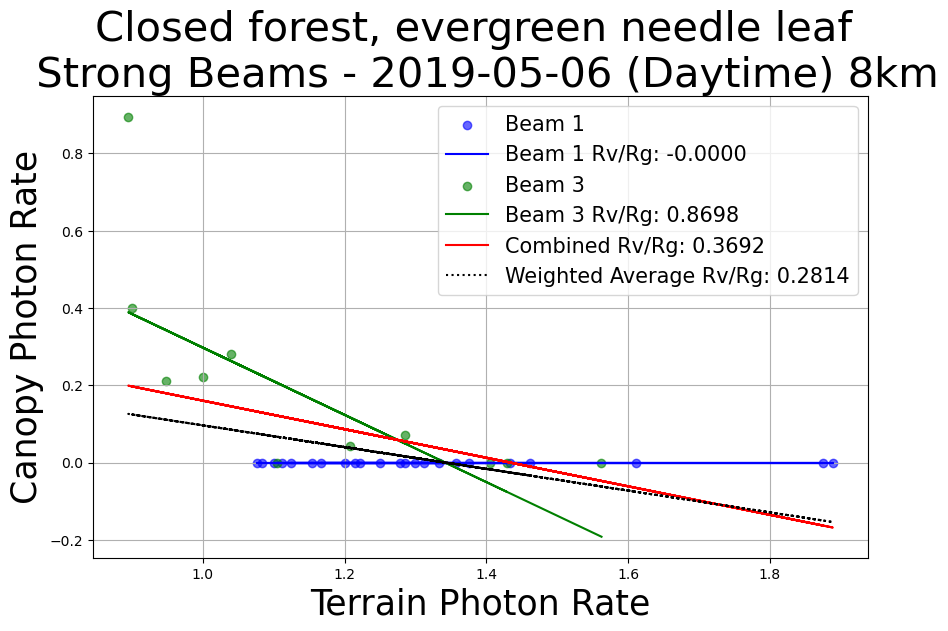

Plot saved as day/DEJU/8/DEJU_2019-05-06_strong__111_8km.png
No valid data for 2019-05-06 with weak beams for landcover Closed forest, evergreen needle leaf. Skipping plot.


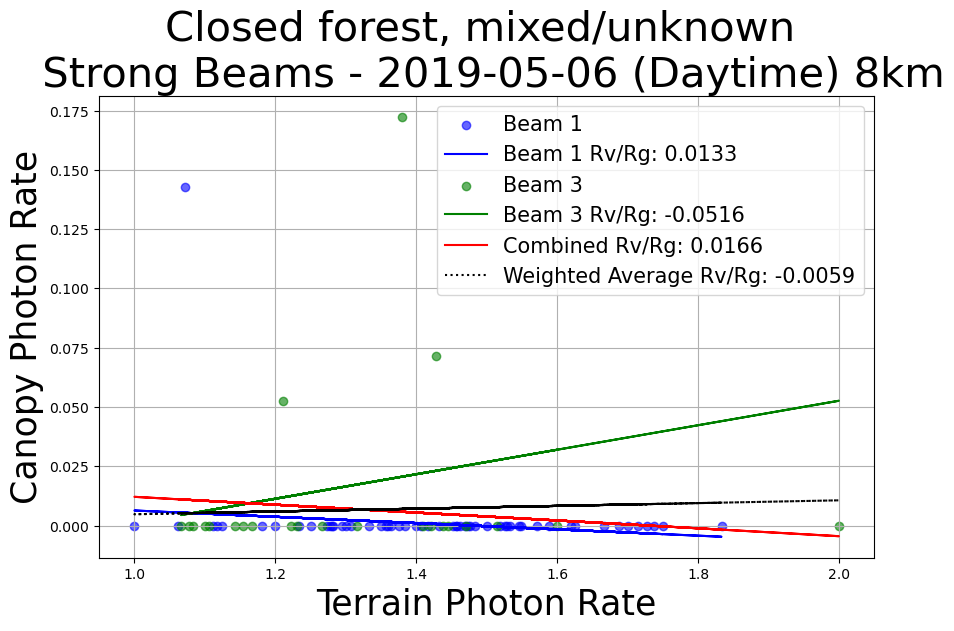

Plot saved as day/DEJU/8/DEJU_2019-05-06_strong__115_116_8km.png
No valid data for 2019-05-06 with weak beams for landcover Closed forest, mixed/unknown. Skipping plot.


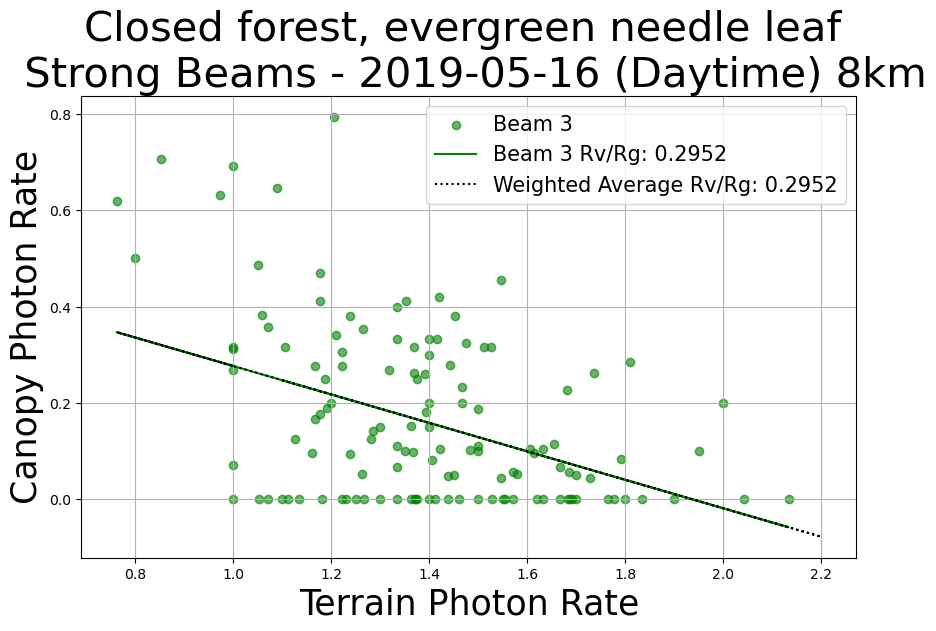

Plot saved as day/DEJU/8/DEJU_2019-05-16_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2019-05-16_weak__111_8km.png


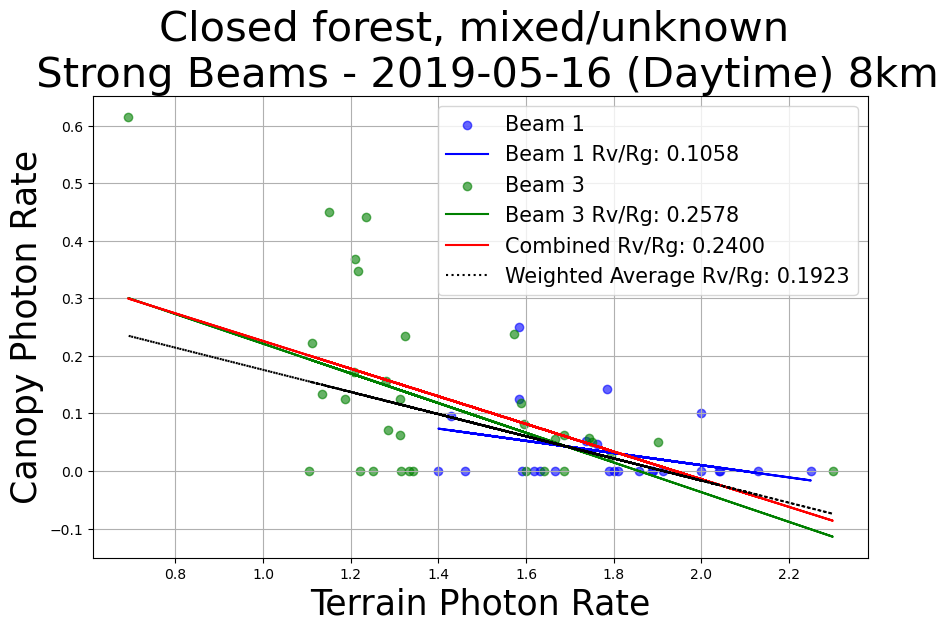

Plot saved as day/DEJU/8/DEJU_2019-05-16_strong__115_116_8km.png
No valid data for 2019-05-16 with weak beams for landcover Closed forest, mixed/unknown. Skipping plot.


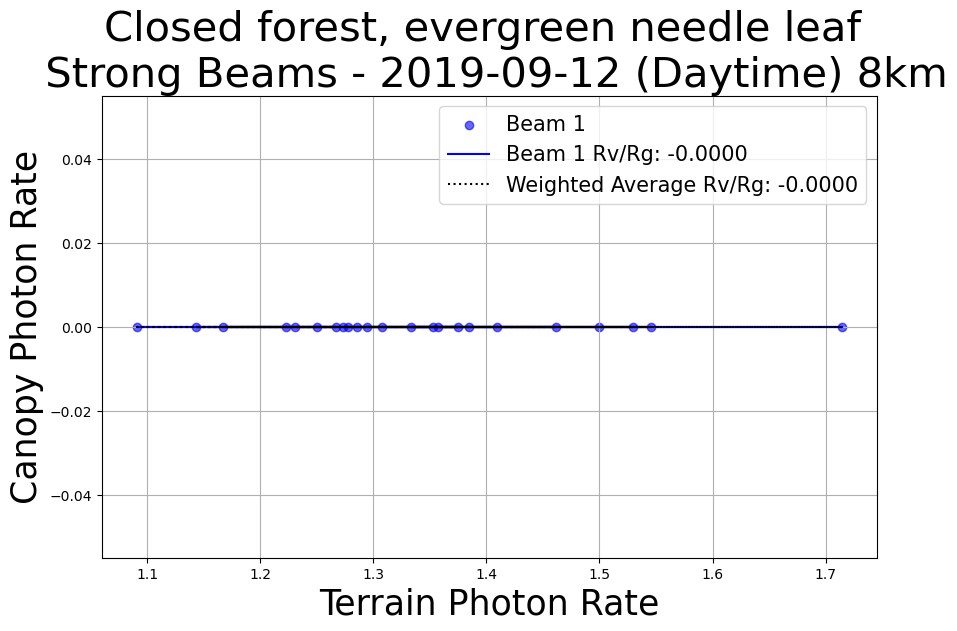

Plot saved as day/DEJU/8/DEJU_2019-09-12_strong__111_8km.png
No valid data for 2019-09-12 with weak beams for landcover Closed forest, evergreen needle leaf. Skipping plot.


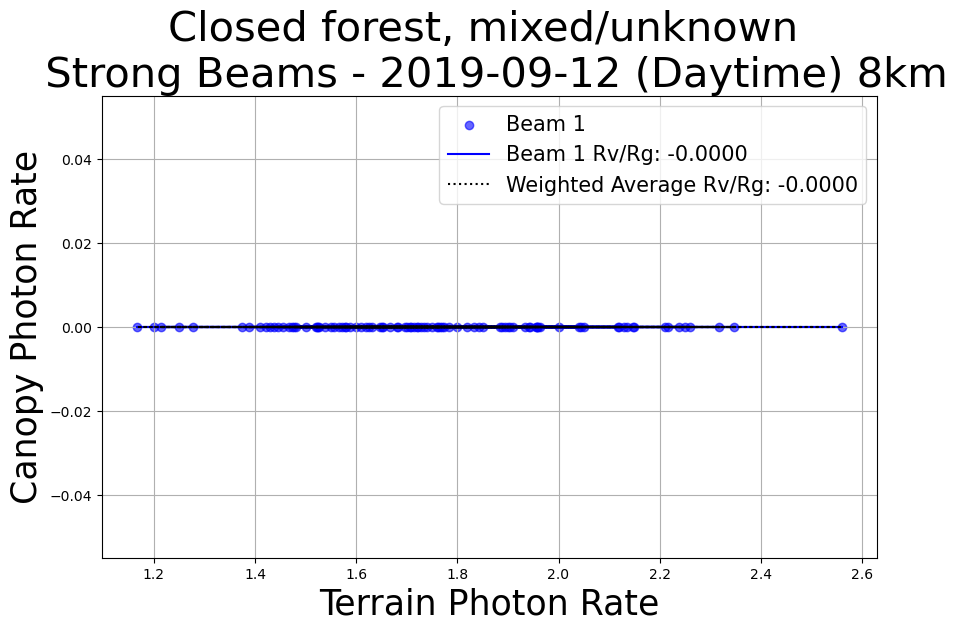

Plot saved as day/DEJU/8/DEJU_2019-09-12_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2019-09-12_weak__115_116_8km.png


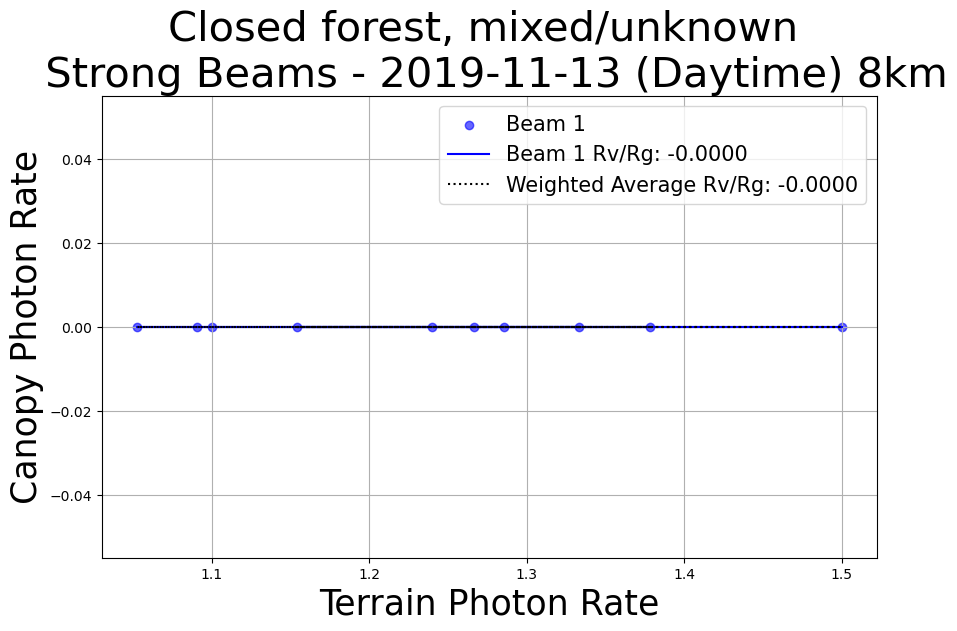

Plot saved as day/DEJU/8/DEJU_2019-11-13_strong__115_116_8km.png
No data available for 2019-11-13 with weak beams for landcover Closed forest, mixed/unknown.


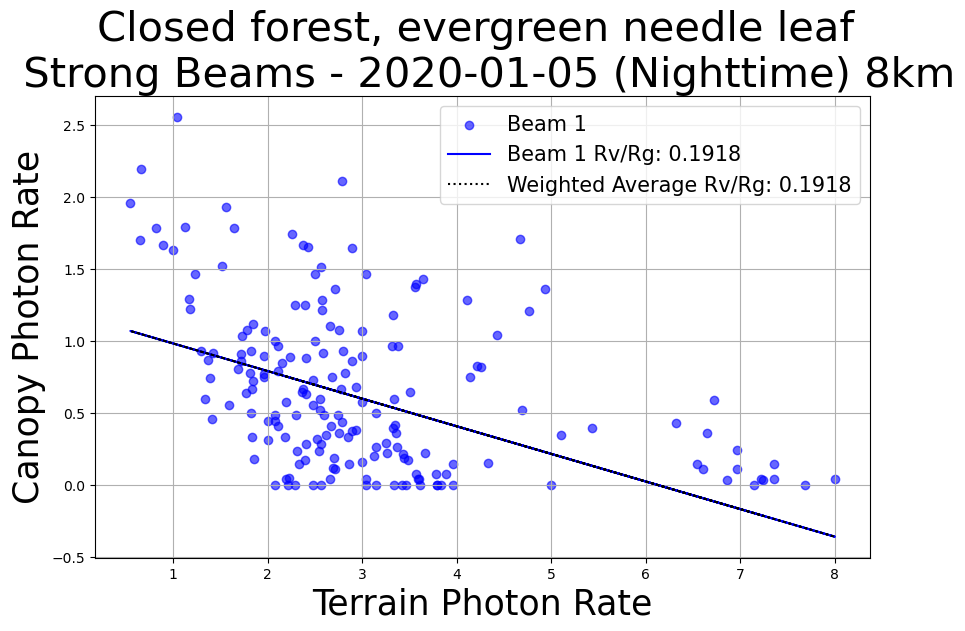

Plot saved as day/DEJU/8/DEJU_2020-01-05_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2020-01-05_weak__111_8km.png


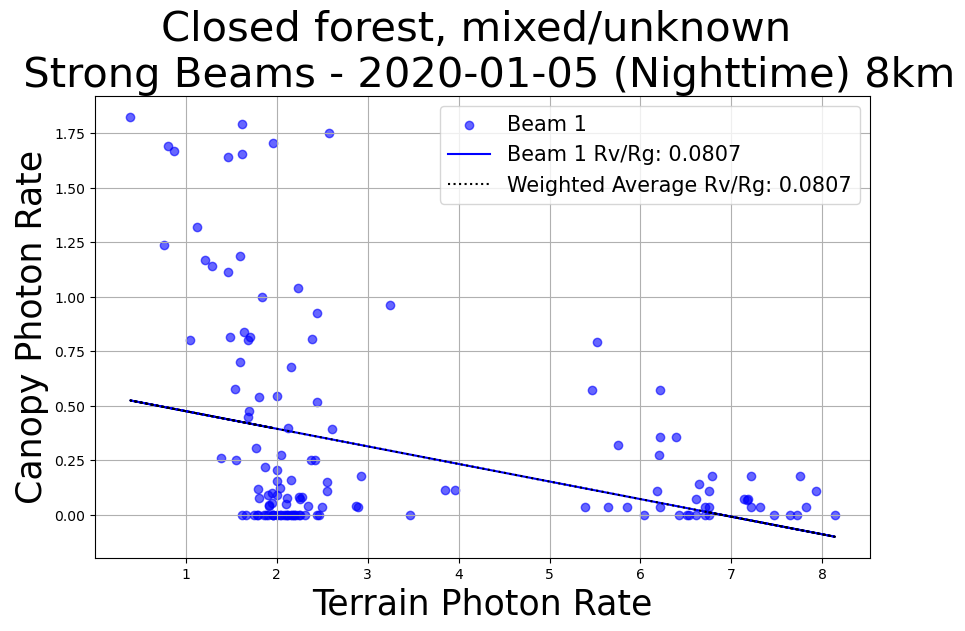

Plot saved as day/DEJU/8/DEJU_2020-01-05_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2020-01-05_weak__115_116_8km.png


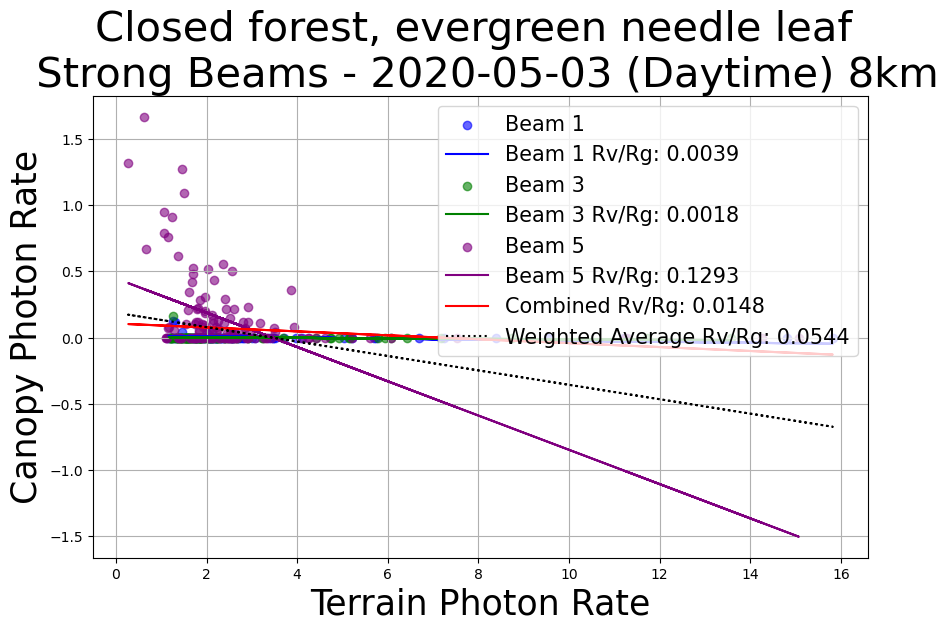

Plot saved as day/DEJU/8/DEJU_2020-05-03_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2020-05-03_weak__111_8km.png


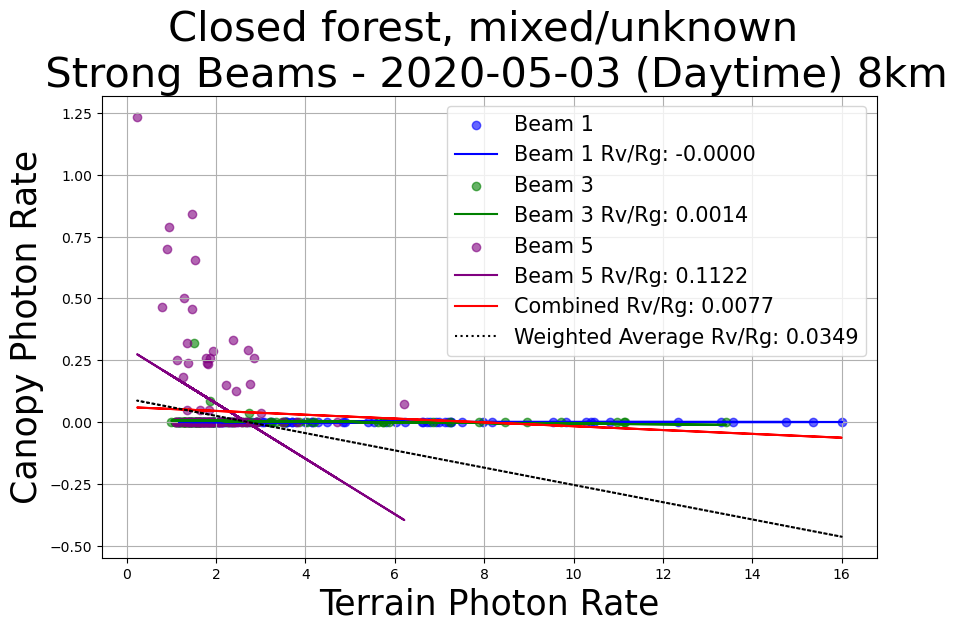

Plot saved as day/DEJU/8/DEJU_2020-05-03_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2020-05-03_weak__115_116_8km.png


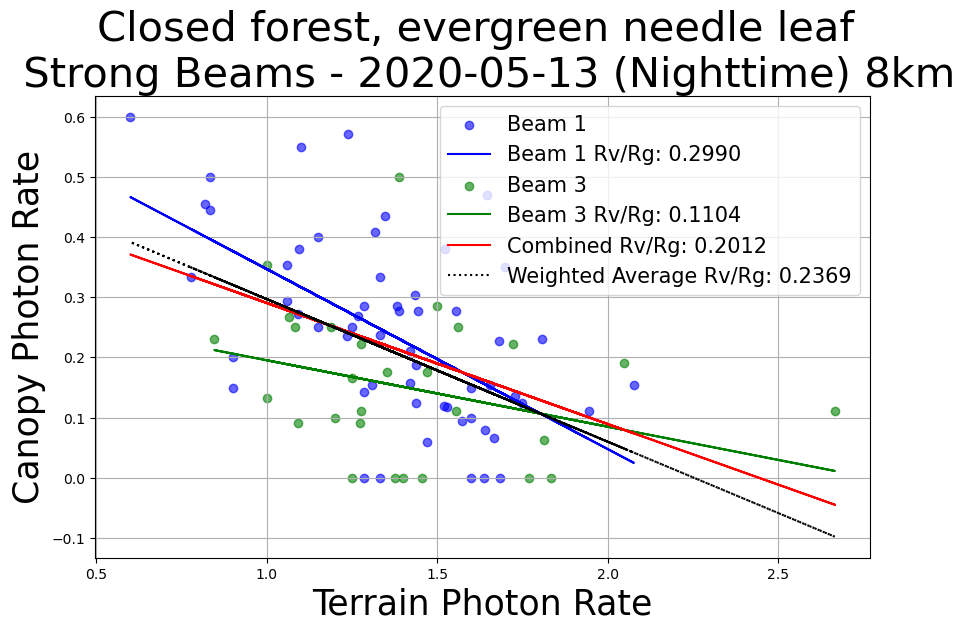

Plot saved as day/DEJU/8/DEJU_2020-05-13_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2020-05-13_weak__111_8km.png


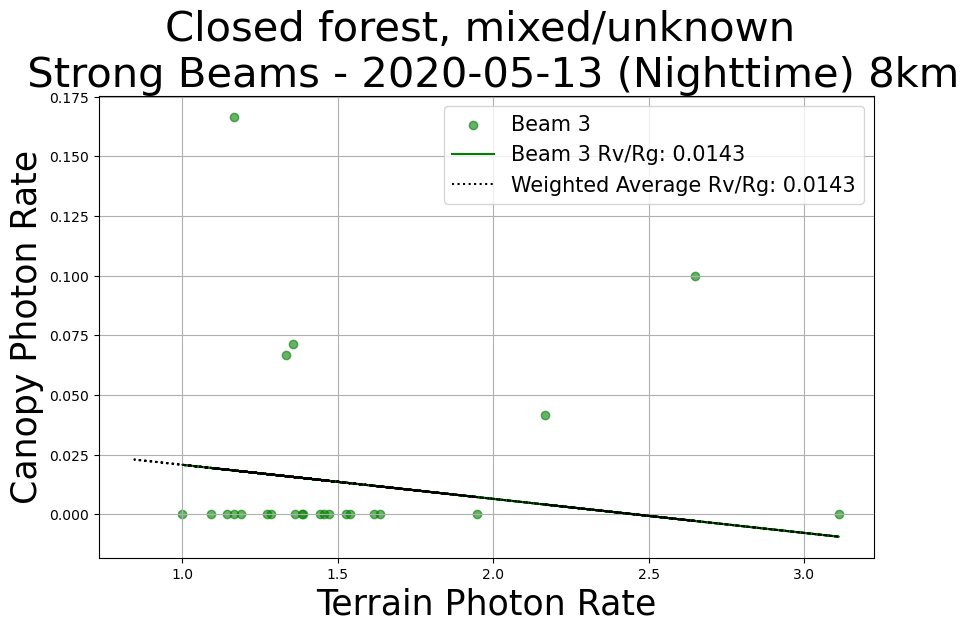

Plot saved as day/DEJU/8/DEJU_2020-05-13_strong__115_116_8km.png
No valid data for 2020-05-13 with weak beams for landcover Closed forest, mixed/unknown. Skipping plot.


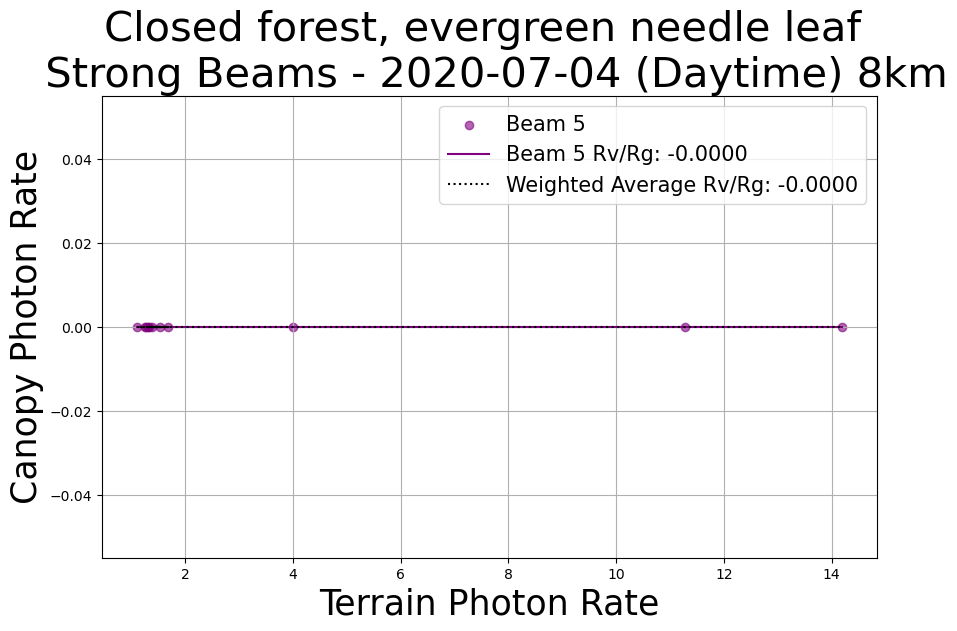

Plot saved as day/DEJU/8/DEJU_2020-07-04_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2020-07-04_weak__111_8km.png


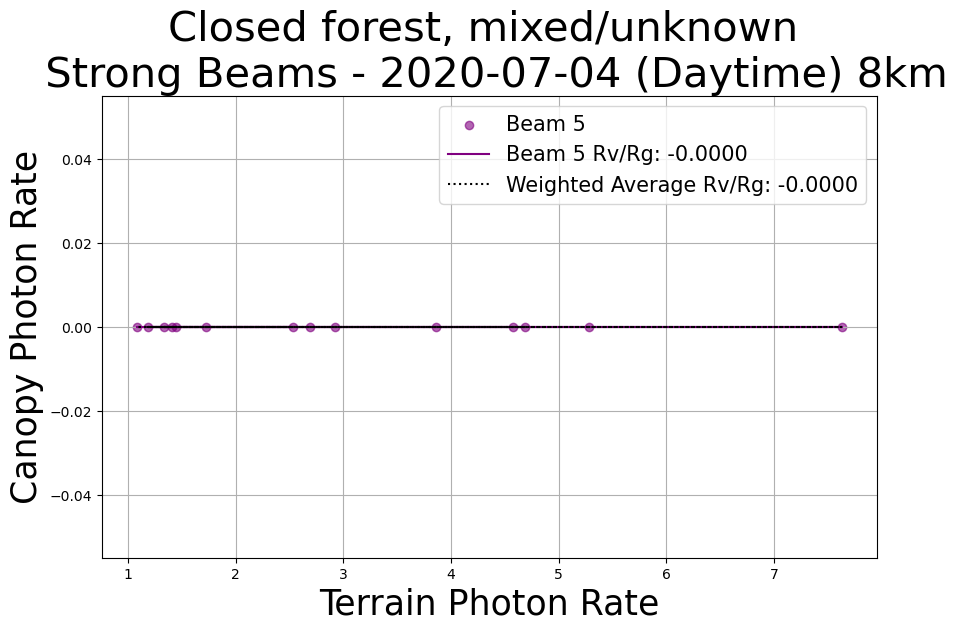

Plot saved as day/DEJU/8/DEJU_2020-07-04_strong__115_116_8km.png
No data available for 2020-07-04 with weak beams for landcover Closed forest, mixed/unknown.


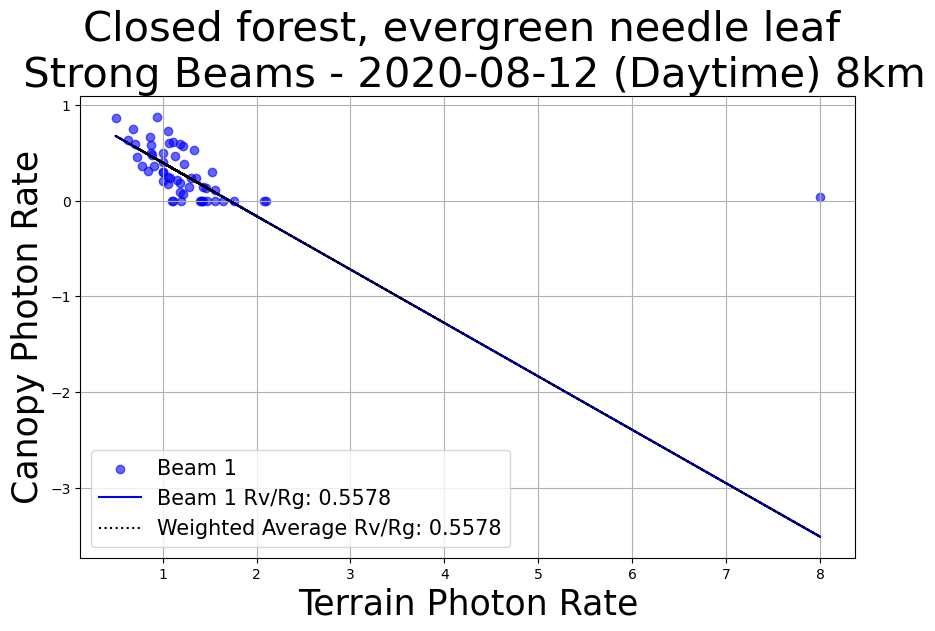

Plot saved as day/DEJU/8/DEJU_2020-08-12_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2020-08-12_weak__111_8km.png
No valid data for 2020-08-12 with strong beams for landcover Closed forest, mixed/unknown. Skipping plot.
No valid data for 2020-08-12 with weak beams for landcover Closed forest, mixed/unknown. Skipping plot.
No valid data for 2020-11-01 with strong beams for landcover Closed forest, mixed/unknown. Skipping plot.
No valid data for 2020-11-01 with weak beams for landcover Closed forest, mixed/unknown. Skipping plot.


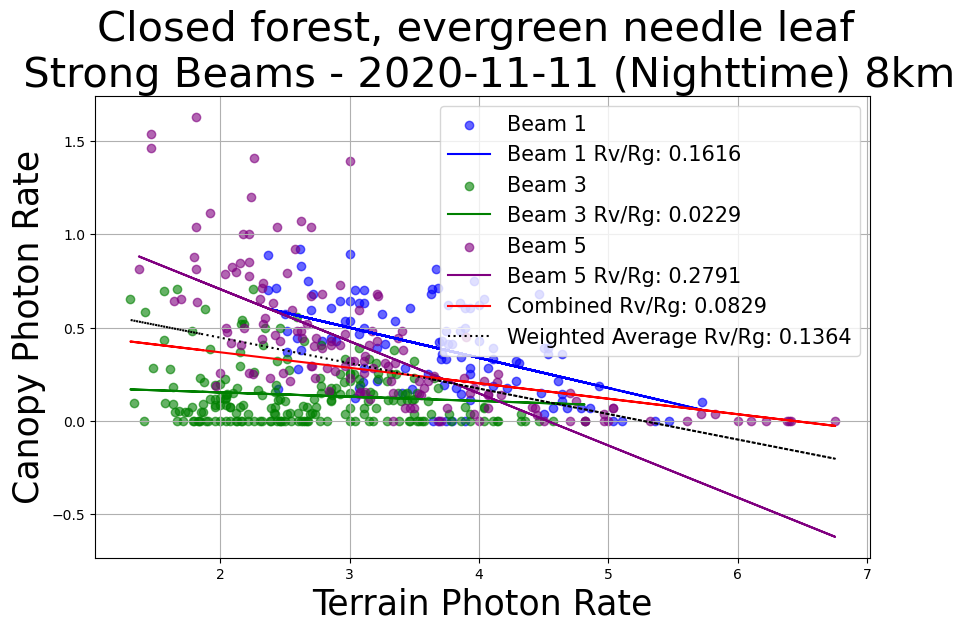

Plot saved as day/DEJU/8/DEJU_2020-11-11_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2020-11-11_weak__111_8km.png


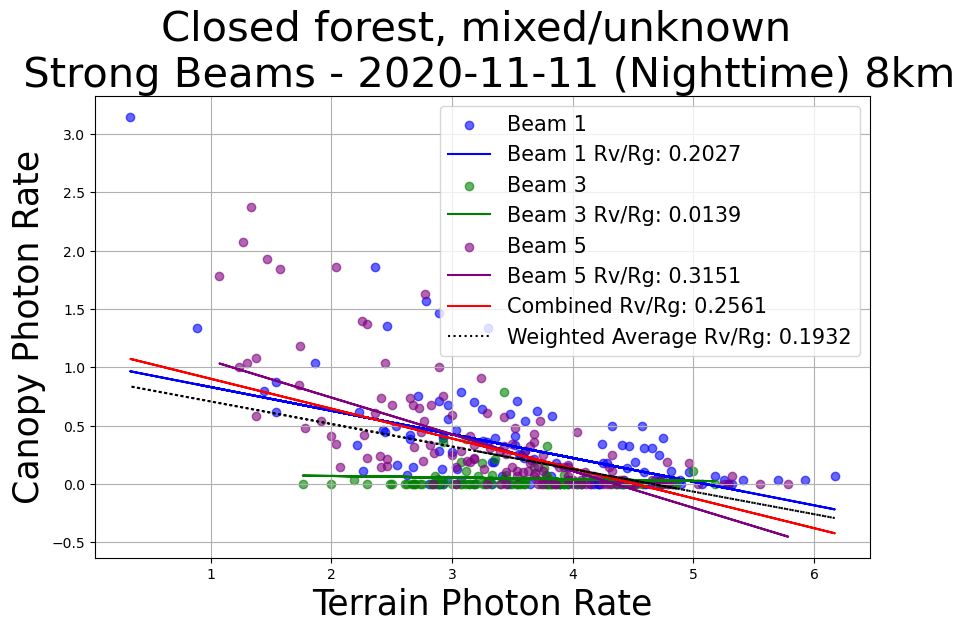

Plot saved as day/DEJU/8/DEJU_2020-11-11_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2020-11-11_weak__115_116_8km.png


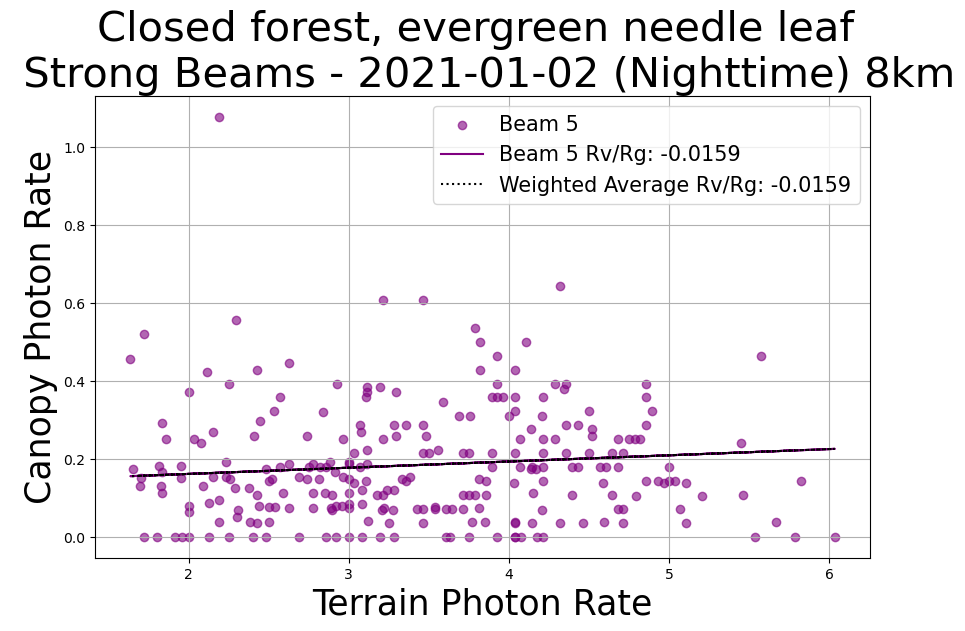

Plot saved as day/DEJU/8/DEJU_2021-01-02_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2021-01-02_weak__111_8km.png


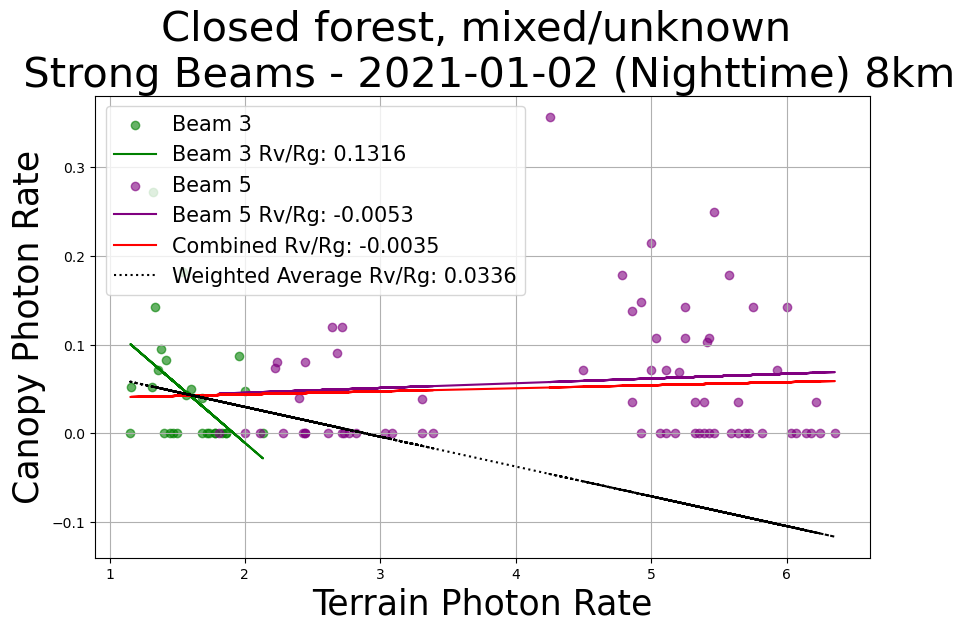

Plot saved as day/DEJU/8/DEJU_2021-01-02_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2021-01-02_weak__115_116_8km.png


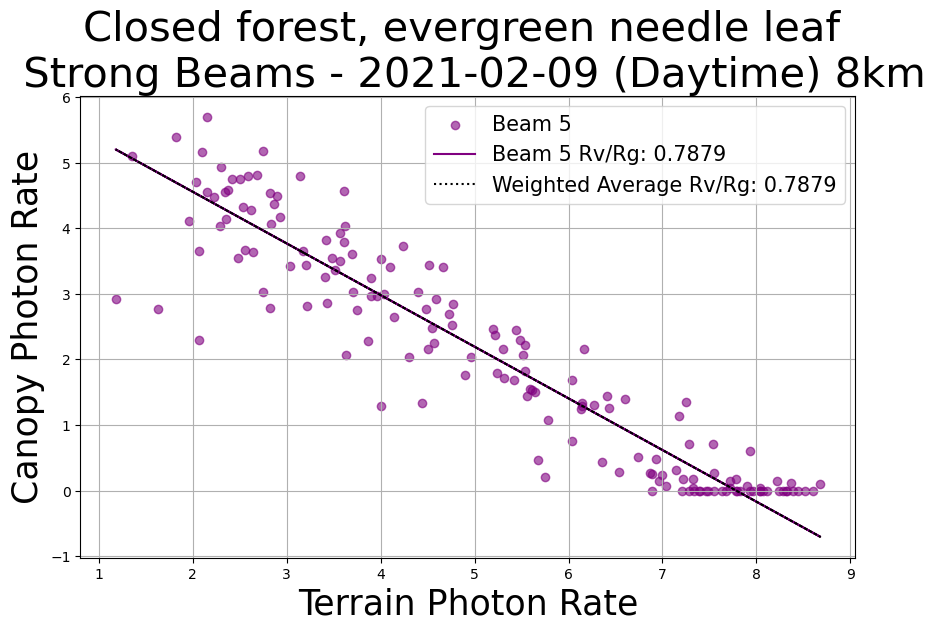

Plot saved as day/DEJU/8/DEJU_2021-02-09_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2021-02-09_weak__111_8km.png


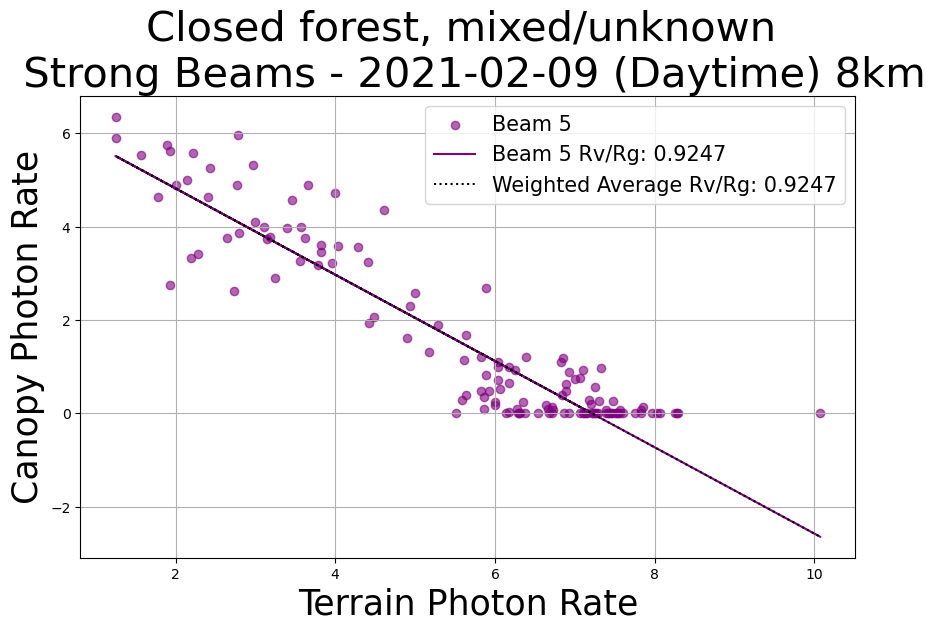

Plot saved as day/DEJU/8/DEJU_2021-02-09_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2021-02-09_weak__115_116_8km.png


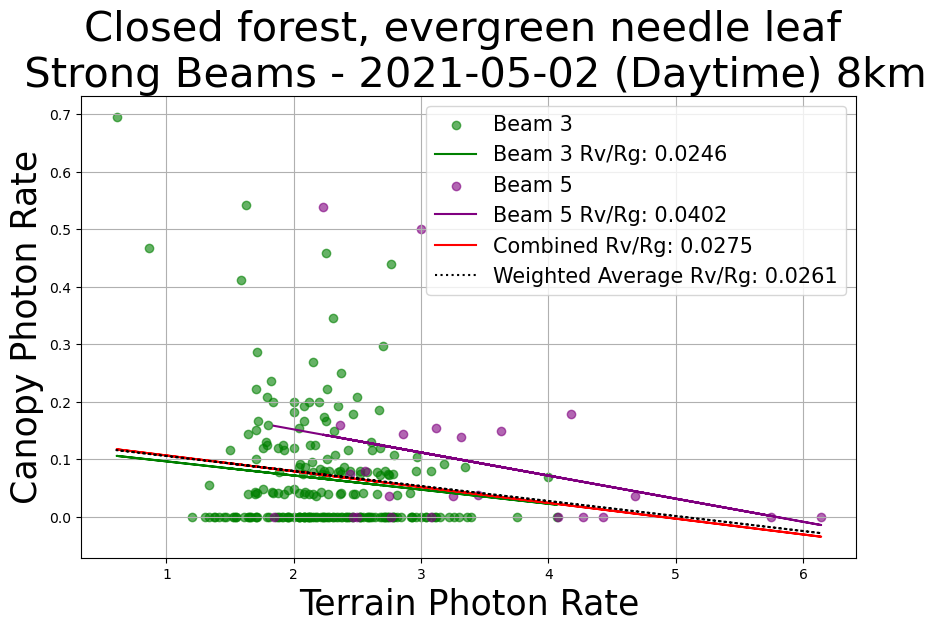

Plot saved as day/DEJU/8/DEJU_2021-05-02_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2021-05-02_weak__111_8km.png


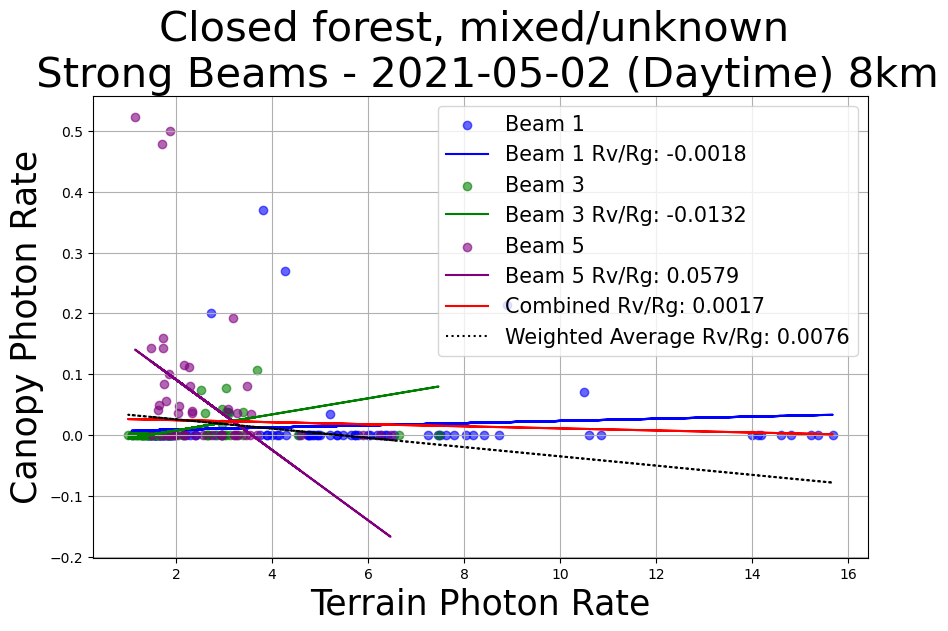

Plot saved as day/DEJU/8/DEJU_2021-05-02_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2021-05-02_weak__115_116_8km.png
No valid data for 2021-05-11 with strong beams for landcover Closed forest, mixed/unknown. Skipping plot.
No data available for 2021-05-11 with weak beams for landcover Closed forest, mixed/unknown.


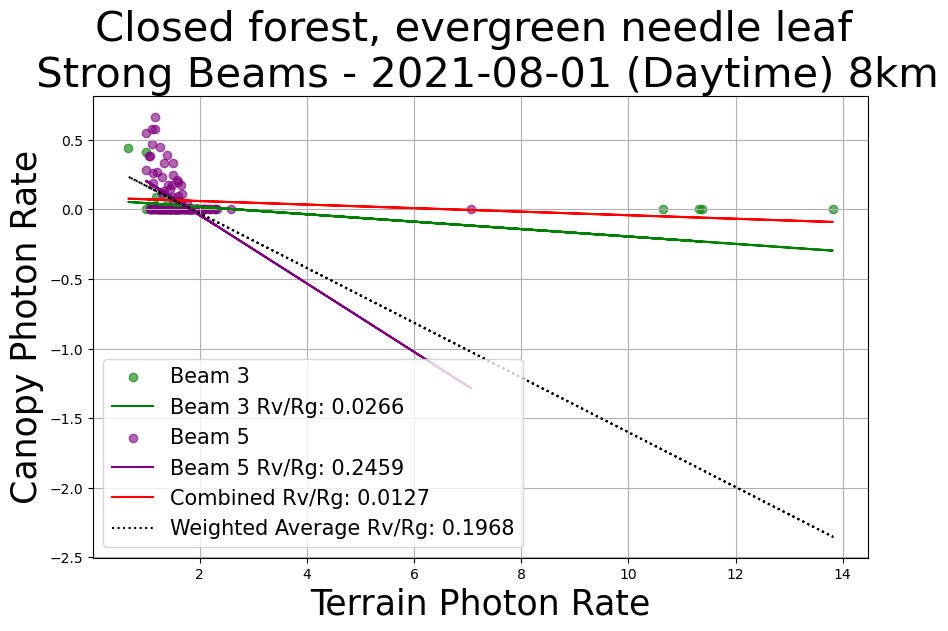

Plot saved as day/DEJU/8/DEJU_2021-08-01_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2021-08-01_weak__111_8km.png


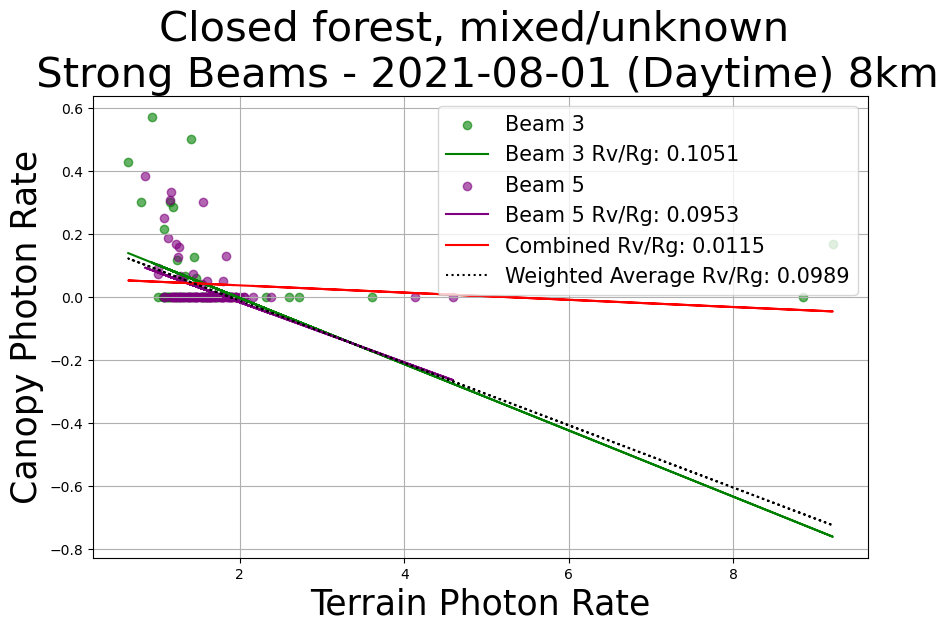

Plot saved as day/DEJU/8/DEJU_2021-08-01_strong__115_116_8km.png
No valid data for 2021-08-01 with weak beams for landcover Closed forest, mixed/unknown. Skipping plot.


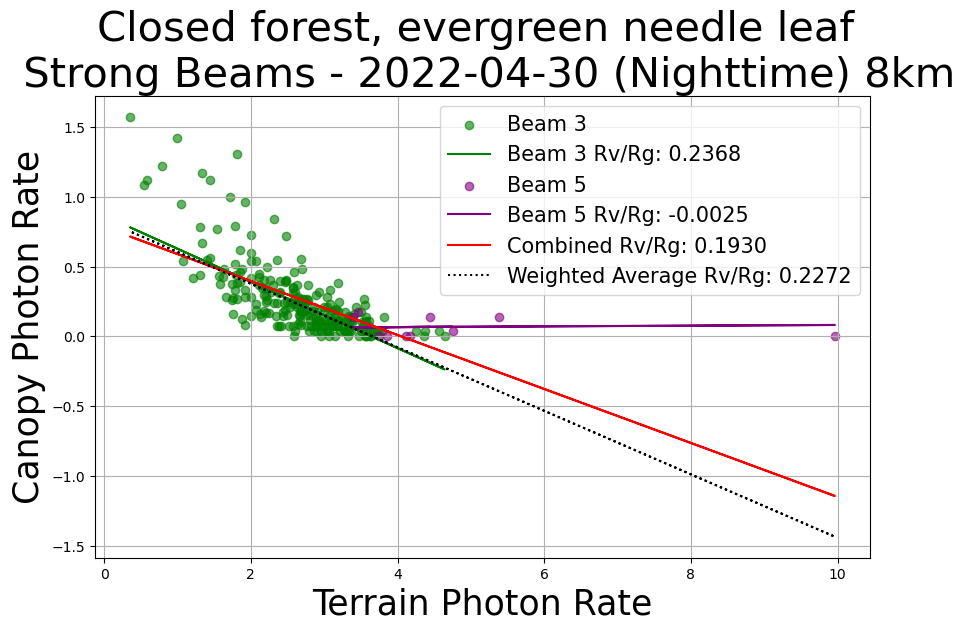

Plot saved as day/DEJU/8/DEJU_2022-04-30_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2022-04-30_weak__111_8km.png


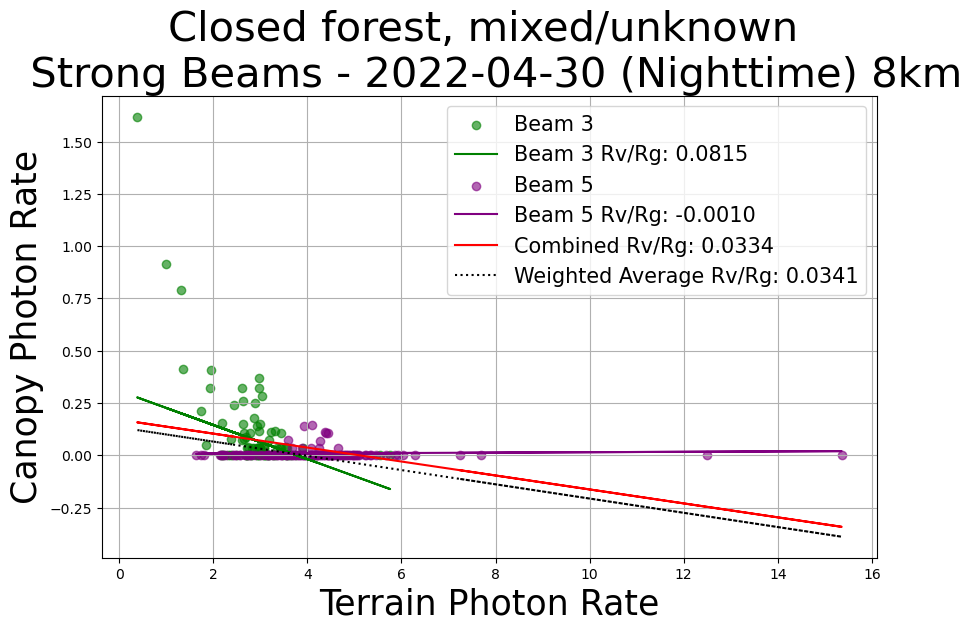

Plot saved as day/DEJU/8/DEJU_2022-04-30_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2022-04-30_weak__115_116_8km.png


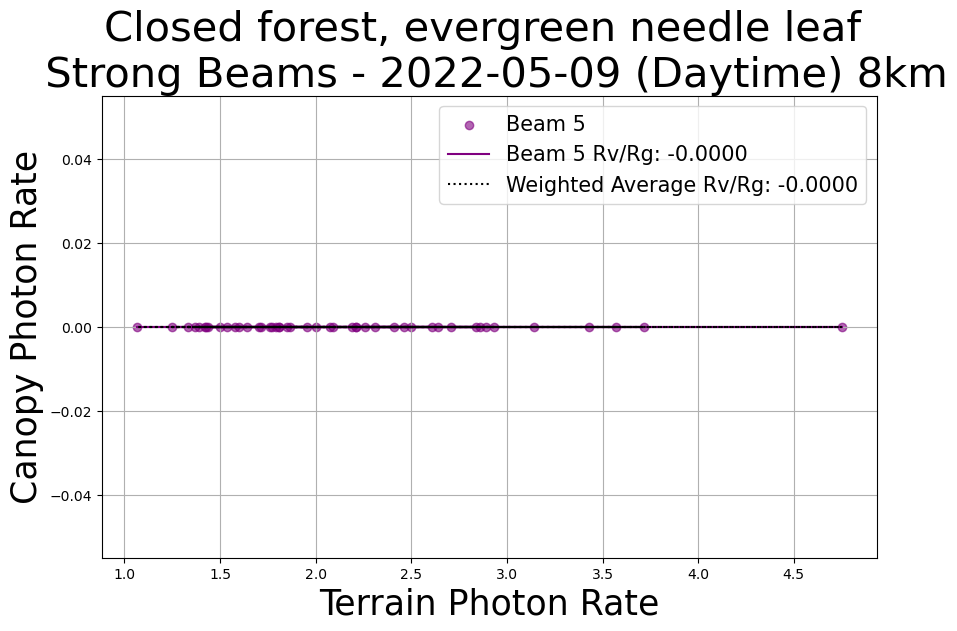

Plot saved as day/DEJU/8/DEJU_2022-05-09_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2022-05-09_weak__111_8km.png


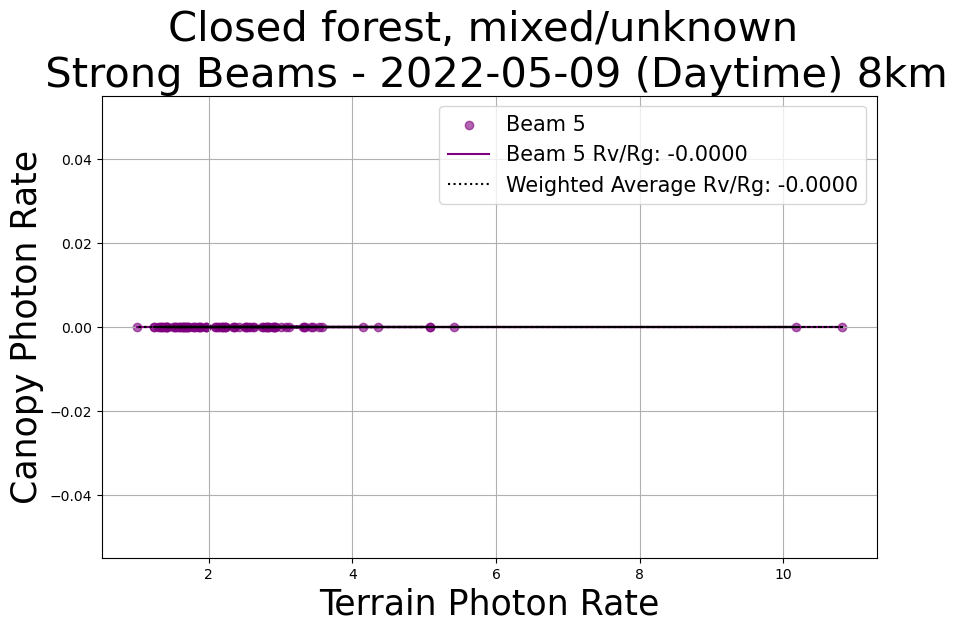

Plot saved as day/DEJU/8/DEJU_2022-05-09_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2022-05-09_weak__115_116_8km.png


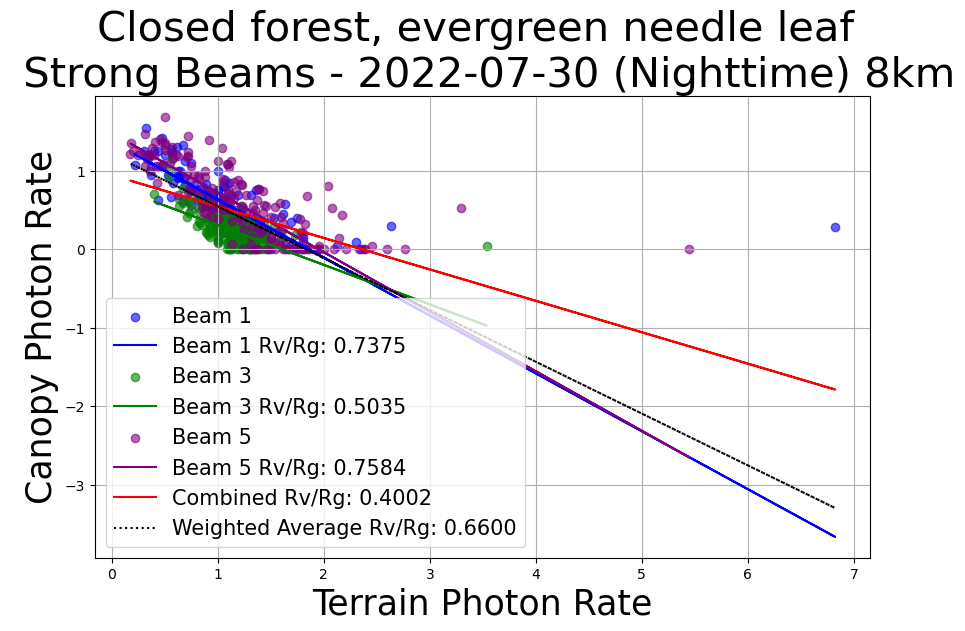

Plot saved as day/DEJU/8/DEJU_2022-07-30_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2022-07-30_weak__111_8km.png


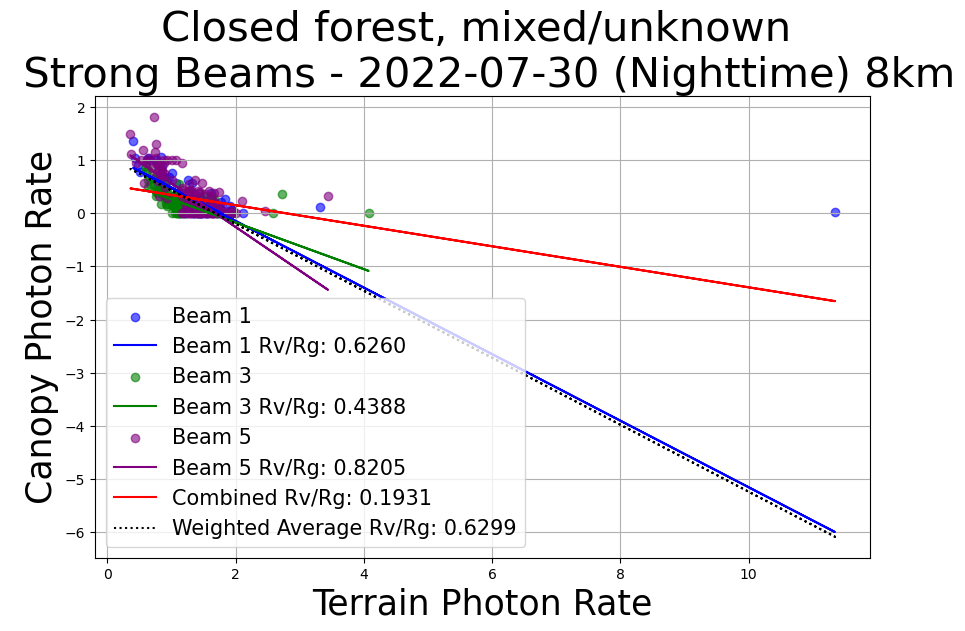

Plot saved as day/DEJU/8/DEJU_2022-07-30_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2022-07-30_weak__115_116_8km.png


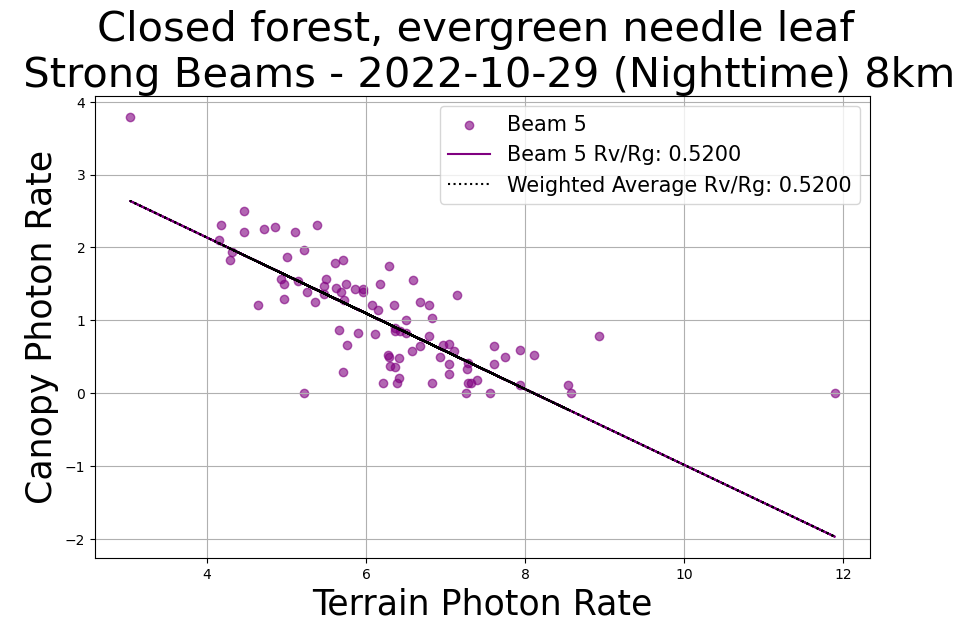

Plot saved as day/DEJU/8/DEJU_2022-10-29_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2022-10-29_weak__111_8km.png


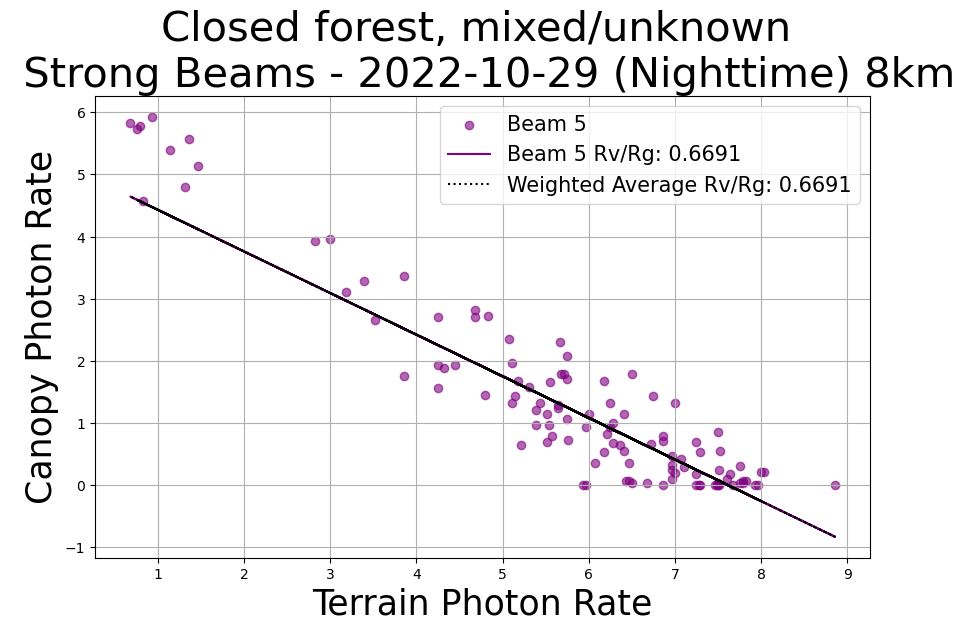

Plot saved as day/DEJU/8/DEJU_2022-10-29_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2022-10-29_weak__115_116_8km.png


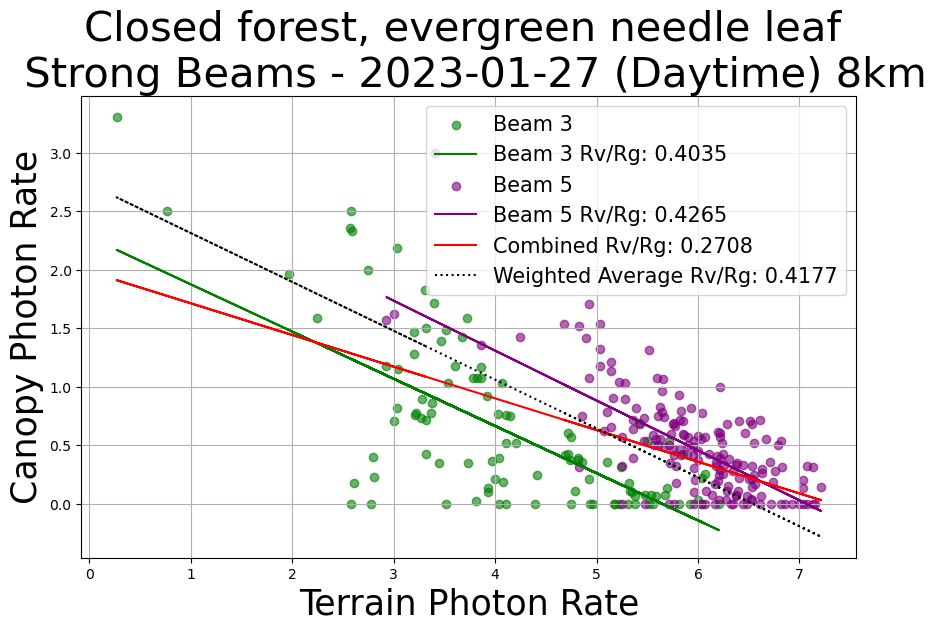

Plot saved as day/DEJU/8/DEJU_2023-01-27_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2023-01-27_weak__111_8km.png


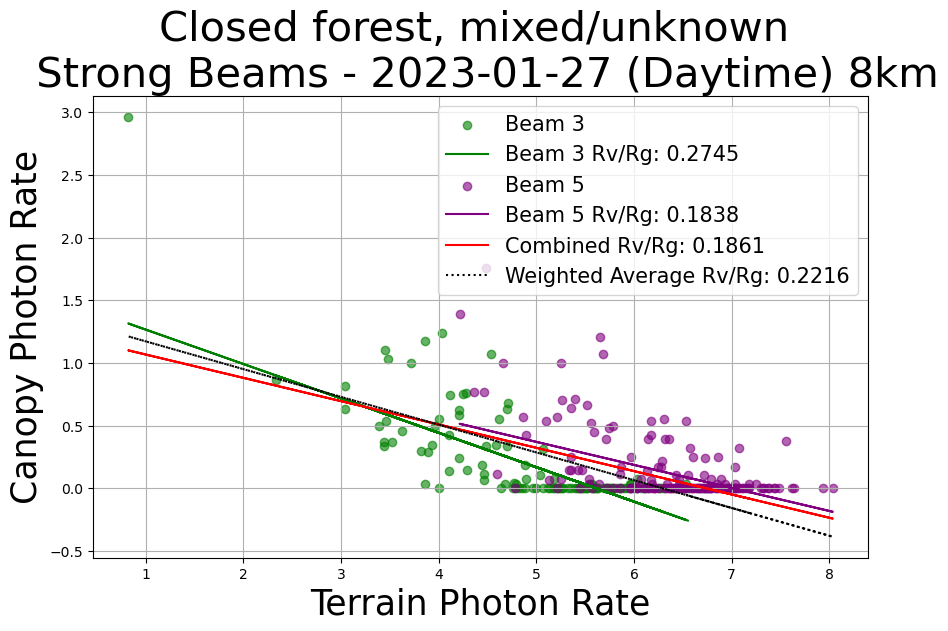

Plot saved as day/DEJU/8/DEJU_2023-01-27_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2023-01-27_weak__115_116_8km.png


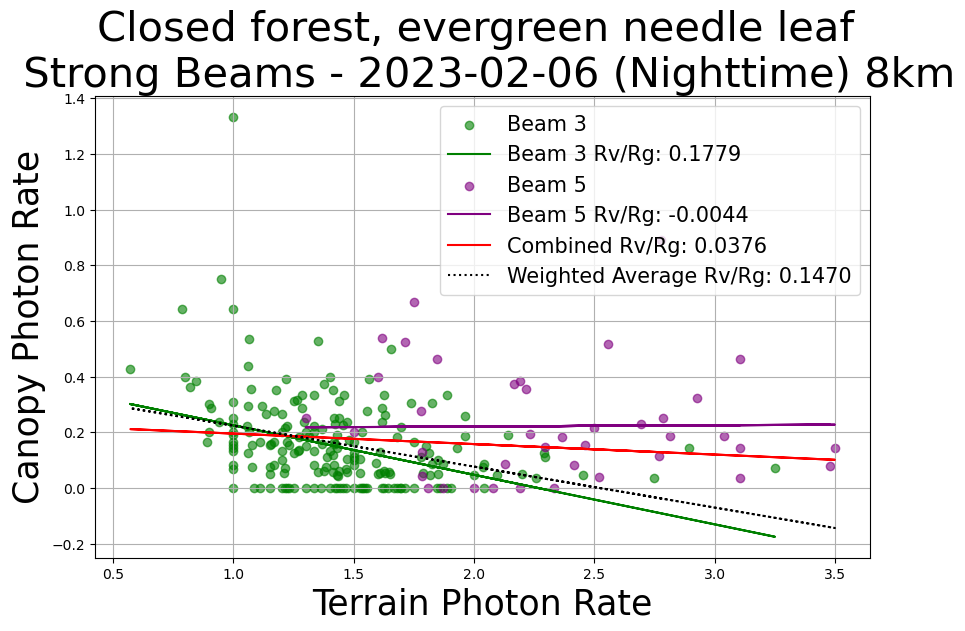

Plot saved as day/DEJU/8/DEJU_2023-02-06_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2023-02-06_weak__111_8km.png


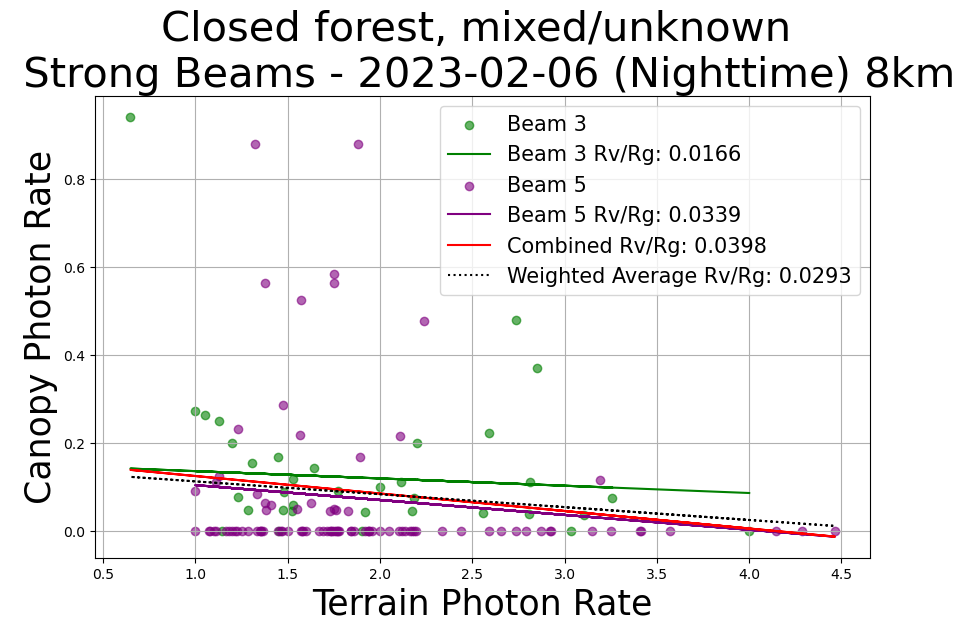

Plot saved as day/DEJU/8/DEJU_2023-02-06_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2023-02-06_weak__115_116_8km.png


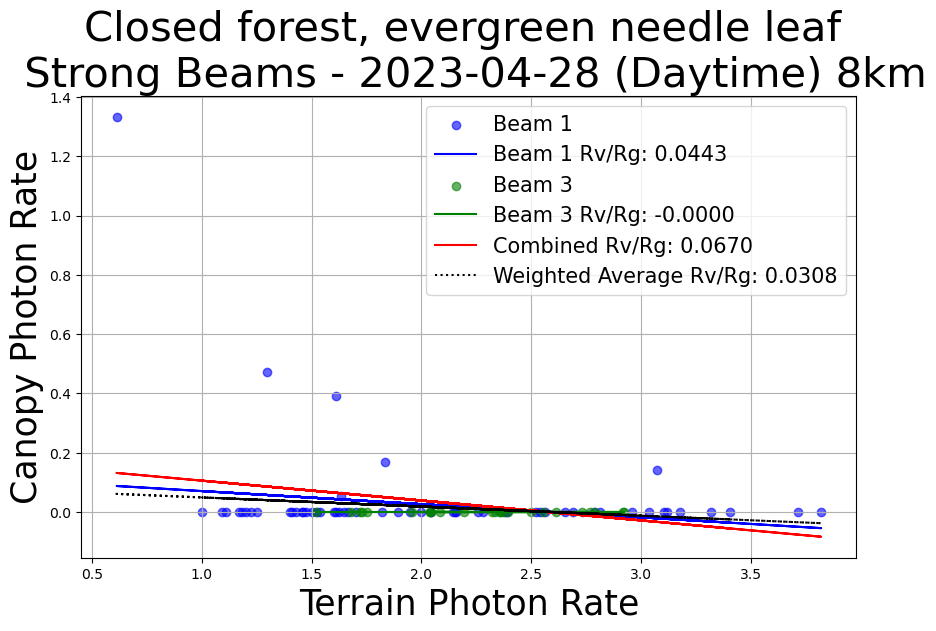

Plot saved as day/DEJU/8/DEJU_2023-04-28_strong__111_8km.png
No valid data for 2023-04-28 with weak beams for landcover Closed forest, evergreen needle leaf. Skipping plot.


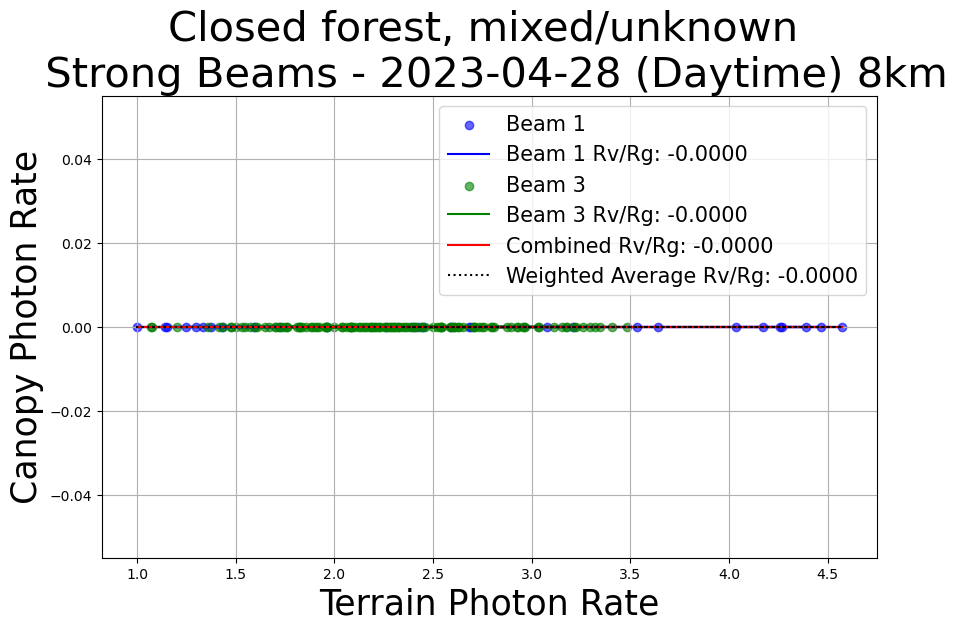

Plot saved as day/DEJU/8/DEJU_2023-04-28_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2023-04-28_weak__115_116_8km.png


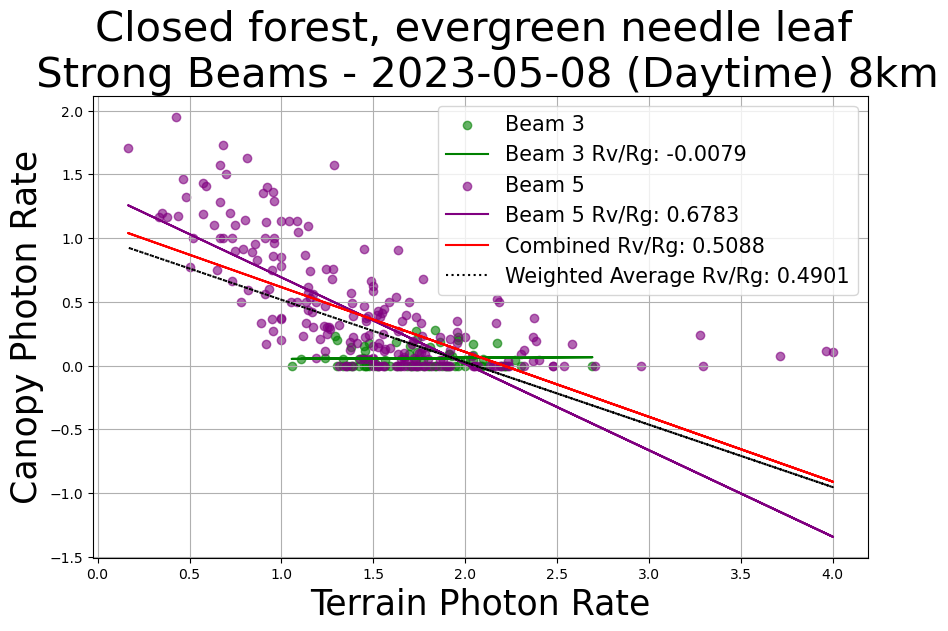

Plot saved as day/DEJU/8/DEJU_2023-05-08_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2023-05-08_weak__111_8km.png


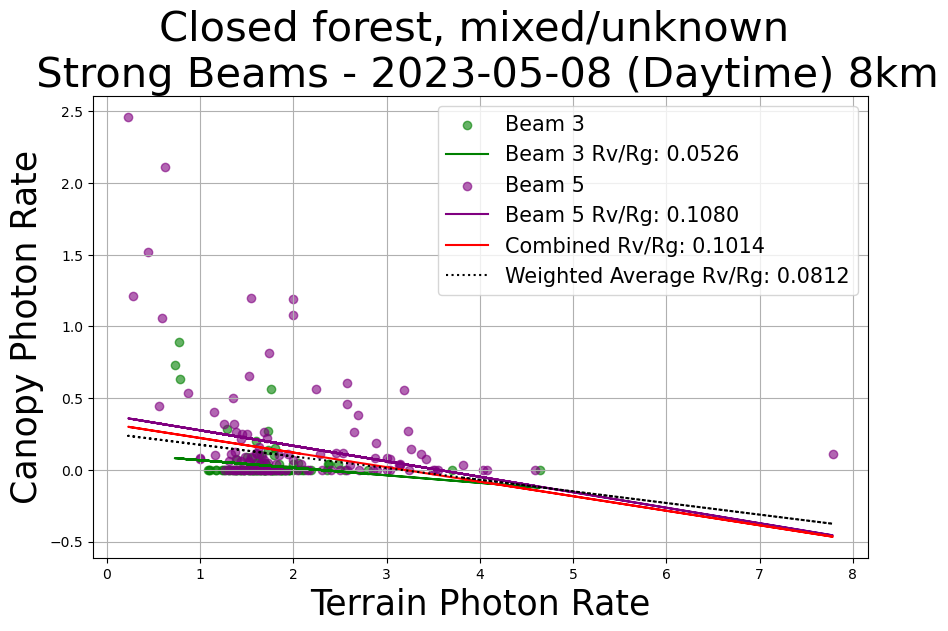

Plot saved as day/DEJU/8/DEJU_2023-05-08_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2023-05-08_weak__115_116_8km.png
No valid data for 2023-07-28 with strong beams for landcover Closed forest, evergreen needle leaf. Skipping plot.
No data available for 2023-07-28 with weak beams for landcover Closed forest, evergreen needle leaf.


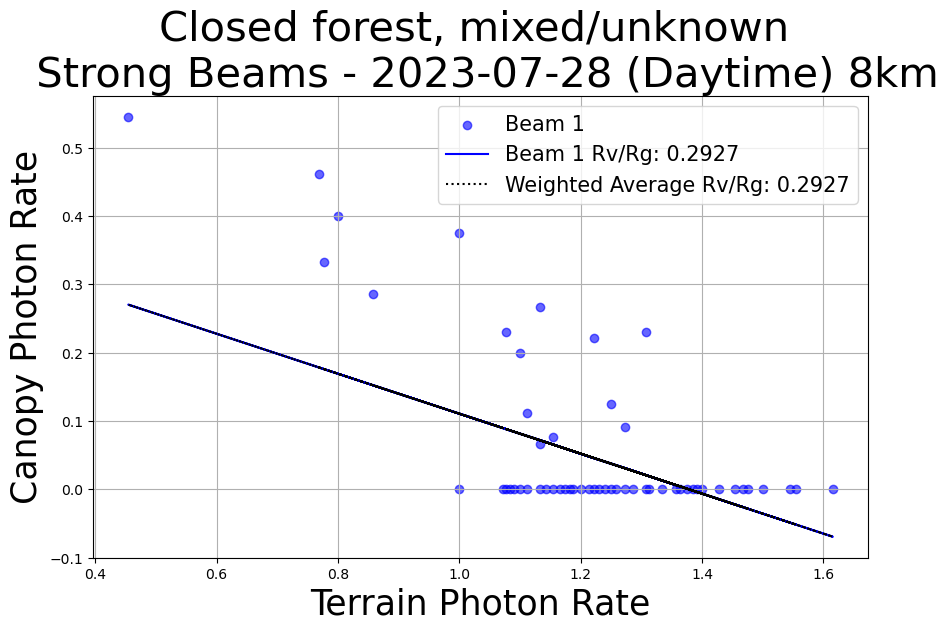

Plot saved as day/DEJU/8/DEJU_2023-07-28_strong__115_116_8km.png
No data available for 2023-07-28 with weak beams for landcover Closed forest, mixed/unknown.


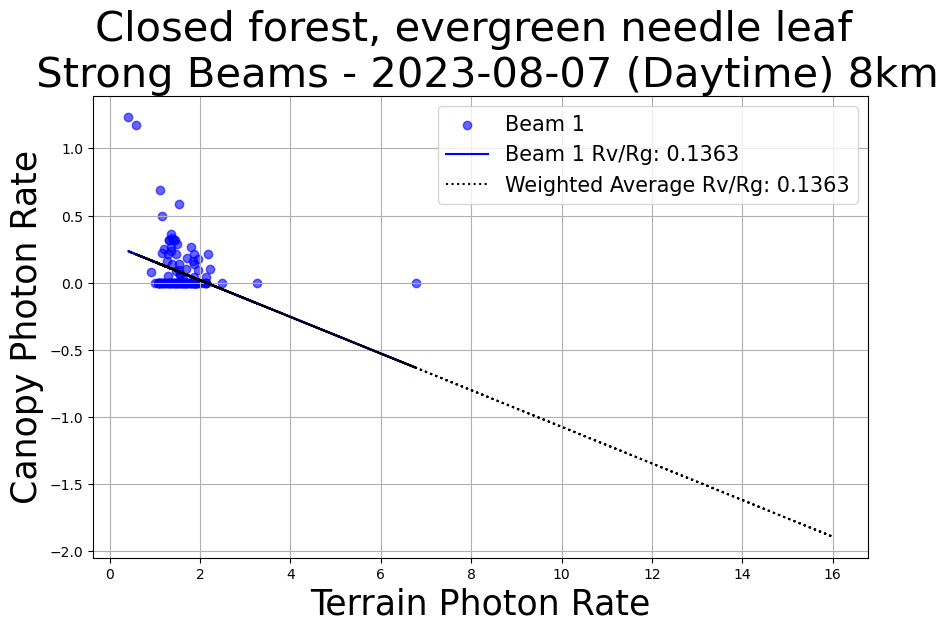

Plot saved as day/DEJU/8/DEJU_2023-08-07_strong__111_8km.png
No valid data for 2023-08-07 with weak beams for landcover Closed forest, evergreen needle leaf. Skipping plot.


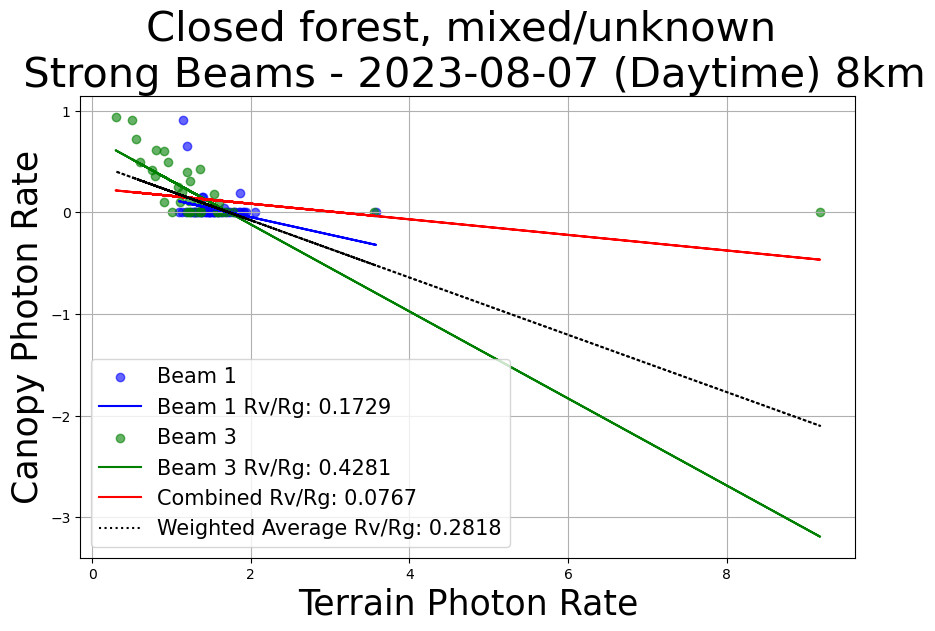

Plot saved as day/DEJU/8/DEJU_2023-08-07_strong__115_116_8km.png
No valid data for 2023-08-07 with weak beams for landcover Closed forest, mixed/unknown. Skipping plot.


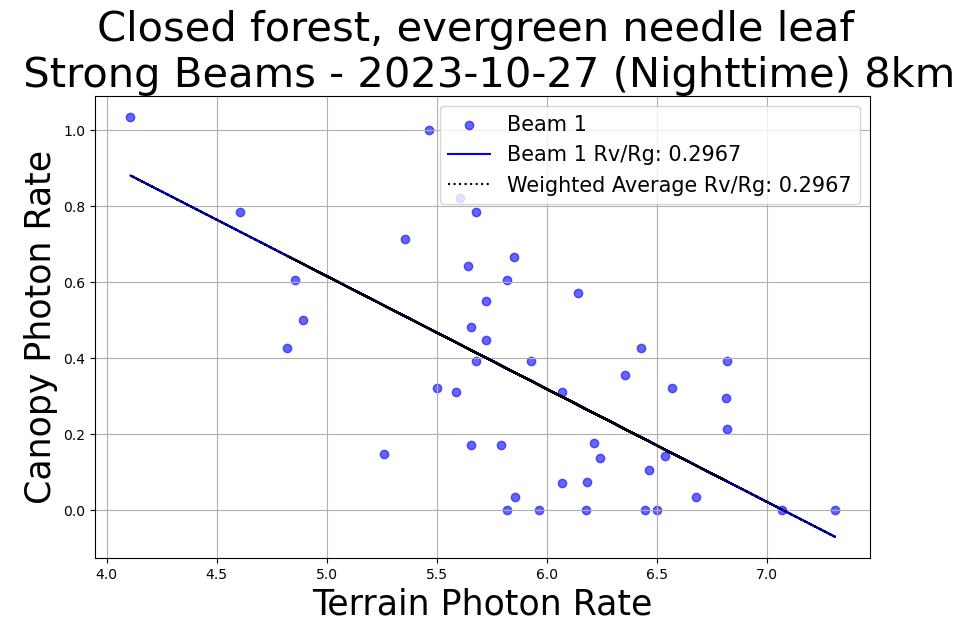

Plot saved as day/DEJU/8/DEJU_2023-10-27_strong__111_8km.png
Plot saved as day/DEJU/8/DEJU_2023-10-27_weak__111_8km.png


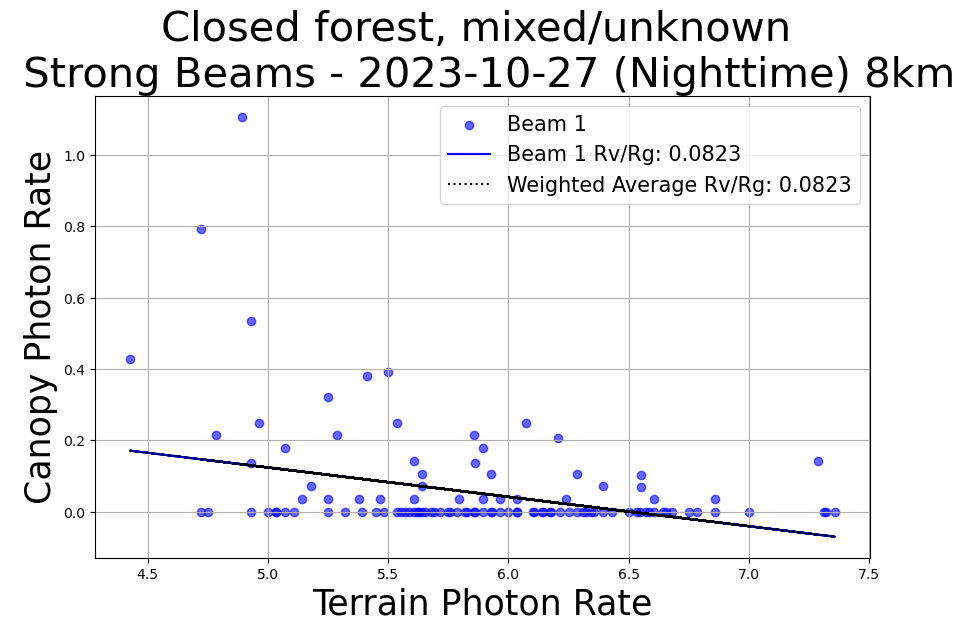

Plot saved as day/DEJU/8/DEJU_2023-10-27_strong__115_116_8km.png
Plot saved as day/DEJU/8/DEJU_2023-10-27_weak__115_116_8km.png
CPU times: user 39.2 s, sys: 1.85 s, total: 41 s
Wall time: 42.5 s


In [21]:
%%time

def weighted_regression(x, y, weights):
    """
    Perform weighted linear regression.

    Args:
        x (array-like): Independent variable.
        y (array-like): Dependent variable.
        weights (array-like): Weights for the regression.

    Returns:
        slope, intercept: Coefficients of the weighted regression line.
    """
    x = np.array(x).flatten()  # Convert x to a 1D array
    y = np.array(y).flatten()  # Convert y to a 1D array
    weights = np.array(weights).flatten()  # Flatten weights to ensure it's a 1D array

    # Check if lengths match
    if len(x) != len(y):
        raise ValueError(f"x and y must have the same length. Found x: {len(x)} and y: {len(y)}")
    if len(x) != len(weights):
        raise ValueError(f"x and weights must have the same length. Found x: {len(x)} and weights: {len(weights)}")

    x = sm.add_constant(x)  # Add intercept term
    
    weights = np.array(weights)  # Convert to NumPy array
    model = sm.WLS(y, x, weights=weights)  # Weighted Least Squares
    results = model.fit()
    return results.params[1], results.params[0]  # slope, intercept

def plot_all_sites_photon(processed_site_data, folder, site_name, solar_elev_counts, boundary_km):
    regression_results = {'strong': {}, 'weak': {}}  # Separate results for strong and weak beam types
    colors = {1: 'blue', 3: 'green', 5: 'purple', 2: 'orange', 4: 'brown', 6: 'pink'}

    # Define landcover types
    valid_landcover_codes_1 = {111}  # Closed forest, evergreen needle leaf
    valid_landcover_codes_2 = {115, 116}  # Closed forest, mixed/unknown

    for date, data in processed_site_data.items():
        daytime_count = solar_elev_counts.get(date, {}).get("daytime", 0)
        nighttime_count = solar_elev_counts.get(date, {}).get("nighttime", 0)
        time_of_day = "Daytime" if daytime_count > nighttime_count else "Nighttime"
        
        # Loop over the two landcover codes
        for landcover_codes, landcover_label in [(valid_landcover_codes_1, 'Closed forest, evergreen needle leaf'), (valid_landcover_codes_2, 'Closed forest, mixed/unknown')]:
            # Filter the data based on the current landcover type
            filtered_data = data[data['landcover_mode'].isin(landcover_codes)].copy()
            if filtered_data.empty:
                continue  # Skip to the next landcover type if no data for this landcover

            # Create a plot for this landcover type
            fig, ax = plt.subplots(figsize=(10, 6))

            # Loop through strong and weak beam types
            for beam_type, beams in {'strong': [1, 3, 5], 'weak': [2, 4, 6]}.items():
                regression_results[beam_type].setdefault(landcover_label, {}).setdefault(date, {})['time_of_day'] = time_of_day
                target_date = pd.to_datetime(date).date()
                filtered_data['constructed_date'] = pd.to_datetime(filtered_data[['year', 'month', 'day']])
                beam_filter = filtered_data['spot'].isin(beams)
                filtered_data_for_beams = filtered_data[(filtered_data['constructed_date'].dt.date == target_date) & beam_filter]
                filtered_data_for_beams = filtered_data_for_beams.dropna(subset=['canopy_photon_rate', 'terrain_photon_rate'])
                filtered_data_for_beams = filtered_data_for_beams.drop_duplicates(subset=['canopy_photon_rate', 'terrain_photon_rate'])

                if filtered_data_for_beams.empty:
                    print(f"No data available for {target_date} with {beam_type} beams for landcover {landcover_label}.")
                    continue

                # Only plot scatter for beams with >= 10 points
                valid_beams = [beam for beam in beams if len(filtered_data_for_beams[filtered_data_for_beams['spot'] == beam]) >= 10]

                # If no valid beams, skip to the next date
                if not valid_beams:
                    print(f"No valid data for {date} with {beam_type} beams for landcover {landcover_label}. Skipping plot.")
                    plt.close()
                    continue

                # Initialize lists to store regression results and weights
                beam_regression_results = []
                weights = []  # Store corresponding weights (data points per beam)

                # Loop through each valid beam for plotting and regression
                for beam in valid_beams:
                    
                    beam_data = filtered_data_for_beams[filtered_data_for_beams['spot'] == beam]
                    ax.scatter(beam_data['terrain_photon_rate'], beam_data['canopy_photon_rate'], 
                               color=colors[beam], label=f"Beam {beam}", alpha=0.6)

                    # Calculate weights based on terrain standard deviations
                    terrain_mean = beam_data['terrain_photon_rate'].mean()
                    terrain_std = beam_data['terrain_photon_rate'].std()
                    terrain_deviation = np.abs((beam_data['terrain_photon_rate'] - terrain_mean) / terrain_std)
                    terrain_weight = np.exp(-0.5 * (terrain_deviation ** 2))
                    beam_weights = terrain_weight

                    # Perform weighted regression
                    slope, intercept = weighted_regression(beam_data['terrain_photon_rate'], beam_data['canopy_photon_rate'], beam_weights)
                    regression_line = slope * beam_data['terrain_photon_rate'] + intercept
                    rv_rg = -1 * slope
                    ax.plot(beam_data['terrain_photon_rate'], regression_line, linestyle='-', label=f"Beam {beam} Rv/Rg: {rv_rg:.4f}", color=colors[beam])
                    beam_regression_results.append(rv_rg)
                    weights.append(len(beam_data))  # Store number of data points for each beam

                    regression_results[beam_type].setdefault(landcover_label, {}).setdefault(date, {})[beam] = {'slope': slope, 'intercept': intercept}

                # Combined regression for the entire dataset
                if len(beam_regression_results) > 1:
                    combined_slope, combined_intercept, *_ = linregress(filtered_data_for_beams['terrain_photon_rate'], filtered_data_for_beams['canopy_photon_rate'])
                    combined_line = combined_slope * filtered_data_for_beams['terrain_photon_rate'] + combined_intercept
                    combined_rv_rg = -combined_slope
                    ax.plot(filtered_data_for_beams['terrain_photon_rate'], combined_line, color='red', label=f"Combined Rv/Rg: {combined_rv_rg:.4f}")
                    regression_results[beam_type].setdefault(landcover_label, {}).setdefault(date, {})['combined'] = {'rv_rg': combined_rv_rg, 'slope': combined_slope, 'intercept': combined_intercept}

                # Calculate the weighted average Rv/Rg for beams with >= 10 data points
                if beam_regression_results:
                    valid_slopes = [regression_results[beam_type].get(landcover_label, {}).get(date, {}).get(beam, {}).get('slope', 0)for beam in valid_beams]
                    valid_intercepts = [regression_results[beam_type].get(landcover_label, {}).get(date, {}).get(beam, {}).get('intercept', 0) for beam in valid_beams]

                    # Calculate weighted average for intercepts and slopes
                    weighted_avg_intercept = np.average(valid_intercepts, weights=weights)
                    weighted_avg_slope = np.average(valid_slopes, weights=weights)
                    weighted_avg_rv_rg = -weighted_avg_slope  # Since Rv/Rg = -slope

                    # Plot the weighted average regression line
                    avg_regression_line = weighted_avg_slope * filtered_data_for_beams['terrain_photon_rate'] + weighted_avg_intercept
                    ax.plot(filtered_data_for_beams['terrain_photon_rate'], avg_regression_line, color='black', linestyle=':', 
                            label=f"Weighted Average Rv/Rg: {weighted_avg_rv_rg:.4f}")

                    # Store the weighted average results
                    regression_results[beam_type].setdefault(landcover_label, {}).setdefault(date, {})['weighted_average'] = {
                        'rv_rg': weighted_avg_rv_rg, 
                        'slope': weighted_avg_slope, 
                        'intercept': weighted_avg_intercept
                    }
                # Check if any data is plotted before saving
                if not ax.has_data():
                    print(f"No valid data to plot for {landcover_label} on {date}. Skipping save.")
                    plt.close()
                    continue  # Skip saving the plot if there's no data
                    
                # Plot settings
                ax.set_xlabel('Terrain Photon Rate', fontsize=25)
                ax.set_ylabel('Canopy Photon Rate', fontsize=25)
                ax.set_title(f'{landcover_label} \n {beam_type.capitalize()} Beams - {target_date} ({time_of_day}) {boundary_km}km', fontsize=30)
                ax.legend(fontsize=15)
                ax.grid(True)
                
                save_folder = os.path.join(folder, site_name, boundary_km)
                os.makedirs(save_folder, exist_ok=True)
                landcover_code = "_111" if landcover_codes == valid_landcover_codes_1 else "_115_116"
                savefile = os.path.join(save_folder, f'{site_name}_{date}_{beam_type}_{landcover_code}_{boundary_km}km.png')
                if (beam_type != "weak"):
                    plt.savefig(savefile, bbox_inches='tight', dpi=300)
                plt.show()
                print(f"Plot saved as {savefile}")

            plt.close()

    return regression_results

regression_results_strong = plot_all_sites_photon(new_processed_site_data, day_folder, site_name, solar_elev_counts, boundary_km)

Filtered data for landcover Closed forest, evergreen needle leaf, date 2019-05-06, weak beams: 8 points
No valid data for 2019-05-06 with weak beams for landcover Closed forest, evergreen needle leaf. Skipping plot.
Filtered data for landcover Closed forest, evergreen needle leaf, date 2019-05-16, weak beams: 31 points
test: [4]
Beam 4: 27 points
Spot value counts for beam 4:
spot
4    27
Name: count, dtype: int64
Weak Beam 4: Color = brown


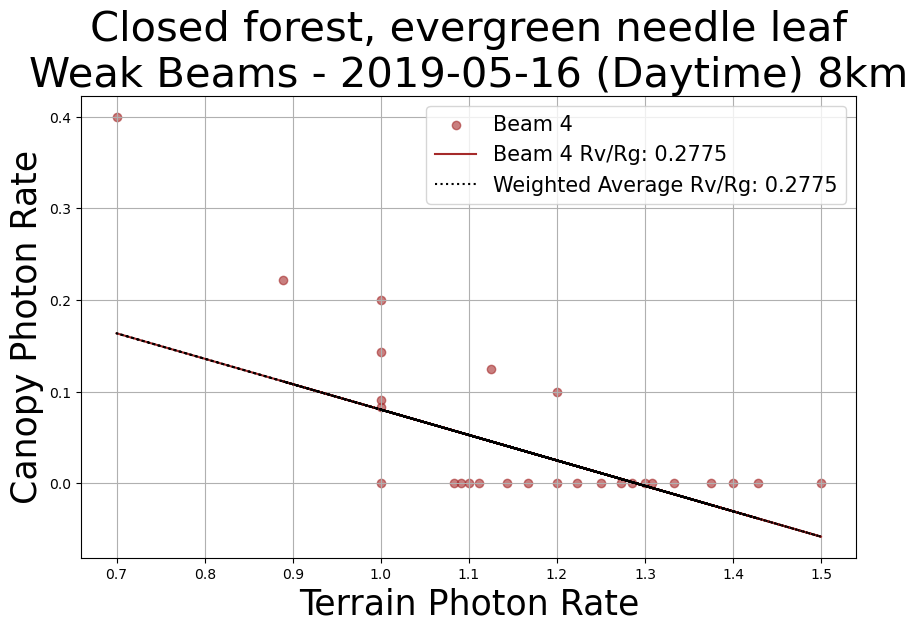

Plot saved as day/DEJU/8/DEJU_2019-05-16_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2019-09-12, weak beams: 1 points
No valid data for 2019-09-12 with weak beams for landcover Closed forest, evergreen needle leaf. Skipping plot.
Filtered data for landcover Closed forest, evergreen needle leaf, date 2020-01-05, weak beams: 140 points
test: [2]
Beam 2: 140 points
Spot value counts for beam 2:
spot
2    140
Name: count, dtype: int64
Weak Beam 2: Color = orange


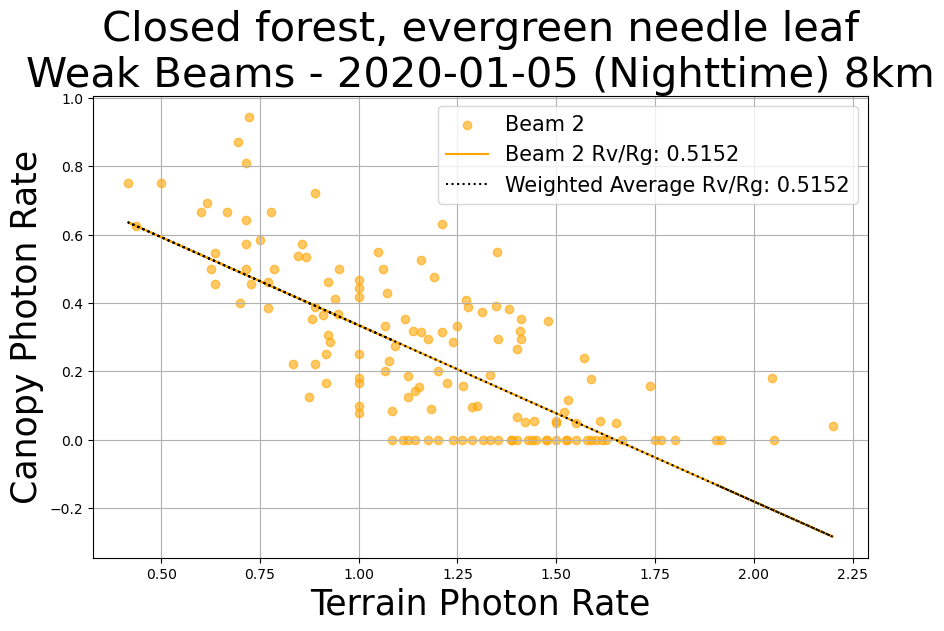

Plot saved as day/DEJU/8/DEJU_2020-01-05_weak_111_8km.png
Filtered data for landcover Closed forest, mixed/unknown, date 2020-01-05, weak beams: 5 points
No valid data for 2020-01-05 with weak beams for landcover Closed forest, mixed/unknown. Skipping plot.
Filtered data for landcover Closed forest, evergreen needle leaf, date 2020-05-03, weak beams: 62 points
test: [2, 4, 6]
Beam 2: 11 points
Spot value counts for beam 2:
spot
2    11
Name: count, dtype: int64
Weak Beam 2: Color = orange
Beam 4: 39 points
Spot value counts for beam 4:
spot
4    39
Name: count, dtype: int64
Weak Beam 4: Color = brown
Beam 6: 12 points
Spot value counts for beam 6:
spot
6    12
Name: count, dtype: int64
Weak Beam 6: Color = pink


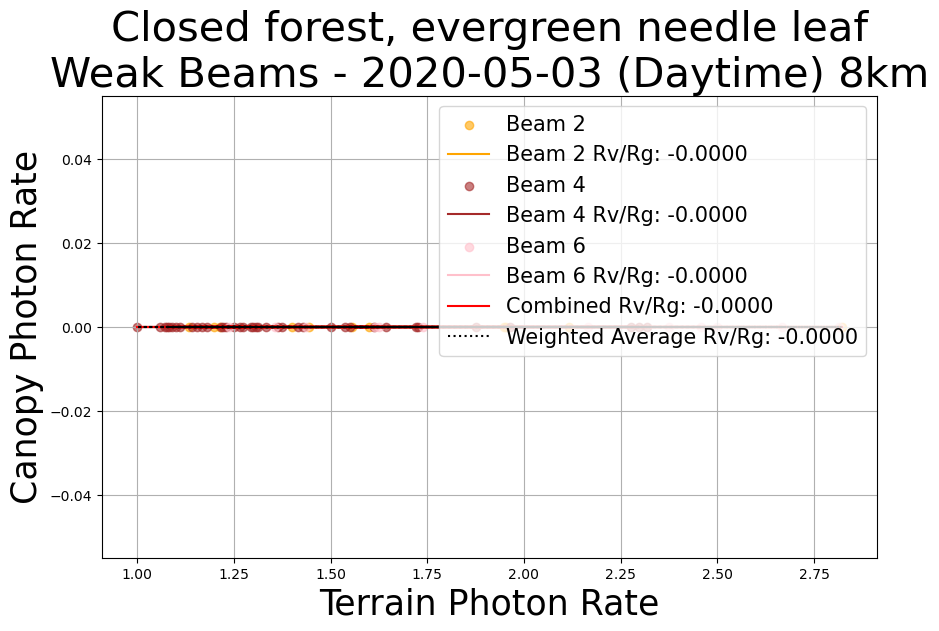

Plot saved as day/DEJU/8/DEJU_2020-05-03_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2020-05-13, weak beams: 16 points
test: [2]
Beam 2: 12 points
Spot value counts for beam 2:
spot
2    12
Name: count, dtype: int64
Weak Beam 2: Color = orange


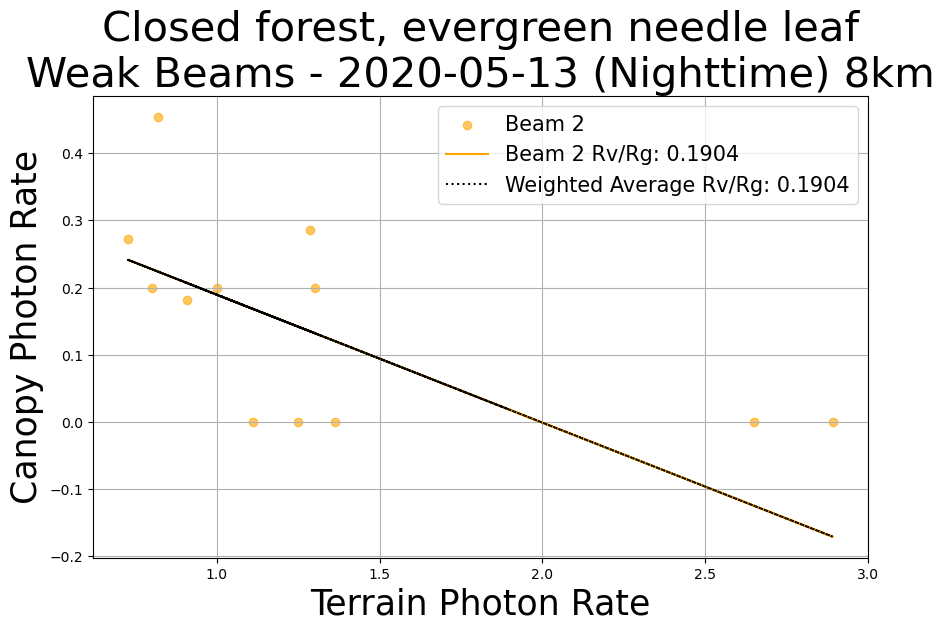

Plot saved as day/DEJU/8/DEJU_2020-05-13_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2020-07-04, weak beams: 11 points
test: [6]
Beam 6: 11 points
Spot value counts for beam 6:
spot
6    11
Name: count, dtype: int64
Weak Beam 6: Color = pink


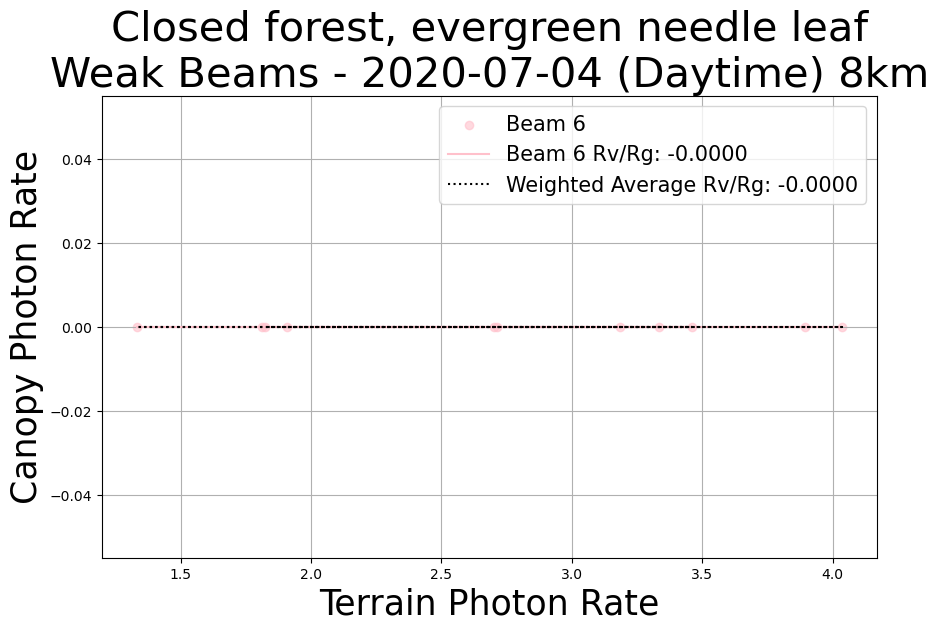

Plot saved as day/DEJU/8/DEJU_2020-07-04_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2020-08-12, weak beams: 11 points
test: [2]
Beam 2: 11 points
Spot value counts for beam 2:
spot
2    11
Name: count, dtype: int64
Weak Beam 2: Color = orange


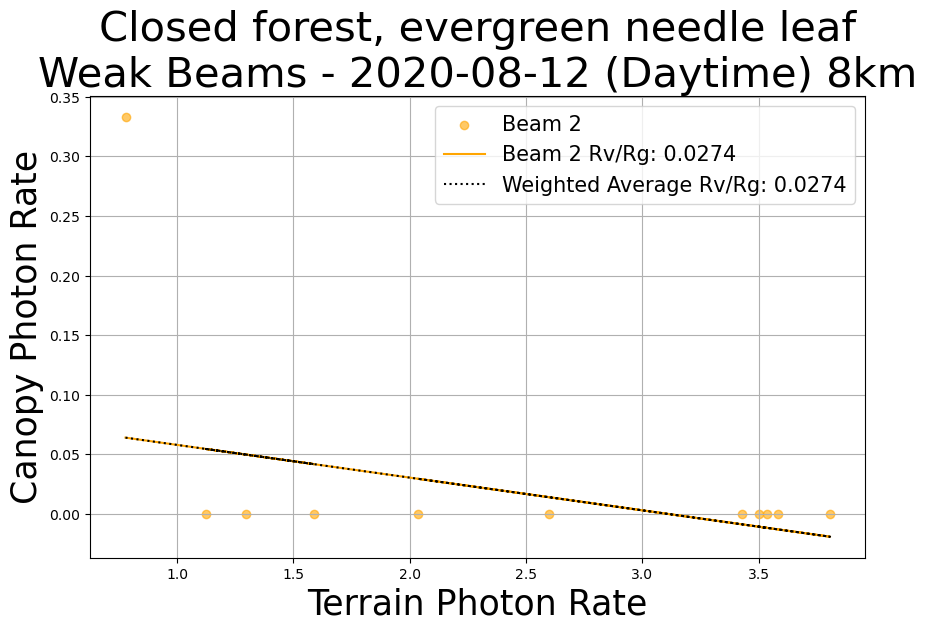

Plot saved as day/DEJU/8/DEJU_2020-08-12_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2020-11-11, weak beams: 344 points
test: [2, 4, 6]
Beam 2: 119 points
Spot value counts for beam 2:
spot
2    119
Name: count, dtype: int64
Weak Beam 2: Color = orange
Beam 4: 116 points
Spot value counts for beam 4:
spot
4    116
Name: count, dtype: int64
Weak Beam 4: Color = brown
Beam 6: 109 points
Spot value counts for beam 6:
spot
6    109
Name: count, dtype: int64
Weak Beam 6: Color = pink


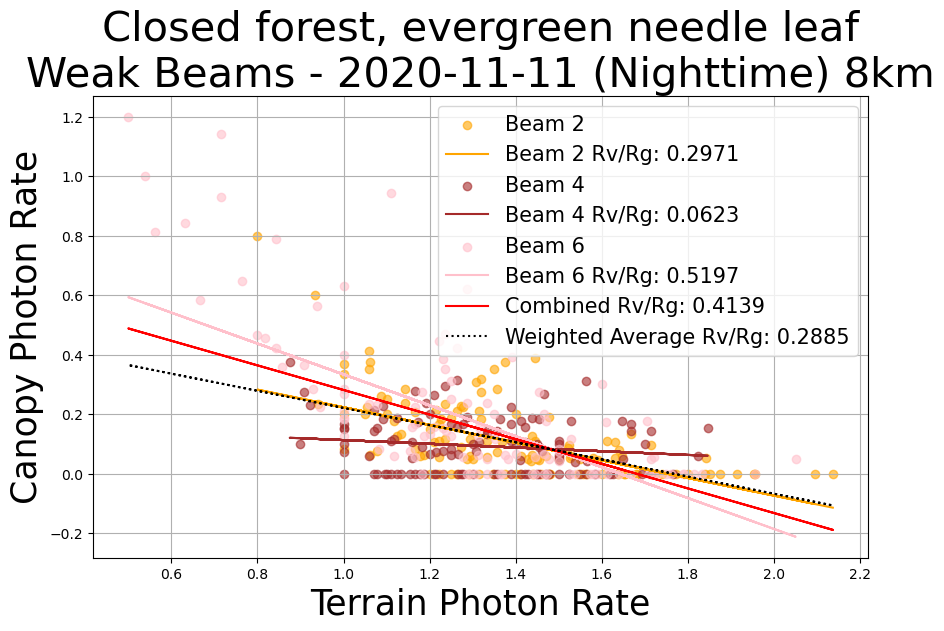

Plot saved as day/DEJU/8/DEJU_2020-11-11_weak_111_8km.png
Filtered data for landcover Closed forest, mixed/unknown, date 2020-11-11, weak beams: 5 points
No valid data for 2020-11-11 with weak beams for landcover Closed forest, mixed/unknown. Skipping plot.
Filtered data for landcover Closed forest, evergreen needle leaf, date 2021-01-02, weak beams: 181 points
test: [6]
Beam 6: 175 points
Spot value counts for beam 6:
spot
6    175
Name: count, dtype: int64
Weak Beam 6: Color = pink


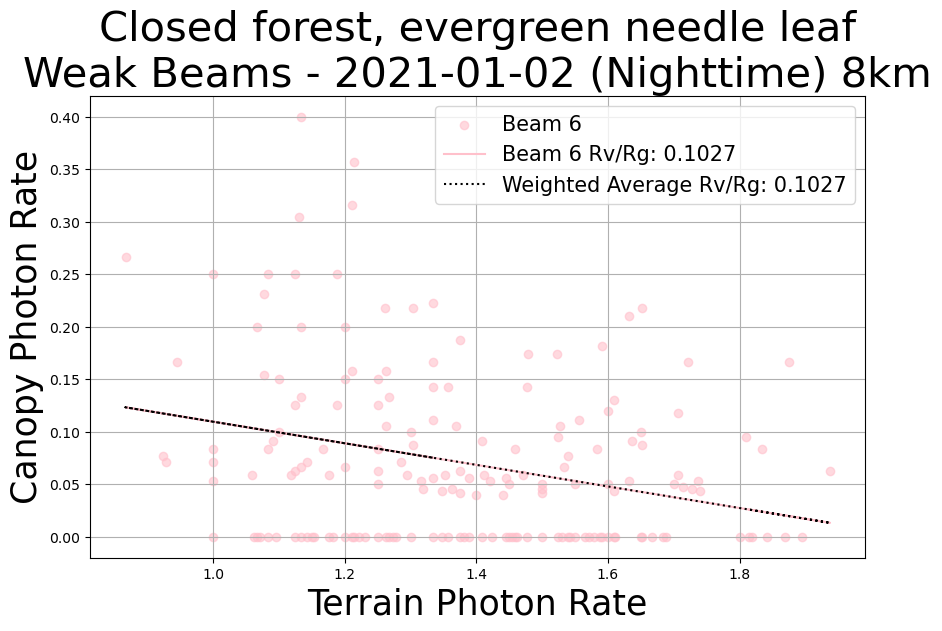

Plot saved as day/DEJU/8/DEJU_2021-01-02_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2021-02-09, weak beams: 109 points
test: [6]
Beam 6: 109 points
Spot value counts for beam 6:
spot
6    109
Name: count, dtype: int64
Weak Beam 6: Color = pink


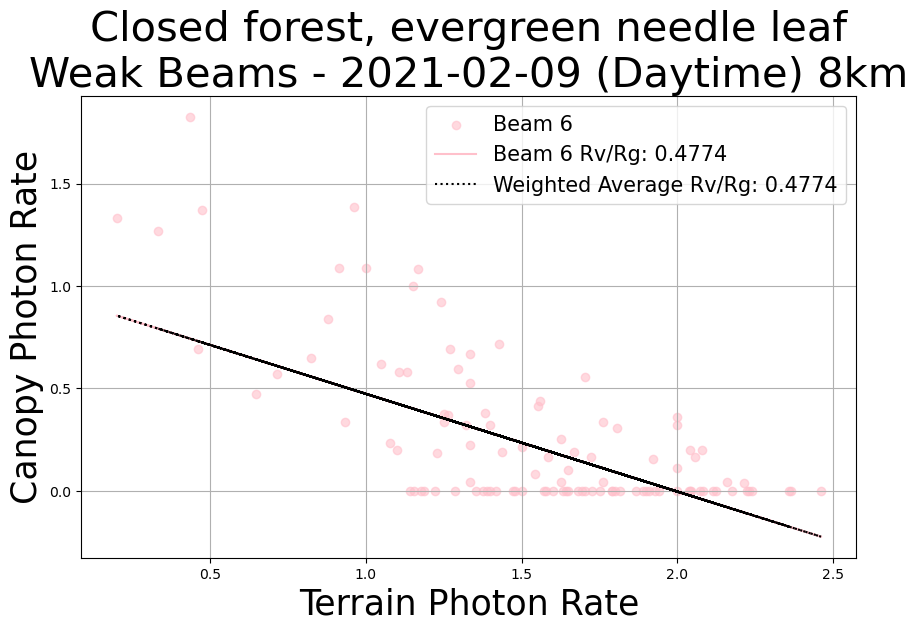

Plot saved as day/DEJU/8/DEJU_2021-02-09_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2021-05-02, weak beams: 99 points
test: [4]
Beam 4: 99 points
Spot value counts for beam 4:
spot
4    99
Name: count, dtype: int64
Weak Beam 4: Color = brown


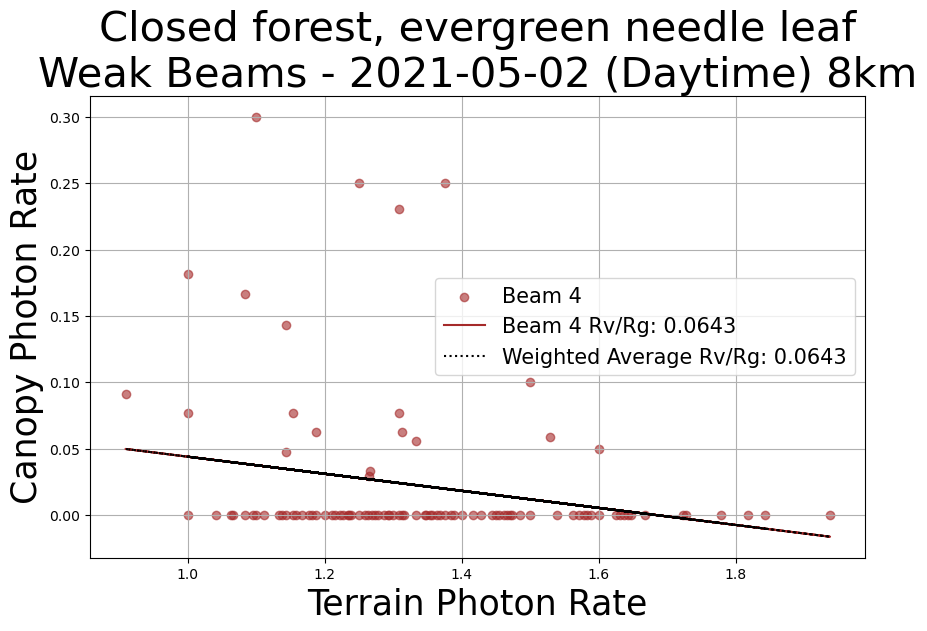

Plot saved as day/DEJU/8/DEJU_2021-05-02_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2021-08-01, weak beams: 16 points
test: [6]
Beam 6: 16 points
Spot value counts for beam 6:
spot
6    16
Name: count, dtype: int64
Weak Beam 6: Color = pink


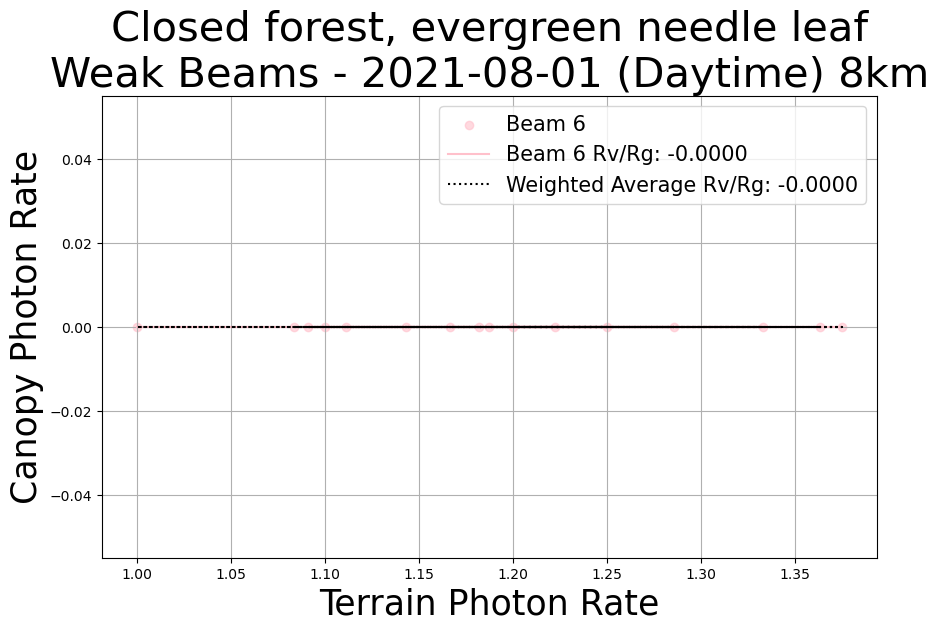

Plot saved as day/DEJU/8/DEJU_2021-08-01_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2022-04-30, weak beams: 211 points
test: [4]
Beam 4: 211 points
Spot value counts for beam 4:
spot
4    211
Name: count, dtype: int64
Weak Beam 4: Color = brown


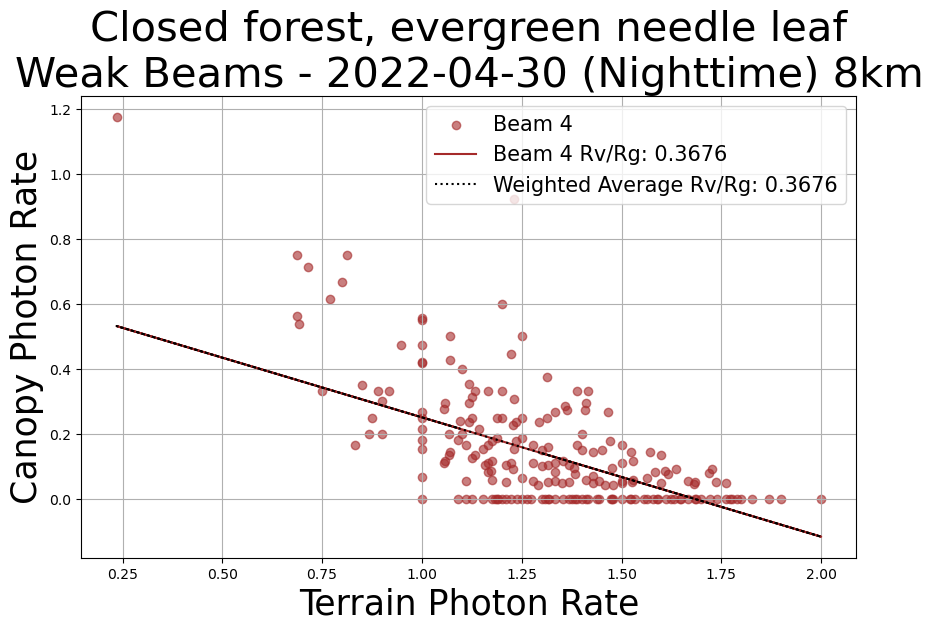

Plot saved as day/DEJU/8/DEJU_2022-04-30_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2022-05-09, weak beams: 17 points
test: [6]
Beam 6: 17 points
Spot value counts for beam 6:
spot
6    17
Name: count, dtype: int64
Weak Beam 6: Color = pink


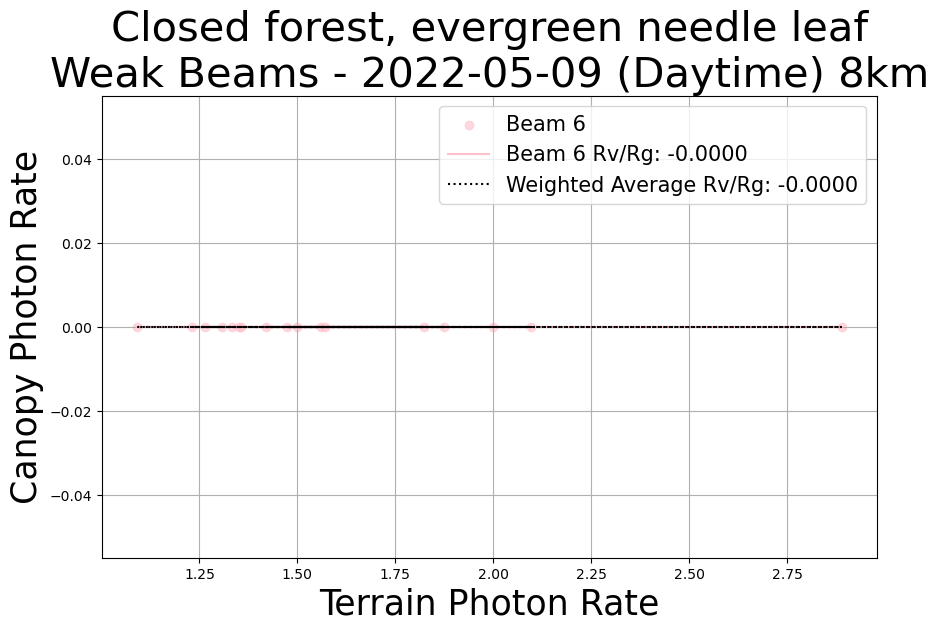

Plot saved as day/DEJU/8/DEJU_2022-05-09_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2022-07-30, weak beams: 73 points
test: [4, 6]
Beam 4: 16 points
Spot value counts for beam 4:
spot
4    16
Name: count, dtype: int64
Weak Beam 4: Color = brown
Beam 6: 49 points
Spot value counts for beam 6:
spot
6    49
Name: count, dtype: int64
Weak Beam 6: Color = pink


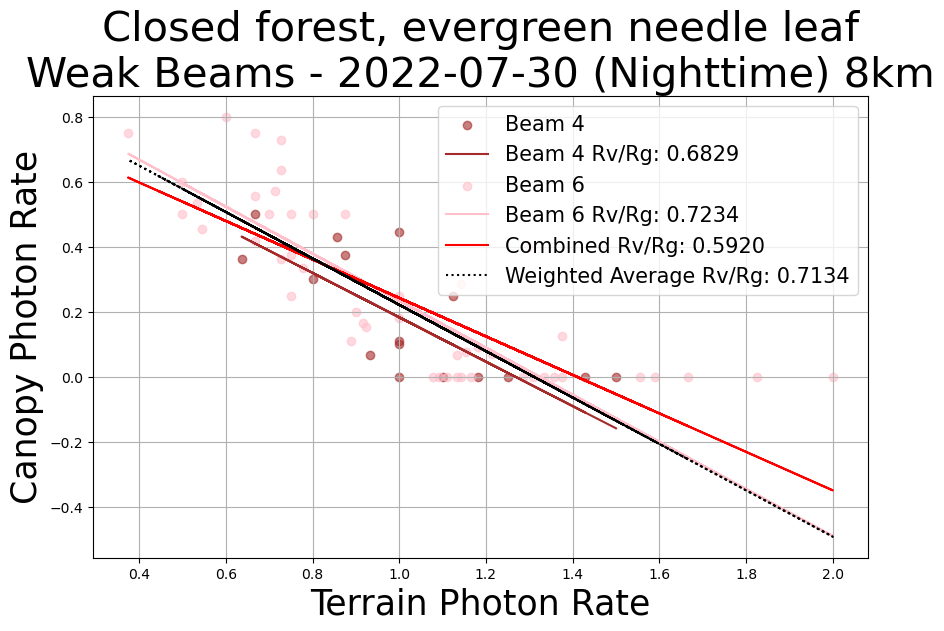

Plot saved as day/DEJU/8/DEJU_2022-07-30_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2022-10-29, weak beams: 83 points
test: [6]
Beam 6: 83 points
Spot value counts for beam 6:
spot
6    83
Name: count, dtype: int64
Weak Beam 6: Color = pink


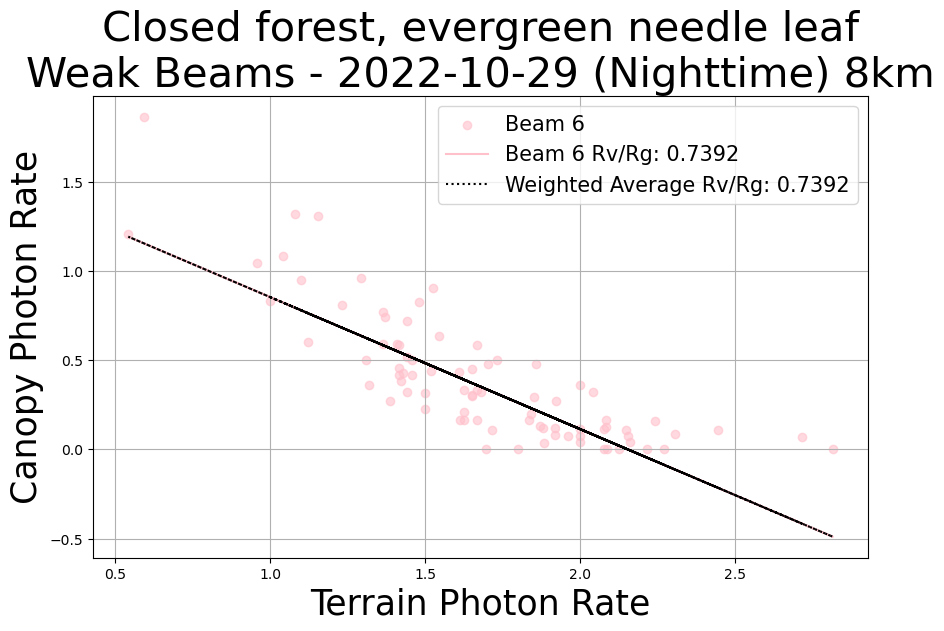

Plot saved as day/DEJU/8/DEJU_2022-10-29_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2023-01-27, weak beams: 147 points
test: [4, 6]
Beam 4: 36 points
Spot value counts for beam 4:
spot
4    36
Name: count, dtype: int64
Weak Beam 4: Color = brown
Beam 6: 111 points
Spot value counts for beam 6:
spot
6    111
Name: count, dtype: int64
Weak Beam 6: Color = pink


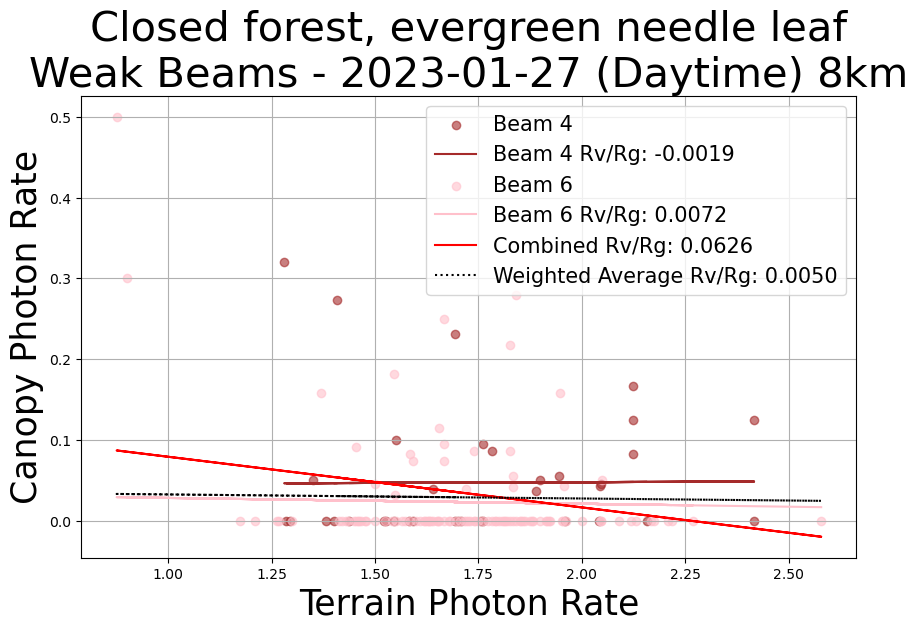

Plot saved as day/DEJU/8/DEJU_2023-01-27_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2023-02-06, weak beams: 66 points
test: [4, 6]
Beam 4: 55 points
Spot value counts for beam 4:
spot
4    55
Name: count, dtype: int64
Weak Beam 4: Color = brown
Beam 6: 11 points
Spot value counts for beam 6:
spot
6    11
Name: count, dtype: int64
Weak Beam 6: Color = pink


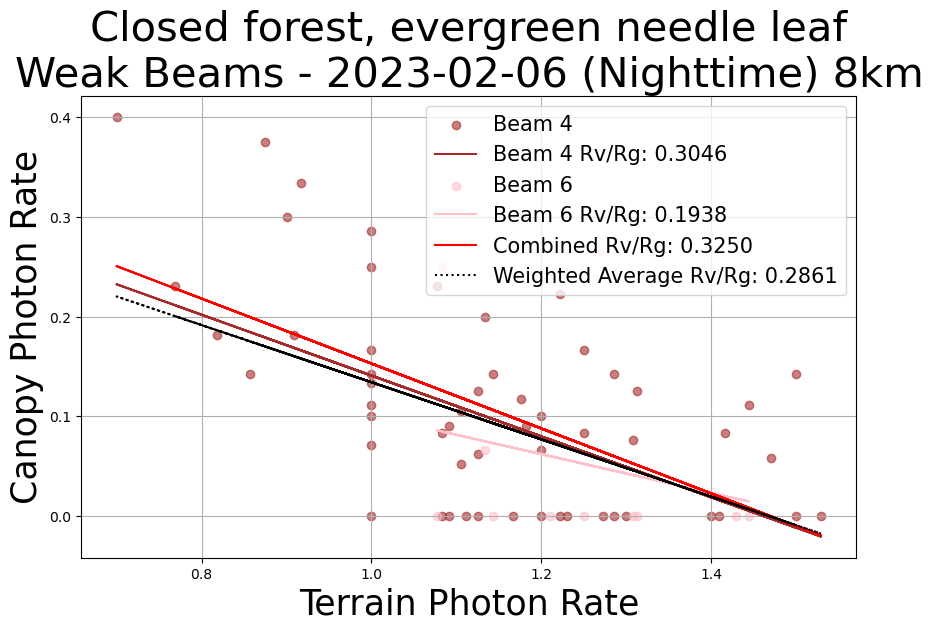

Plot saved as day/DEJU/8/DEJU_2023-02-06_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2023-04-28, weak beams: 11 points
No valid data for 2023-04-28 with weak beams for landcover Closed forest, evergreen needle leaf. Skipping plot.
Filtered data for landcover Closed forest, evergreen needle leaf, date 2023-05-08, weak beams: 107 points
test: [4, 6]
Beam 4: 24 points
Spot value counts for beam 4:
spot
4    24
Name: count, dtype: int64
Weak Beam 4: Color = brown
Beam 6: 83 points
Spot value counts for beam 6:
spot
6    83
Name: count, dtype: int64
Weak Beam 6: Color = pink


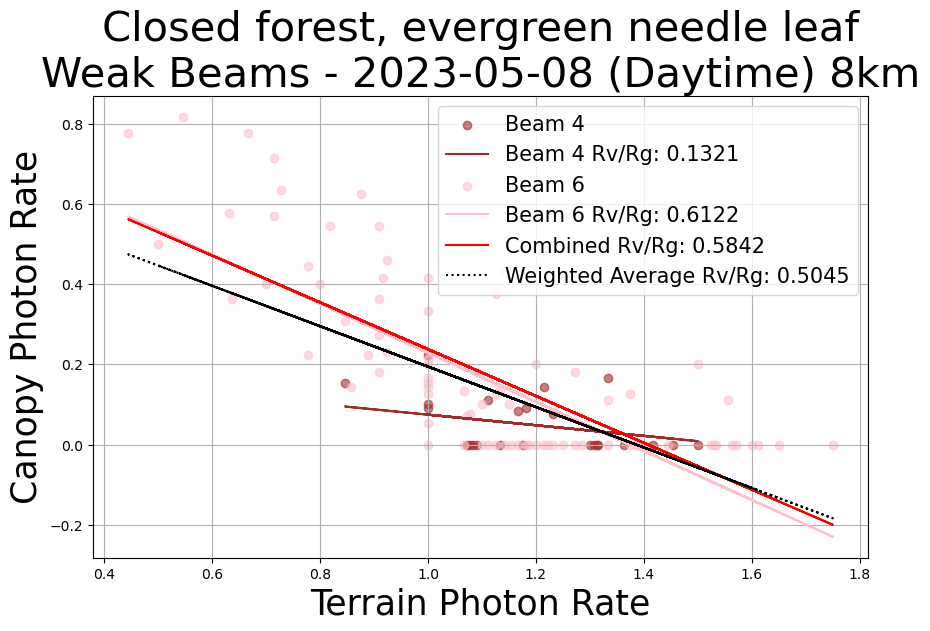

Plot saved as day/DEJU/8/DEJU_2023-05-08_weak_111_8km.png
Filtered data for landcover Closed forest, evergreen needle leaf, date 2023-07-28, weak beams: 0 points
No data available for 2023-07-28 with weak beams for landcover Closed forest, evergreen needle leaf.
Filtered data for landcover Closed forest, evergreen needle leaf, date 2023-08-07, weak beams: 7 points
No valid data for 2023-08-07 with weak beams for landcover Closed forest, evergreen needle leaf. Skipping plot.
Filtered data for landcover Closed forest, evergreen needle leaf, date 2023-10-27, weak beams: 10 points
test: [2]
Beam 2: 10 points
Spot value counts for beam 2:
spot
2    10
Name: count, dtype: int64
Weak Beam 2: Color = orange


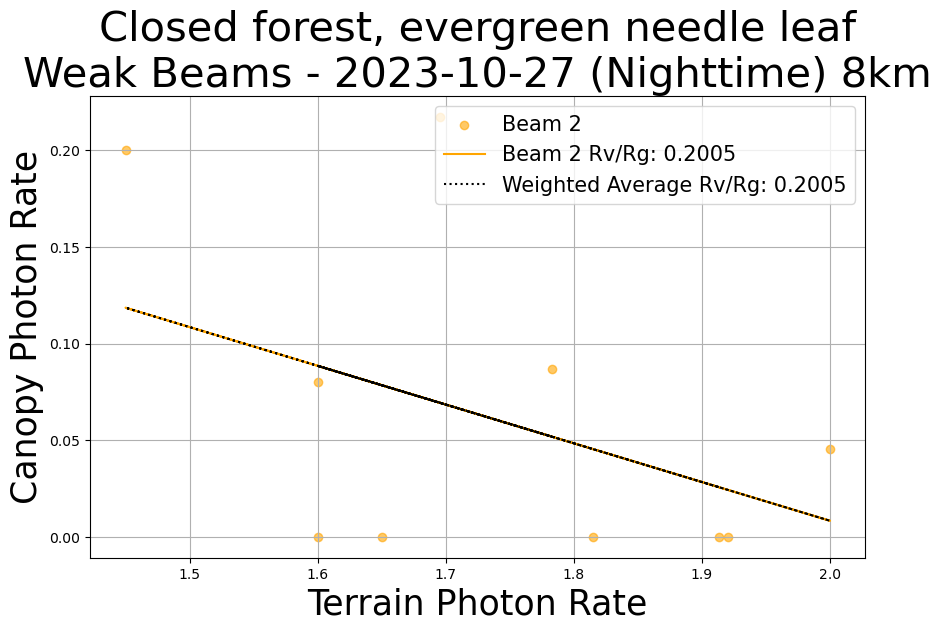

Plot saved as day/DEJU/8/DEJU_2023-10-27_weak_111_8km.png


In [22]:
def plot_weak_beams_only(processed_site_data, folder, site_name, solar_elev_counts, boundary_km):
    regression_results = {'weak': {}}  # Separate results for weak beam type
    colors = {2: 'orange', 4: 'brown', 6: 'pink'}  # Specific colors for weak beams

    # Define landcover types
    landcover_codes = {111: 'Closed forest, evergreen needle leaf', 115: 'Closed forest, mixed/unknown'}

    for date, data in processed_site_data.items():
        daytime_count = solar_elev_counts.get(date, {}).get("daytime", 0)
        nighttime_count = solar_elev_counts.get(date, {}).get("nighttime", 0)
        time_of_day = "Daytime" if daytime_count > nighttime_count else "Nighttime"
        
        # Loop over the two landcover codes
        for landcover_code, landcover_label in landcover_codes.items():
            # Filter the data based on the current landcover type
            filtered_data = data[data['landcover_mode'] == landcover_code]
            if filtered_data.empty:
                continue  # Skip to the next landcover type if no data for this landcover

            # Create a plot for this landcover type
            fig, ax = plt.subplots(figsize=(10, 6))

            # Loop through weak beam types
            weak_beams = [2, 4, 6]
            beam_filtered_data = filtered_data.copy()
            regression_results['weak'].setdefault(landcover_code, {}).setdefault(date, {})['time_of_day'] = time_of_day
            valid_data_found = False
            target_date = pd.to_datetime(date).date()
            beam_filtered_data['constructed_date'] = pd.to_datetime(beam_filtered_data[['year', 'month', 'day']])
            beam_filter = beam_filtered_data['spot'].isin(weak_beams)
            filtered_data_for_beams = beam_filtered_data[(beam_filtered_data['constructed_date'].dt.date == target_date) & beam_filter]
            filtered_data_for_beams = filtered_data_for_beams.dropna(subset=['canopy_photon_rate', 'terrain_photon_rate'])
            filtered_data_for_beams = filtered_data_for_beams.drop_duplicates(subset=['canopy_photon_rate', 'terrain_photon_rate'])
            
            # Debug statement
            print(f"Filtered data for landcover {landcover_label}, date {date}, weak beams: {filtered_data_for_beams.shape[0]} points")

            if filtered_data_for_beams.empty:
                print(f"No data available for {target_date} with weak beams for landcover {landcover_label}.")
                continue

            # Only plot scatter for beams with >= 10 points
            valid_beams = [beam for beam in weak_beams if len(filtered_data_for_beams[filtered_data_for_beams['spot'] == beam]) >= 10]

            # If no valid beams, skip to the next date
            if not valid_beams:
                print(f"No valid data for {date} with weak beams for landcover {landcover_label}. Skipping plot.")
                plt.close()
                continue

            # Initialize lists to store regression results and weights
            beam_regression_results = []
            weights = []  # Store corresponding weights (data points per beam)

            print(f"test: {valid_beams}")

            # Loop through each valid beam for plotting and regression
            for beam in valid_beams:
                beam_data = filtered_data_for_beams[filtered_data_for_beams['spot'] == beam]
                print(f"Beam {beam}: {len(beam_data)} points")
                
                # If you also want a breakdown of the 'spot' value counts
                print(f"Spot value counts for beam {beam}:")
                print(beam_data['spot'].value_counts())
                # Debug statement
                print(f"Weak Beam {beam}: Color = {colors.get(beam, 'None')}")
                ax.scatter(beam_data['terrain_photon_rate'], beam_data['canopy_photon_rate'], color=colors[beam], label=f"Beam {beam}", alpha=0.6)
                
                # Calculate weights based on terrain standard deviations
                terrain_mean = beam_data['terrain_photon_rate'].mean()
                terrain_std = beam_data['terrain_photon_rate'].std()
                terrain_deviation = np.abs((beam_data['terrain_photon_rate'] - terrain_mean) / terrain_std)
                terrain_weight = np.exp(-0.5 * (terrain_deviation ** 2))
                beam_weights = terrain_weight

                # Perform weighted regression
                slope, intercept = weighted_regression(beam_data['terrain_photon_rate'], beam_data['canopy_photon_rate'], beam_weights)
                regression_line = slope * beam_data['terrain_photon_rate'] + intercept
                rv_rg = -1 * slope
                ax.plot(beam_data['terrain_photon_rate'], regression_line, linestyle='-', label=f"Beam {beam} Rv/Rg: {rv_rg:.4f}", color=colors[beam])
                beam_regression_results.append(rv_rg)
                weights.append(len(beam_data))  # Store number of data points for each beam

                regression_results['weak'].setdefault(landcover_code, {}).setdefault(date, {})[beam] = {'slope': slope, 'intercept': intercept}

            # Combined regression for the entire dataset
            if len(beam_regression_results) > 1:
                combined_slope, combined_intercept, *_ = linregress(filtered_data_for_beams['terrain_photon_rate'], filtered_data_for_beams['canopy_photon_rate'])
                combined_line = combined_slope * filtered_data_for_beams['terrain_photon_rate'] + combined_intercept
                combined_rv_rg = -combined_slope
                ax.plot(filtered_data_for_beams['terrain_photon_rate'], combined_line, color='red', label=f"Combined Rv/Rg: {combined_rv_rg:.4f}")
                regression_results['weak'][landcover_code].setdefault(date, {})['combined'] = {'rv_rg': combined_rv_rg, 'slope': combined_slope, 'intercept': combined_intercept}


            # Calculate the weighted average Rv/Rg for beams with >= 10 data points
            if beam_regression_results:
                valid_slopes = [regression_results['weak'][landcover_code].get(date, {}).get(beam, {}).get('slope') for beam in valid_beams]
                valid_intercepts = [regression_results['weak'][landcover_code].get(date, {}).get(beam, {}).get('intercept') for beam in valid_beams]

                # Calculate weighted average for intercepts and slopes
                weighted_avg_intercept = np.average(valid_intercepts, weights=weights)
                weighted_avg_slope = np.average(valid_slopes, weights=weights)
                weighted_avg_rv_rg = -weighted_avg_slope  # Since Rv/Rg = -slope

                # Plot the weighted average regression line
                avg_regression_line = weighted_avg_slope * filtered_data_for_beams['terrain_photon_rate'] + weighted_avg_intercept
                ax.plot(filtered_data_for_beams['terrain_photon_rate'], avg_regression_line, color='black', linestyle=':', 
                        label=f"Weighted Average Rv/Rg: {weighted_avg_rv_rg:.4f}")

                # Store the weighted average results
                regression_results['weak'][landcover_code].setdefault(date, {})['weighted_average'] = {
                    'rv_rg': weighted_avg_rv_rg, 
                    'slope': weighted_avg_slope, 
                    'intercept': weighted_avg_intercept
                }

            # Plot settings
            ax.set_xlabel('Terrain Photon Rate', fontsize=25)
            ax.set_ylabel('Canopy Photon Rate', fontsize=25)
            ax.set_title(f'{landcover_label}\nWeak Beams - {target_date} ({time_of_day}) {boundary_km}km', fontsize=30)
            ax.legend(fontsize=15)
            ax.grid(True)

            save_folder = os.path.join(folder, site_name, boundary_km)
            os.makedirs(save_folder, exist_ok=True)
            savefile = os.path.join(save_folder, f'{site_name}_{date}_weak_{landcover_code}_{boundary_km}km.png')
            plt.savefig(savefile, bbox_inches='tight', dpi=300)
            plt.show()
            print(f"Plot saved as {savefile}")

        plt.close()

    return regression_results

regression_results_weak = plot_weak_beams_only(new_processed_site_data, day_folder, site_name, solar_elev_counts, boundary_km)

[DEBUG] Filtered individual beams data for Closed forest, evergreen needle leaf:
        date  beam     rv_rg                        landcover_type
0 2019-05-06     1 -0.000000  Closed forest, evergreen needle leaf
1 2019-05-06     3  0.869816  Closed forest, evergreen needle leaf
2 2019-05-16     3  0.295158  Closed forest, evergreen needle leaf
3 2019-09-12     1 -0.000000  Closed forest, evergreen needle leaf
4 2020-01-05     1  0.191762  Closed forest, evergreen needle leaf
[DEBUG] Filtered strong combined data for Closed forest, evergreen needle leaf:
        date     rv_rg                        landcover_type
0 2019-05-06  0.369237  Closed forest, evergreen needle leaf
1 2020-05-03  0.014803  Closed forest, evergreen needle leaf
2 2020-05-13  0.201195  Closed forest, evergreen needle leaf
3 2020-11-11  0.082947  Closed forest, evergreen needle leaf
4 2021-05-02  0.027493  Closed forest, evergreen needle leaf
[DEBUG] Filtered weak combined data for Closed forest, evergreen needle

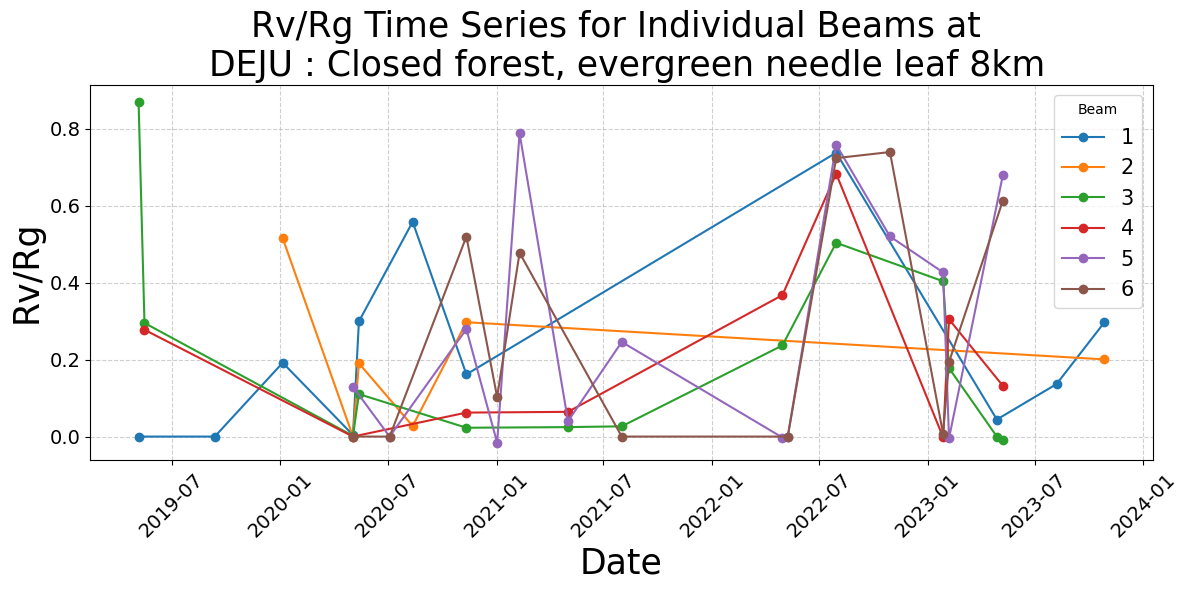

Plot saved: day/DEJU/8/DEJU_individual_beams_time_series_Closed_forest_evergreen_needle_leaf_8km.png
12 12
6 6


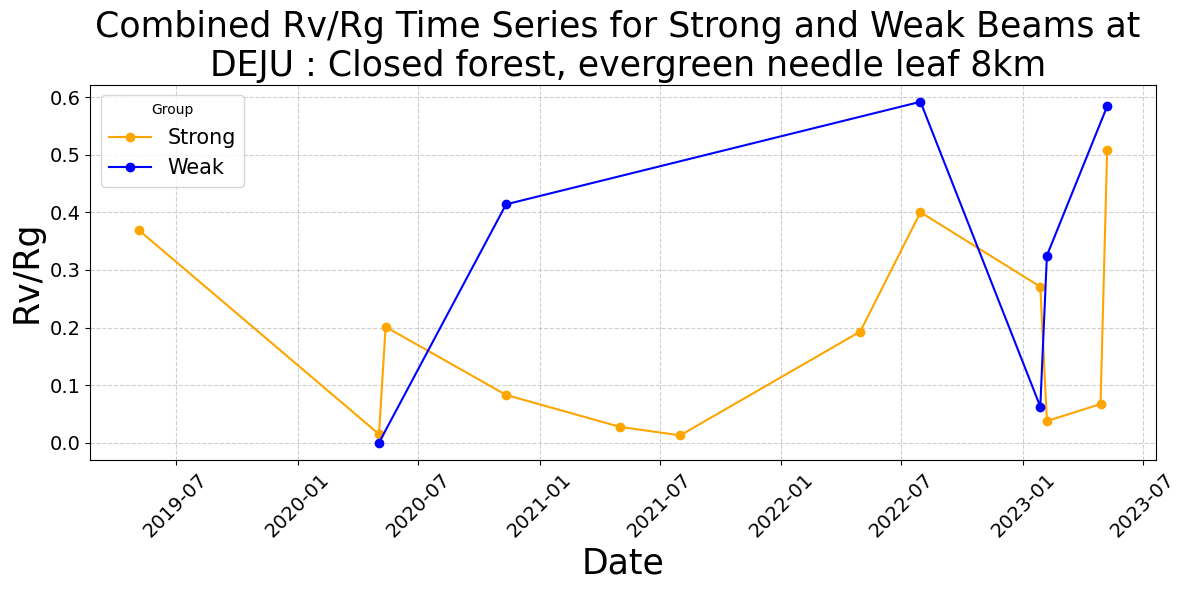

Plot saved: day/DEJU/8/DEJU_combined_regressions_time_series_Closed_forest_evergreen_needle_leaf_8km.png
23 23
19 19


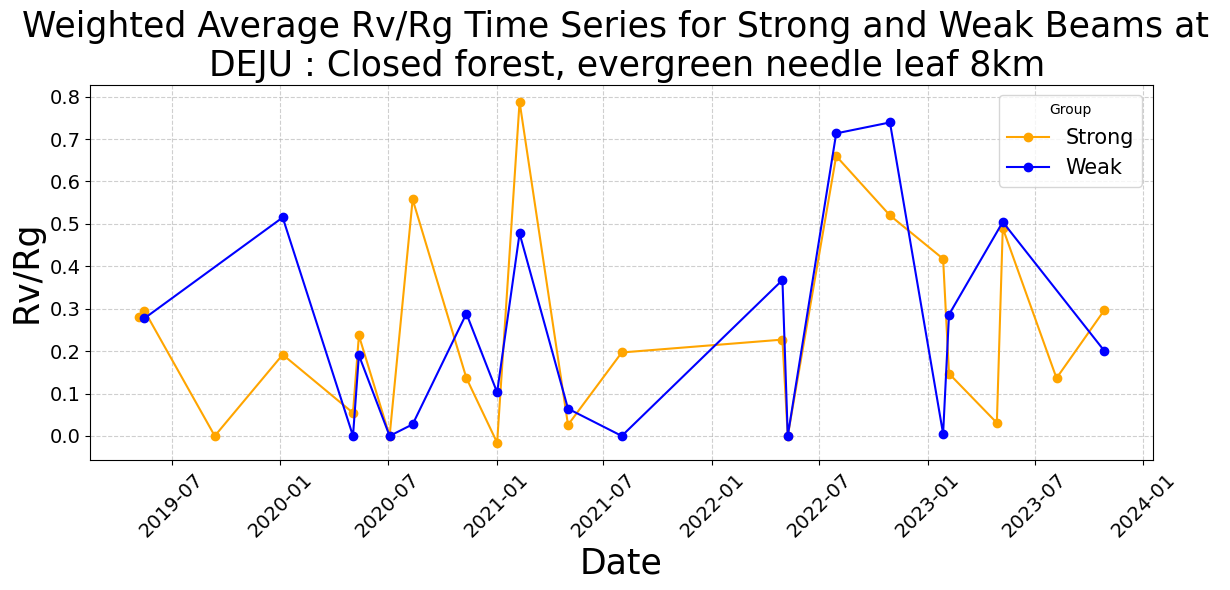

Plot saved: day/DEJU/8/DEJU_weighted_average_time_series_Closed_forest_evergreen_needle_leaf_8km.png
[DEBUG] Filtered individual beams data for Closed forest, mixed/unknown:
         date  beam     rv_rg                landcover_type
38 2019-05-06     1  0.013267  Closed forest, mixed/unknown
39 2019-05-06     3 -0.051648  Closed forest, mixed/unknown
40 2019-05-16     1  0.105839  Closed forest, mixed/unknown
41 2019-05-16     3  0.257838  Closed forest, mixed/unknown
42 2019-09-12     1 -0.000000  Closed forest, mixed/unknown
[DEBUG] Filtered strong combined data for Closed forest, mixed/unknown:
         date     rv_rg                landcover_type
12 2019-05-06  0.016606  Closed forest, mixed/unknown
13 2019-05-16  0.240041  Closed forest, mixed/unknown
14 2020-05-03  0.007743  Closed forest, mixed/unknown
15 2020-11-11  0.256076  Closed forest, mixed/unknown
16 2021-01-02 -0.003451  Closed forest, mixed/unknown
[DEBUG] Filtered weak combined data for Closed forest, mixed/unknown:


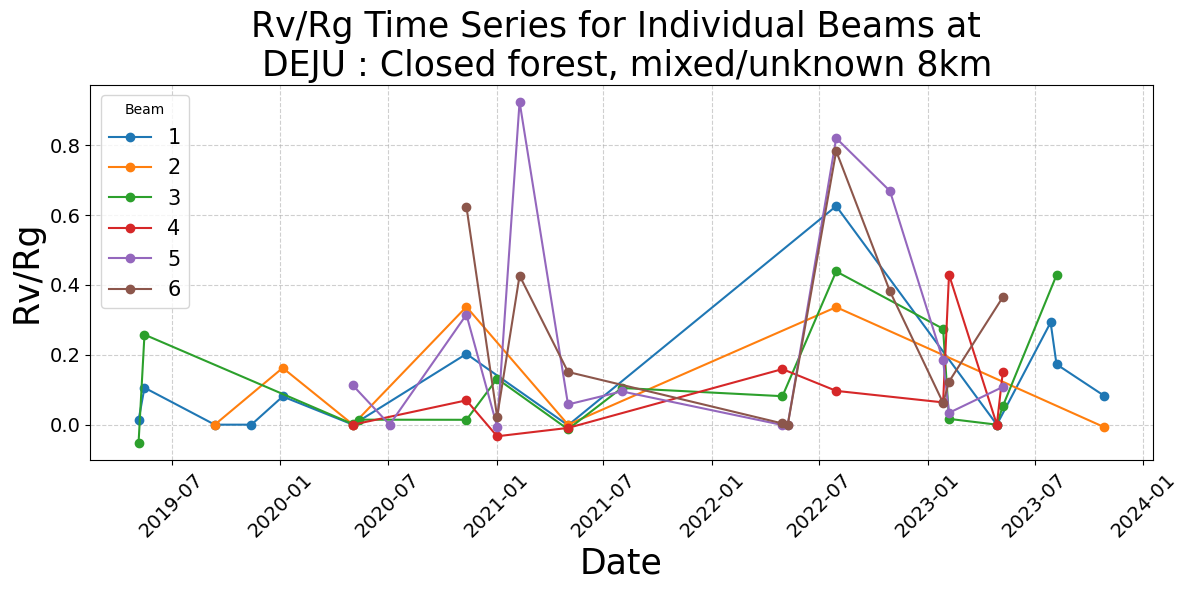

Plot saved: day/DEJU/8/DEJU_individual_beams_time_series_Closed_forest_mixed_unknown_8km.png
14 14
9 9


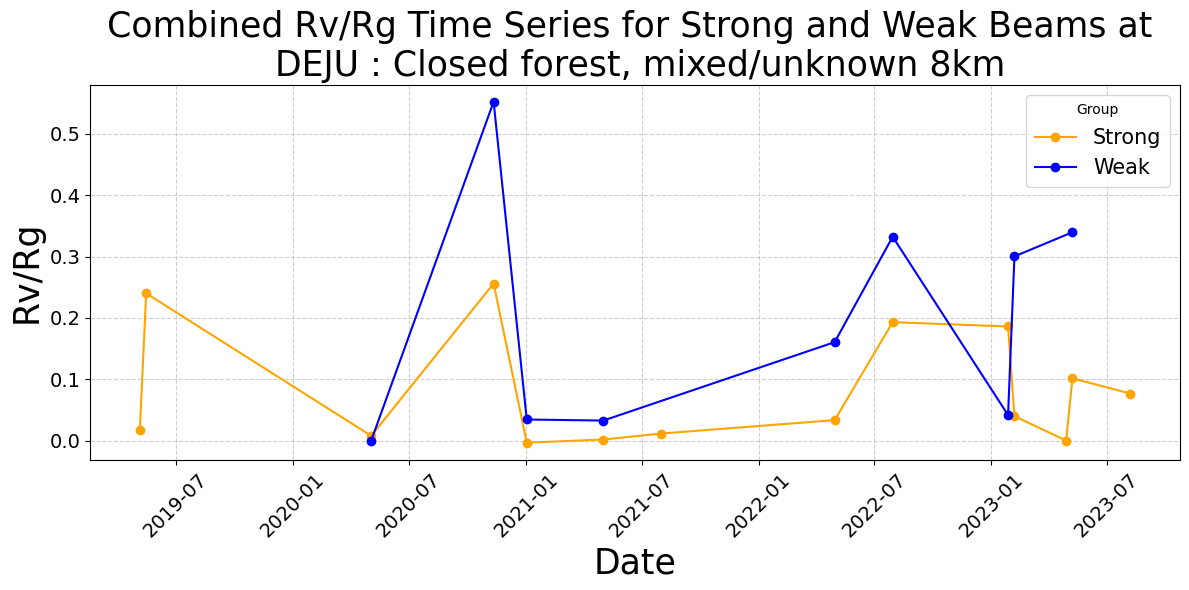

Plot saved: day/DEJU/8/DEJU_combined_regressions_time_series_Closed_forest_mixed_unknown_8km.png
24 24
16 16


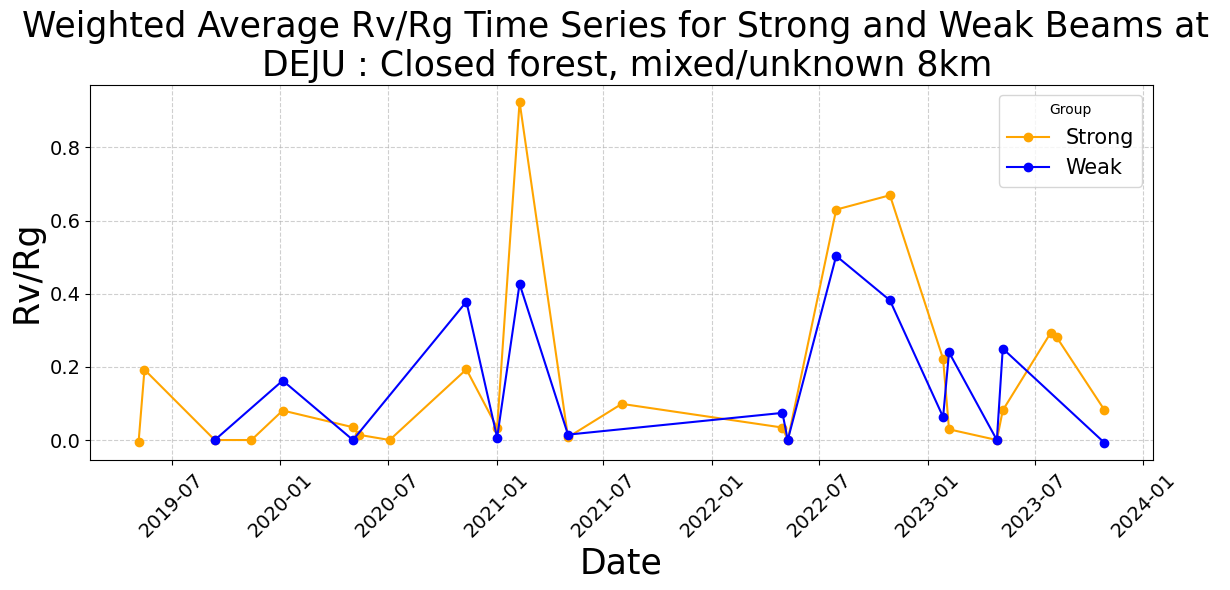

Plot saved: day/DEJU/8/DEJU_weighted_average_time_series_Closed_forest_mixed_unknown_8km.png
CPU times: user 5.21 s, sys: 252 ms, total: 5.47 s
Wall time: 5.63 s


In [23]:
%%time


def plot_regression_time_series_by_landcover(regression_results, site_name, folder, boundary_km):
    """
    Plots time series of regression results for:
    1. Individual beams with different colors
    2. Strong and weak beams (combined regressions) with different colors
    3. Weighted averages for strong and weak beams with different colors.
    
    Args:
        regression_results (dict): Regression results for strong and weak beams.
        site_name (str): The name of the site for naming the plot.
        folder (str): The folder where the plots should be saved.
        boundary_km (str): Boundary information for the site.
    """
    # Colors for individual beams
    beam_colors = {1: 'blue', 3: 'green', 5: 'purple', 2: 'orange', 4: 'brown', 6: 'pink'}
    time_series_data = {
        'individual': [],
        'strong_combined': [],
        'weak_combined': [],
        'strong_weighted': [],
        'weak_weighted': []
    }
    
    for beam_type, landcover_data in regression_results.items():
        for landcover_type, date_results in landcover_data.items():
            for date, results in date_results.items():
                # Parse date
                date_obj = pd.to_datetime(date)
                
                # Individual beams
                for beam, beam_result in results.items():
                    if beam == 'time_of_day':
                        continue
                    if beam not in ['combined', 'weighted_average']:
                        rv_rg = -beam_result['slope']
                        time_series_data['individual'].append({
                            'date': date_obj, 
                            'beam': beam, 
                            'rv_rg': rv_rg,
                            'landcover_type': landcover_type  # Keep landcover_type
                        })
                
                # Combined regression
                if 'combined' in results:
                    rv_rg = results['combined']['rv_rg']
                    time_series_data[f"{beam_type}_combined"].append({
                        'date': date_obj, 
                        'rv_rg': rv_rg,
                        'landcover_type': landcover_type  # Keep landcover_type
                    })
                
                # Weighted average
                if 'weighted_average' in results:
                    rv_rg = results['weighted_average']['rv_rg']
                    time_series_data[f"{beam_type}_weighted"].append({
                        'date': date_obj, 
                        'rv_rg': rv_rg,
                        'landcover_type': landcover_type  # Keep landcover_type
                    })

    # Convert to DataFrames for easier plotting
    df_individual = pd.DataFrame(time_series_data['individual'])
    df_strong_combined = pd.DataFrame(time_series_data['strong_combined'])
    df_weak_combined = pd.DataFrame(time_series_data['weak_combined'])
    df_strong_weighted = pd.DataFrame(time_series_data['strong_weighted'])
    df_weak_weighted = pd.DataFrame(time_series_data['weak_weighted'])

    def plot_time_series(data, x_col, y_col, hue_col, title, y_label, save_name, color_map=None):
        fig, ax = plt.subplots(figsize=(12, 6))

        # If color_map is not provided, use default colors for 'Strong' and 'Weak' categories
        if not color_map:
            color_map = {'Strong': 'orange', 'Weak': 'blue'}  # Example color map for Strong and Weak beams
            
        for key, group in data.groupby(hue_col):
            color = color_map.get(key, None) if color_map else None
            ax.plot(group[x_col], group[y_col], label=key, color=color, marker='o')
            print (len(group[x_col]), len(group[y_col]))
        
        # Title and labels
        ax.set_title(title, fontsize=25)
        ax.set_xlabel('Date', fontsize=25)
        ax.set_ylabel(y_label, fontsize=25)
        ax.tick_params(axis='x', rotation=45, labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        
        # Add legend
        ax.legend(title=hue_col.capitalize(), fontsize=15)
        
        # Add grid
        ax.grid(True, which='both', linestyle='--', alpha=0.6)
        
        # Save the plot
        savefolder = os.path.join(folder, site_name, boundary_km)

        # Create the directory structure if it doesn't exist
        if not os.path.exists(savefolder):
            os.makedirs(savefolder)
            print(f"Created directory: {savefolder}")
            
        # Ensure the file name is also safe (remove commas and special chars)
        save_name_safe = save_name.replace(",", "").replace(" ", "_").replace("/", "_")
        
        # Construct the full save file path
        savefile = os.path.join(savefolder, f"{site_name}_{save_name_safe}_{boundary_km}km.png")
    
        plt.tight_layout()
        plt.savefig(savefile, dpi=300)
        plt.show()
        print(f"Plot saved: {savefile}")
    
    # Loop over landcover types and create plots
    landcover_types = [
        ('Closed forest, evergreen needle leaf', [111]),
        ('Closed forest, mixed/unknown', [115, 116])
    ]
    
    for landcover_label, landcover_codes in landcover_types:
        # Filter the regression results for the current landcover type
        filtered_df_individual = df_individual[df_individual['landcover_type'] == landcover_label]
        
        filtered_df_strong_combined = df_strong_combined[df_strong_combined['landcover_type'] == landcover_label]
        
        filtered_df_weak_combined = df_weak_combined[df_weak_combined['landcover_type'] == landcover_label]
        
        filtered_df_strong_weighted = df_strong_weighted[df_strong_weighted['landcover_type'] == landcover_label]
        
        filtered_df_weak_weighted = df_weak_weighted[df_weak_weighted['landcover_type'] == landcover_label]
        
        print(f"[DEBUG] Filtered individual beams data for {landcover_label}:")
        print(filtered_df_individual.head())
        print(f"[DEBUG] Filtered strong combined data for {landcover_label}:")
        print(filtered_df_strong_combined.head())
        print(f"[DEBUG] Filtered weak combined data for {landcover_label}:")
        print(filtered_df_weak_combined.head())
        print(f"[DEBUG] Filtered strong weighted data for {landcover_label}:")
        print(filtered_df_strong_weighted.head())
        print(f"[DEBUG] Filtered weak weighted data for {landcover_label}:")
        print(filtered_df_weak_weighted.head())
        
        # Plot 1: Individual beams
        if not filtered_df_individual.empty:
            plot_time_series(
                data=filtered_df_individual,
                x_col='date',
                y_col='rv_rg',
                hue_col='beam',
                title=f"Rv/Rg Time Series for Individual Beams at \n {site_name} : {landcover_label} {boundary_km}km",
                y_label='Rv/Rg',
                save_name=f'individual_beams_time_series_{landcover_label}'
            )

        # Plot 2: Strong and weak combined regressions
        if not filtered_df_strong_combined.empty or not filtered_df_weak_combined.empty:
            combined_data = pd.concat([filtered_df_strong_combined.assign(group='Strong'), 
                                       filtered_df_weak_combined.assign(group='Weak')])
            plot_time_series(
                data=combined_data,
                x_col='date',
                y_col='rv_rg',
                hue_col='group',
                title=f"Combined Rv/Rg Time Series for Strong and Weak Beams at \n {site_name} : {landcover_label} {boundary_km}km",
                y_label='Rv/Rg',
                save_name=f'combined_regressions_time_series_{landcover_label}'
            )

        # Plot 3: Weighted averages for strong and weak beams
        if not filtered_df_strong_weighted.empty or not filtered_df_weak_weighted.empty:
            weighted_data = pd.concat([filtered_df_strong_weighted.assign(group='Strong'), 
                                      filtered_df_weak_weighted.assign(group='Weak')])
            plot_time_series(
                data=weighted_data,
                x_col='date',
                y_col='rv_rg',
                hue_col='group',
                title=f"Weighted Average Rv/Rg Time Series for Strong and Weak Beams at \n {site_name} : {landcover_label} {boundary_km}km",
                y_label='Rv/Rg',
                save_name=f'weighted_average_time_series_{landcover_label}'
            )

# Call the modified function
plot_regression_time_series_by_landcover(regression_results_strong, site_name, day_folder, boundary_km)


In [24]:
%%time
import json

# Assuming regression_results is generated from your function
with open('regression_results.json', 'w') as json_file:
    json.dump(regression_results_strong, json_file, indent=4)

CPU times: user 3.59 ms, sys: 0 ns, total: 3.59 ms
Wall time: 16.1 ms


In [ ]:
for beam_type, landcover_data in regression_results_strong.items():
    print(f"[DEBUG] Beam type: {beam_type}")
    for landcover_type, date_results in landcover_data.items():
        print(f"  [DEBUG] Landcover type: {landcover_type}")
        for date, results in date_results.items():
            print(f"    [DEBUG] Date: {date}, Results: {results}")

In [ ]:
for beam_type, date_results in regression_results.items():
    for date, results in date_results.items():
        print(date)
        # print(results.get("time_of_day") == "Nighttime")
        print(results)

In [ ]:
def output_regression_results_after_date(regression_results, date_cutoff='2023-07-01'):
    """
    Outputs the regression results for each beam, combined regression, and weighted regression
    after a specified date.

    Args:
        regression_results (dict): The regression results for each beam and the combined/weighted results.
        date_cutoff (str): The cutoff date in 'YYYY-MM-DD' format. Default is '2023-07-01'.

    Returns:
        None
    """
    # Convert the cutoff date to a datetime object
    date_cutoff = pd.to_datetime(date_cutoff)

    # Loop through the regression results and output results after the cutoff date
    for beam_type in ['strong', 'weak']:
        print(f"\n{beam_type.capitalize()} Beams Regression Results After {date_cutoff.date()}:")

        for date, results in regression_results[beam_type].items():
            # # Check if the time_of_day is nighttime
            if results.get("time_of_day") != "Nighttime":
                continue
            # Filter by date after the cutoff
            if pd.to_datetime(date) >= date_cutoff:
                print(f"\nResults for {date}:")
                
                # For each beam, output its regression results (slope, intercept, Rv/Rg)
                for beam, result in results.items():
                    if beam != 'combined' and beam != 'weighted_average':  # Exclude combined and weighted average from individual beams
                        print(f"  Beam {beam}:")
                        print(f"    Slope: {result['slope']}")
                        print(f"    Intercept: {result['intercept']}")
                        print(f"    Rv/Rg: {-result['slope']}")
                
                # Output combined regression results
                if 'combined' in results:
                    print(f"  Combined Regression:")
                    print(f"    Slope: {results['combined']['slope']}")
                    print(f"    Intercept: {results['combined']['intercept']}")
                    print(f"    Rv/Rg: {-results['combined']['slope']}")
                
                # Output weighted average regression results
                if 'weighted_average' in results:
                    print(f"  Weighted Average Regression:")
                    print(f"    Slope: {results['weighted_average']['slope']}")
                    print(f"    Intercept: {results['weighted_average']['intercept']}")
                    print(f"    Rv/Rg: {-results['weighted_average']['slope']}")

# Example usage
output_regression_results_after_date(regression_results, '2023-07-01')